This is the start of the new pipeline where we are mostly interested in the visual stuff, composites, mega-composites, contrasts, etc. 

In [1]:
# Cell 1: Import required libraries
import base64
from io import BytesIO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import json
import pandas as pd
import os
import seaborn as sns

In [2]:
# Cell 2: Data extraction functions
def extract_valid_results(jrzip_path):
    """Extract and validate results from JRZIP file"""
    def load_single_result(json_line):
        try:
            data = json.loads(json_line)
            # Check if this is a valid entry with required fields
            if (isinstance(data, dict) and 
                'metadata' in data and 
                'participant_id' in data['metadata']):
                return data
        except json.JSONDecodeError:
            return None
        return None

    valid_results = []
    with zipfile.ZipFile(jrzip_path, 'r') as zip_ref:
        for file_name in zip_ref.namelist():
            if file_name.endswith('.txt'):
                with zip_ref.open(file_name) as f:
                    content = f.read().decode('utf-8')
                    for line in content.split('\n'):
                        if line.strip():
                            result = load_single_result(line)
                            if result:
                                valid_results.append(result)
    
    print(f"Found {len(valid_results)} valid results")
    return valid_results

In [3]:
# Cell 3: DataFrame creation functions
def create_participant_df(valid_results):
    """Create participant info DataFrame"""
    participant_info = []
    for result in valid_results:
        info = {
            'participant_id': result['metadata']['participant_id'],
            'timestamp': result['metadata']['timestamp'],
            'filter_threshold': result['metadata']['parameters']['filter_parameters']['threshold'],
            'preservation_factor': result['metadata']['parameters']['filter_parameters']['preservation_factor'],
            'noise_reduction': result['metadata']['parameters']['filter_parameters']['noise_reduction_factor']
        }
        participant_info.append(info)
    return pd.DataFrame(participant_info).set_index('participant_id')

def create_training_df(valid_results):
    """Create training phase DataFrame"""
    training_data = []
    for result in valid_results:
        if isinstance(result.get('training_phase'), dict):
            training = {
                'participant_id': result['metadata']['participant_id'],
                'total_trials': result['training_phase']['summary']['total_trials'],
                'correct_trials': result['training_phase']['summary']['correct_trials'],
                'accuracy': result['training_phase']['summary']['accuracy_percentage'],
                'mean_rt': result['training_phase']['summary']['mean_rt']
            }
            training_data.append(training)
    return pd.DataFrame(training_data).set_index('participant_id')

def create_vviq_df(valid_results):
    """Create VVIQ DataFrame with attention check validation"""
    vviq_data = []
    for result in valid_results:
        participant_id = result['metadata']['participant_id']
        vviq_metadata = result['metadata'].get('vviq_data', {})
        
        # Check attention checks
        attention_checks = vviq_metadata.get('attention_check_passed', {})
        
        for eye_condition in ['eyes_open', 'eyes_closed']:
            responses = vviq_metadata.get(eye_condition, [])
            for response in responses:
                for item, rating in response.get('responses', {}).items():
                    vviq_data.append({
                        'participant_id': participant_id,
                        'condition': eye_condition,
                        'question_index': response.get('question_index'),
                        'item': item,
                        'rating': rating,
                        'attention_check_passed': attention_checks.get(eye_condition, False)
                    })
    return pd.DataFrame(vviq_data)

def create_caps_df(valid_results):
    """Create CAPS DataFrame"""
    caps_data = []
    for result in valid_results:
        participant_id = result['metadata']['participant_id']
        caps_responses = result['metadata'].get('caps_data', [])
        
        for response in caps_responses:
            caps_data.append({
                'participant_id': participant_id,
                'question_index': response.get('question_index'),
                'question_text': response.get('question_text'),
                'response': response.get('response'),
                'subscale': response.get('subscale')
            })
    return pd.DataFrame(caps_data)

def create_evolution_df(valid_results):
    """Create evolution DataFrame"""
    evolution_data = []
    for result in valid_results:
        participant_id = result['metadata']['participant_id']
        for entry in result['evolution_summary']:
            evolution_data.append({
                'participant_id': participant_id,
                'session': entry['session'],
                'generation': entry['generation'],
                'n_selections': len(entry['selected_parents'])
            })
    return pd.DataFrame(evolution_data)

In [6]:
# Cell 4: Analysis functions
def analyze_attention_checks(vviq_df):
    """Analyze VVIQ attention check performance"""
    attention_summary = vviq_df.groupby('participant_id')['attention_check_passed'].agg(['first', 'count'])
    attention_summary.columns = ['passed_check', 'total_responses']
    return attention_summary

def analyze_training_performance(training_df):
    """Analyze training phase performance"""
    performance_summary = training_df.agg({
        'accuracy': ['mean', 'std', 'min', 'max'],
        'mean_rt': ['mean', 'std']
    }).round(2)
    return performance_summary

In [7]:
# Cell 5: Usage example
#jrzip_path = "jatos_results_20241209_filtered_post5074.jrzip" #this one is without me and guido
#jrzip_path = "jatos_results_20241211_latest.jrzip"
#jrzip_path = "jatos_results_20241209150149.jrzip" #this one is with  me and guido
#jrzip_path = "jatos_results_20241212_withMiguelito.jrzip" #this is all valid with muguelito as -1, i.e. non SONA participant
jrzip_path = "jatos_results_20250207155153.jrzip" #Final valid SONA batch
valid_results = extract_valid_results(jrzip_path)

# Create all DataFrames
dfs = {
    'participants': create_participant_df(valid_results),
    'training': create_training_df(valid_results),
    'vviq': create_vviq_df(valid_results),
    'caps': create_caps_df(valid_results),
    'evolution': create_evolution_df(valid_results)
}

# Print basic info about each DataFrame
for name, df in dfs.items():
    print(f"\n{name} DataFrame shape:", df.shape)
    print(f"Columns:", df.columns.tolist())

# Analyze attention checks and training performance
attention_summary = analyze_attention_checks(dfs['vviq'])
training_summary = analyze_training_performance(dfs['training'])

print("\nVVIQ Attention Check Summary:")
print(attention_summary)
print("\nTraining Performance Summary:")
print(training_summary)

Found 85 valid results

participants DataFrame shape: (85, 4)
Columns: ['timestamp', 'filter_threshold', 'preservation_factor', 'noise_reduction']

training DataFrame shape: (82, 4)
Columns: ['total_trials', 'correct_trials', 'accuracy', 'mean_rt']

vviq DataFrame shape: (2890, 6)
Columns: ['participant_id', 'condition', 'question_index', 'item', 'rating', 'attention_check_passed']

caps DataFrame shape: (2720, 5)
Columns: ['participant_id', 'question_index', 'question_text', 'response', 'subscale']

evolution DataFrame shape: (1190, 4)
Columns: ['participant_id', 'session', 'generation', 'n_selections']

VVIQ Attention Check Summary:
                passed_check  total_responses
participant_id                               
-1                      True               34
11893                  False               34
11911                   True               68
11914                   True               34
11929                   True               34
...                      ...       

In [8]:
# Cell 1: Improved attention check identification
def identify_failed_attention_checks(dfs):
    vviq_df = dfs['vviq']
    
    # Group by participant and ensure ALL attention checks are passed
    attention_status = vviq_df.groupby('participant_id')['attention_check_passed'].agg(
        lambda x: all(x)  # Must pass ALL attention checks
    )
    
    # Get participants who failed any attention check
    failed_participants = attention_status[~attention_status].index.tolist()
    
    print("\nAttention check status per participant:")
    print(attention_status)
    print(f"\nFound {len(failed_participants)} participants who failed at least one attention check")
    print("Failed Participant IDs:", failed_participants)
    
    return failed_participants

# Cell 2: Separate naughty participants
def separate_naughty_participants(dfs, failed_participants):
    naughty_dfs = {}
    clean_dfs = {}
    
    for name, df in dfs.items():
        if df.index.name == 'participant_id':
            # For DataFrames indexed by participant_id
            naughty_dfs[name] = df.loc[df.index.isin(failed_participants)]
            clean_dfs[name] = df.loc[~df.index.isin(failed_participants)]
        else:
            # For DataFrames with participant_id as a column
            naughty_dfs[name] = df[df['participant_id'].isin(failed_participants)]
            clean_dfs[name] = df[~df['participant_id'].isin(failed_participants)]
    
    # Print summary of removed participants
    print("\nParticipants removed from analysis:")
    for participant in failed_participants:
        print(f"\nParticipant {participant}:")
        for name, df in naughty_dfs.items():
            if df.index.name == 'participant_id' and participant in df.index:
                print(f"- Found in {name} DataFrame")
    
    return clean_dfs, naughty_dfs

# Cell 3: Usage
failed_participants = identify_failed_attention_checks(dfs)
clean_dfs, naughty_dfs = separate_naughty_participants(dfs, failed_participants)

# Cell 4: Verification
print("\nVerification of clean DataFrames:")
for name, df in clean_dfs.items():
    if df.index.name == 'participant_id':
        print(f"\n{name} remaining participants:", len(df))
    else:
        print(f"\n{name} remaining entries:", len(df))


Attention check status per participant:
participant_id
-1        True
11893    False
11911     True
11914     True
11929     True
         ...  
15052     True
15169     True
4702     False
4737      True
4739      True
Name: attention_check_passed, Length: 76, dtype: bool

Found 7 participants who failed at least one attention check
Failed Participant IDs: ['11893', '12049', '12136', '12235', '13471', '14269', '4702']

Participants removed from analysis:

Participant 11893:
- Found in participants DataFrame
- Found in training DataFrame

Participant 12049:
- Found in participants DataFrame
- Found in training DataFrame

Participant 12136:
- Found in participants DataFrame
- Found in training DataFrame

Participant 12235:
- Found in participants DataFrame
- Found in training DataFrame

Participant 13471:
- Found in participants DataFrame
- Found in training DataFrame

Participant 14269:
- Found in participants DataFrame
- Found in training DataFrame

Participant 4702:
- Found in parti

Training Data Summary:
                total_trials  correct_trials  accuracy       mean_rt
participant_id                                                      
15169                    227               9        90    830.068780
12109                    227              10       100  22755.707317
11974                    227               8        80   5460.162439
13615                    227               0         0   8877.292195
12040                    227               6        60  15302.214634
...                      ...             ...       ...           ...
13666                    227               6        60   1568.936098
13246                    227               9        90   7919.712195
11983                    227               3        30   8758.148293
12475                    227               7        70  11805.332195
12070                    227              10       100  17024.082927

[75 rows x 4 columns]


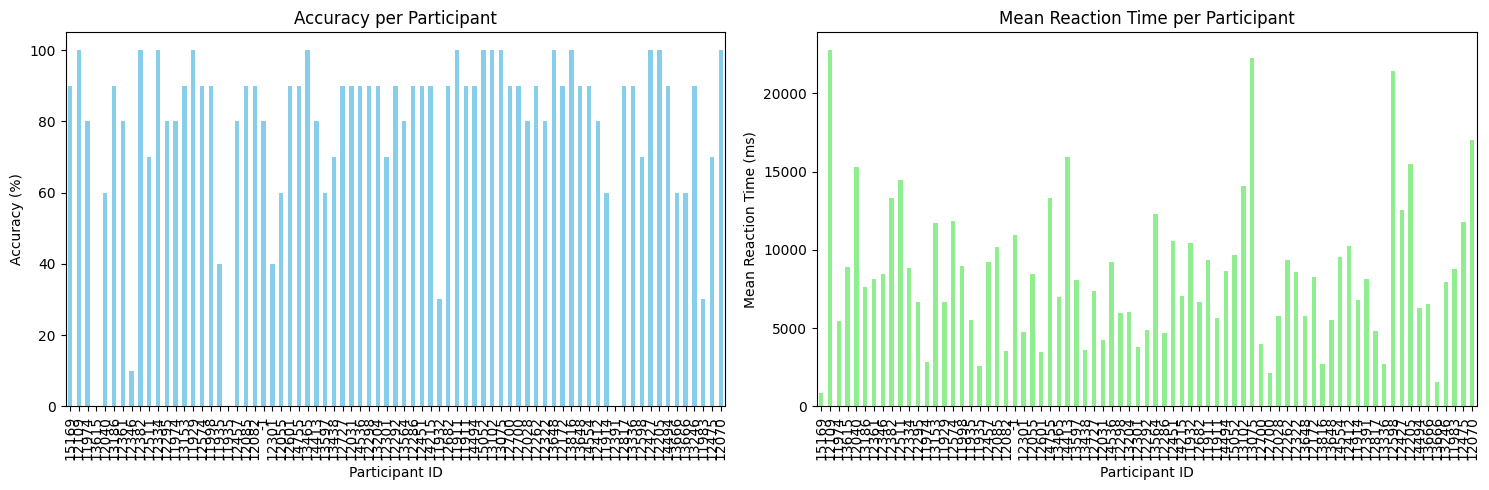

In [9]:
# Display training data summary
print("Training Data Summary:")
print(clean_dfs['training'])

# Create visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
clean_dfs['training']['accuracy'].plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Accuracy per Participant')
ax1.set_ylabel('Accuracy (%)')
ax1.set_xlabel('Participant ID')

# Reaction time plot
clean_dfs['training']['mean_rt'].plot(kind='bar', ax=ax2, color='lightgreen')
ax2.set_title('Mean Reaction Time per Participant')
ax2.set_ylabel('Mean Reaction Time (ms)')
ax2.set_xlabel('Participant ID')

plt.tight_layout()
plt.show()

In [10]:
 # Cell 1: Helper functions for image processing
def decode_base64_image(base64_string_or_list):
    if isinstance(base64_string_or_list, list):
        base64_string = base64_string_or_list[0]
    else:
        base64_string = base64_string_or_list
    
    try:
        img_data = base64.b64decode(base64_string.split(',')[1])
    except IndexError:
        img_data = base64.b64decode(base64_string)
    
    return Image.open(BytesIO(img_data))

def create_composite_image(images):
    if not images:
        return np.zeros((16, 16), dtype=np.uint8)
    np_images = [np.array(img.convert('L').resize((16, 16))) for img in images]
    mean_image = np.mean(np.stack(np_images), axis=0)
    return mean_image.astype(np.uint8)

# Cell 3: Visualization function
def plot_participant_sessions(participant_data, participant_id):
    for session, session_data in participant_data.items():
        generations = sorted(session_data.keys())
        n_gens = len(generations)
        
        if n_gens == 0:
            print(f"No generations found for Participant {participant_id}, Session {session}")
            continue
            
        fig, axes = plt.subplots(1, n_gens, figsize=(3*n_gens, 3))
        if n_gens == 1:
            axes = [axes]
        
        for idx, gen in enumerate(generations):
            gen_images = []
            for img_base64 in session_data[gen]['selected']:
                try:
                    img = decode_base64_image(img_base64)
                    gen_images.append(img)
                except Exception as e:
                    print(f"Error processing image for Participant {participant_id}, Session {session}, Generation {gen}: {str(e)}")
                    continue
                    
            if gen_images:
                composite = create_composite_image(gen_images)
                axes[idx].imshow(composite, cmap='gray')
                axes[idx].axis('off')
                axes[idx].set_title(f'Gen {gen}')
        
        plt.suptitle(f'Participant {participant_id} - Session {session}')
        plt.tight_layout()
        plt.show()
        plt.close()

Clean Evolution Data Summary:

Participant 4737:
  Session 1: 7 generations
  Available generations: [0, 1, 2, 3, 4, 5, 6]
  Session 2: 7 generations
  Available generations: [0, 1, 2, 3, 4, 5, 6]

Participant 4739:
  Session 1: 7 generations
  Available generations: [0, 1, 2, 3, 4, 5, 6]
  Session 2: 7 generations
  Available generations: [0, 1, 2, 3, 4, 5, 6]

Participant 15169:
  Session 1: 7 generations
  Available generations: [0, 1, 2, 3, 4, 5, 6]
  Session 2: 7 generations
  Available generations: [0, 1, 2, 3, 4, 5, 6]

Participant 12109:
  Session 1: 7 generations
  Available generations: [0, 1, 2, 3, 4, 5, 6]
  Session 2: 7 generations
  Available generations: [0, 1, 2, 3, 4, 5, 6]

Participant 11974:
  Session 1: 7 generations
  Available generations: [0, 1, 2, 3, 4, 5, 6]
  Session 2: 7 generations
  Available generations: [0, 1, 2, 3, 4, 5, 6]

Participant 13615:
  Session 1: 7 generations
  Available generations: [0, 1, 2, 3, 4, 5, 6]
  Session 2: 7 generations
  Available

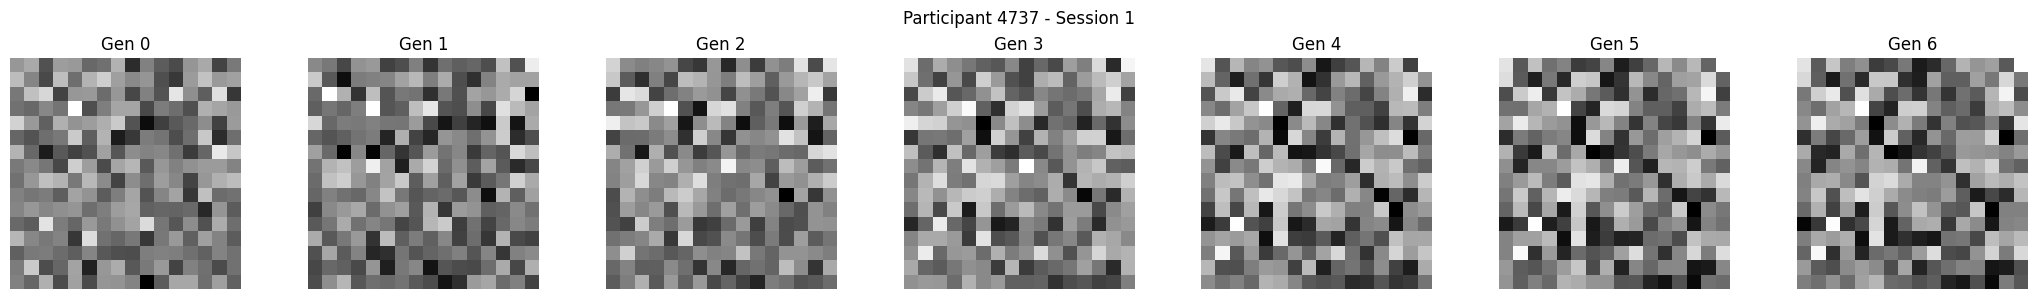

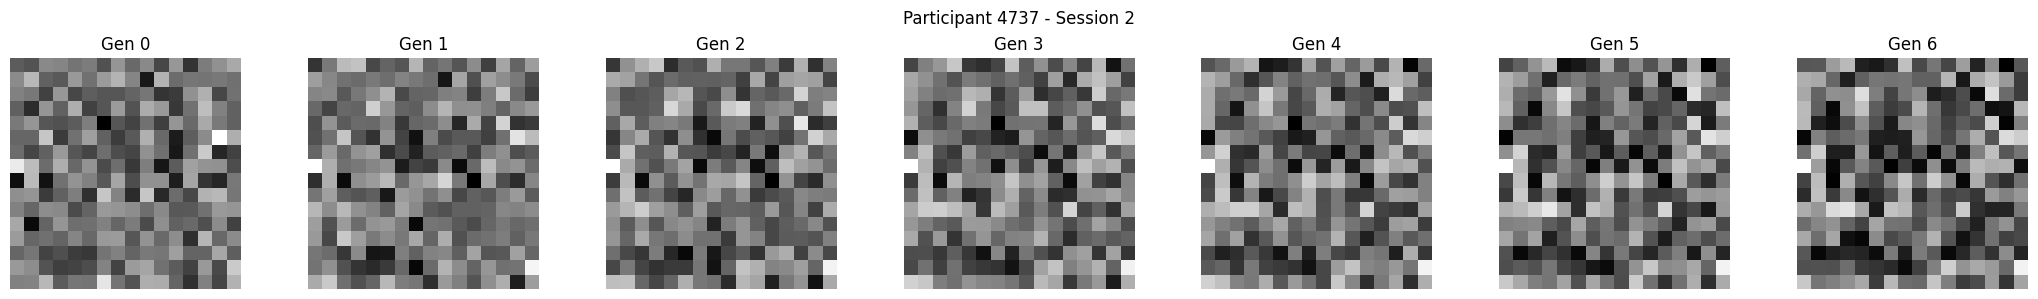

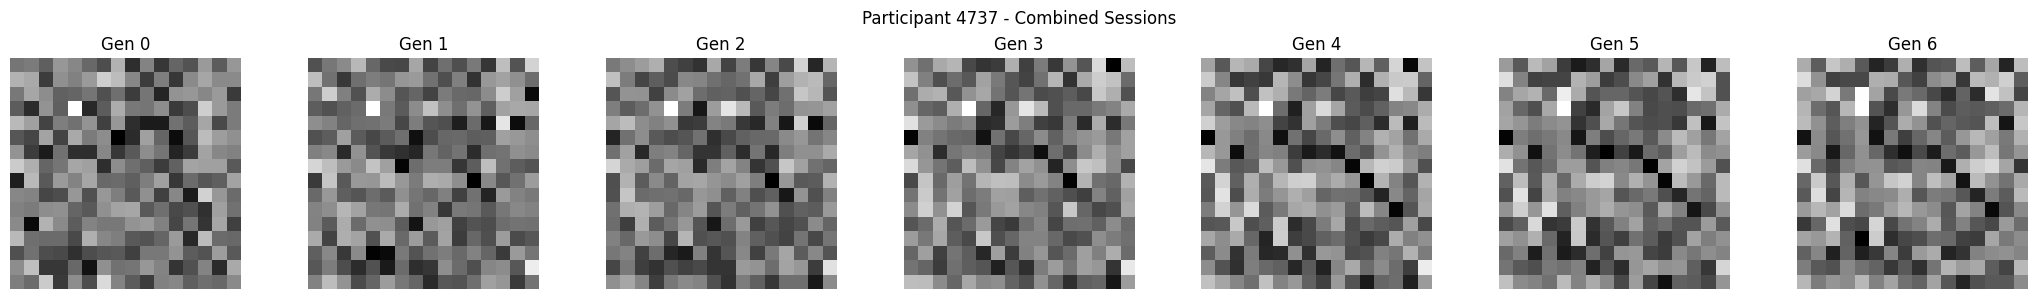


Visualizing Participant 4739


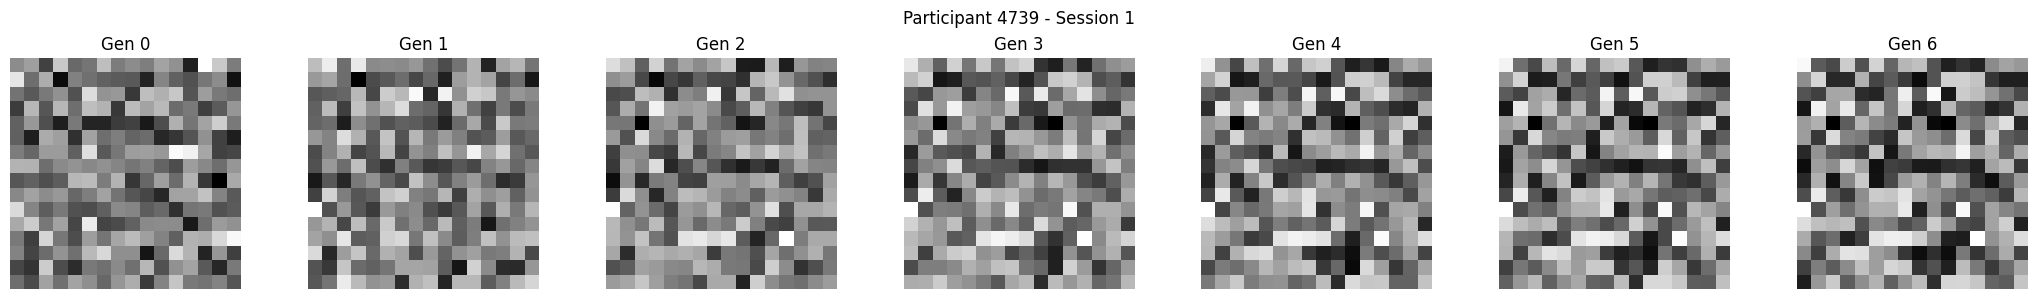

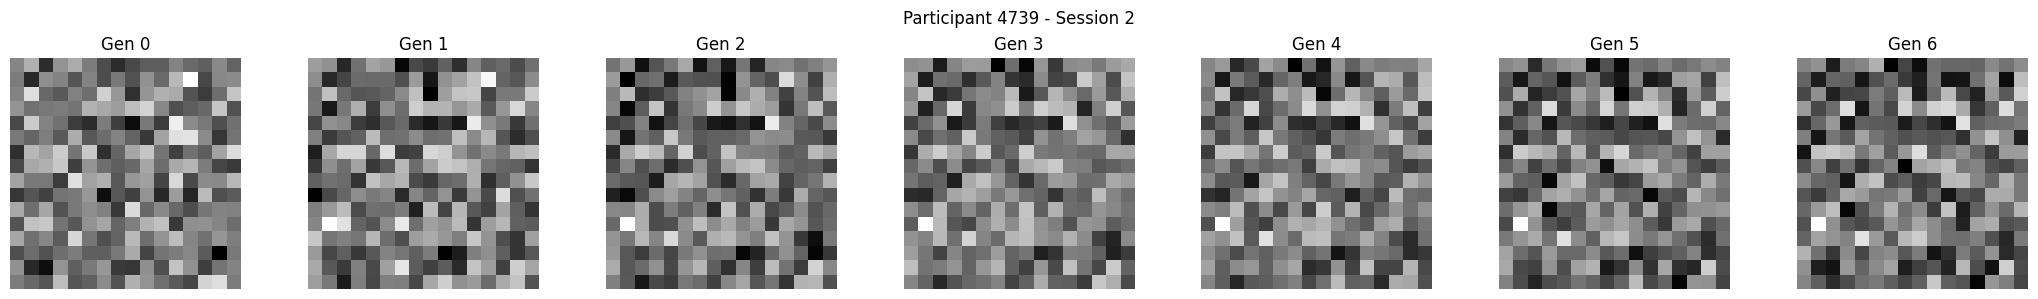

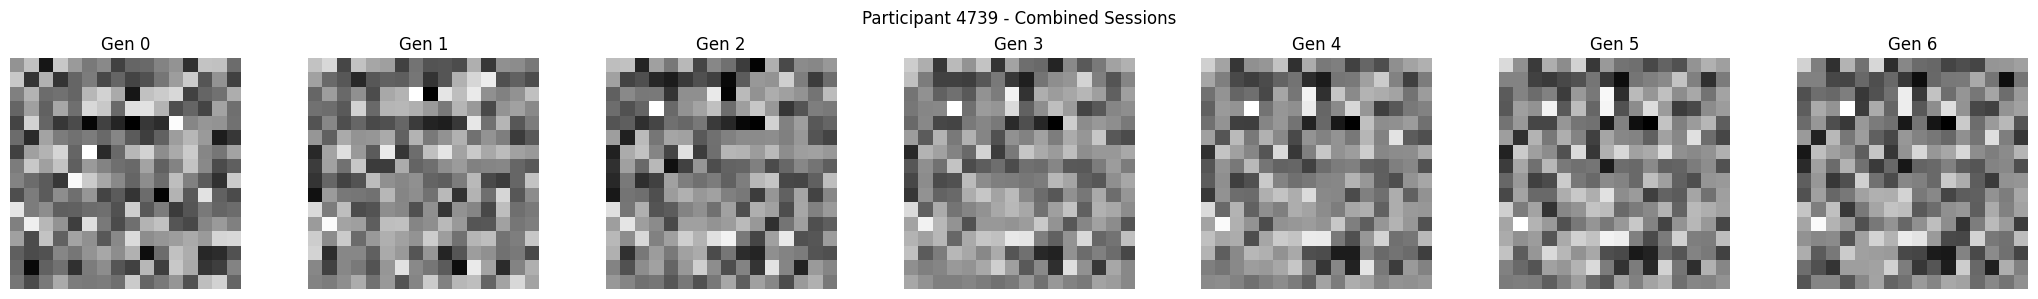


Visualizing Participant 15169


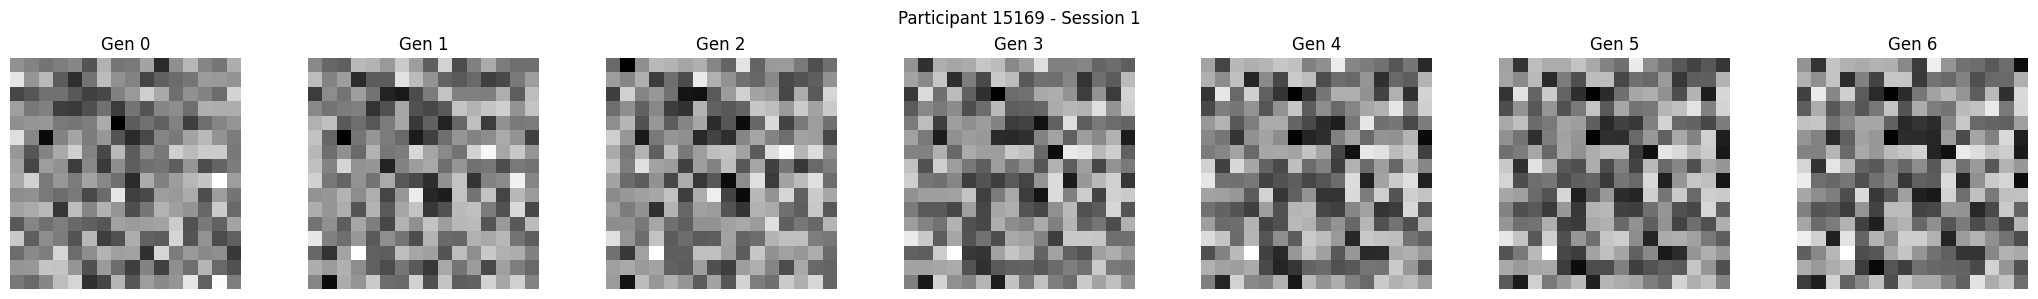

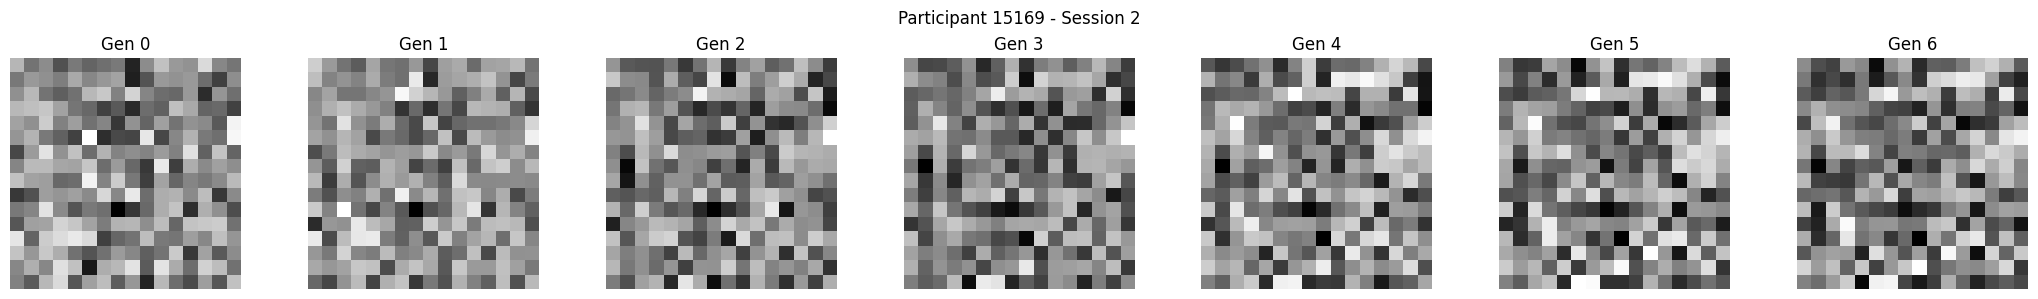

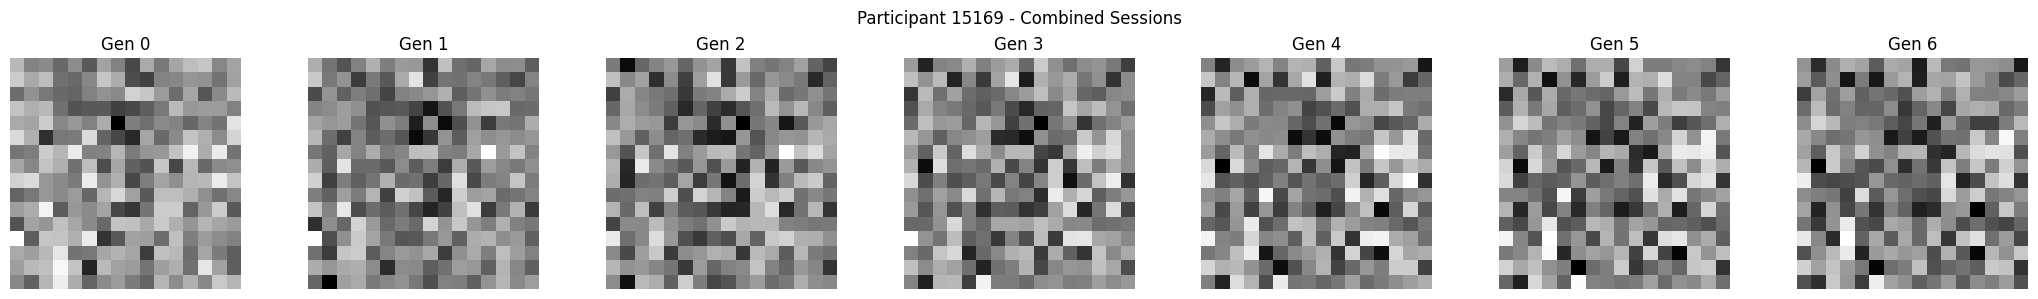


Visualizing Participant 12109


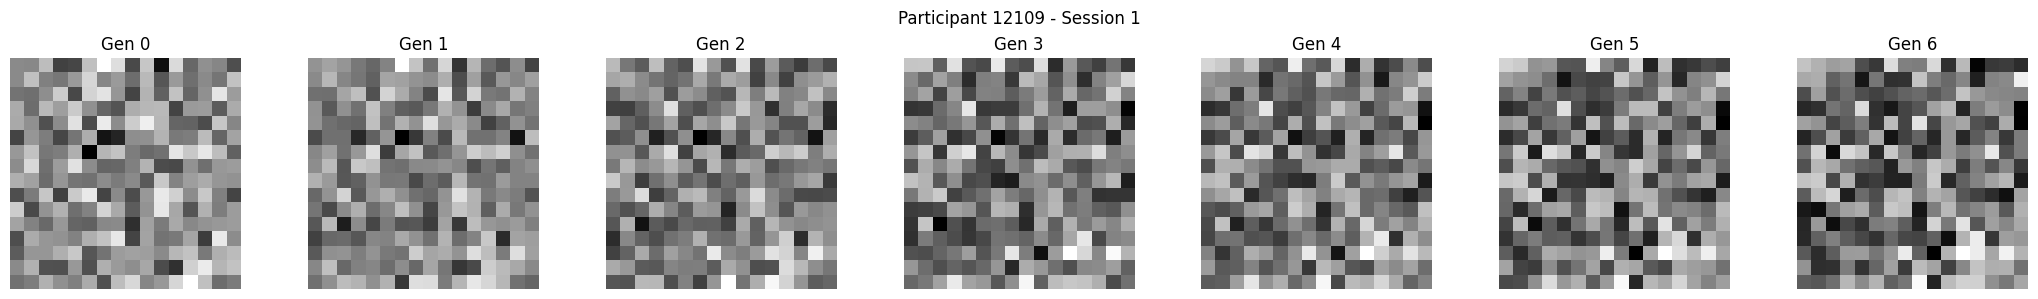

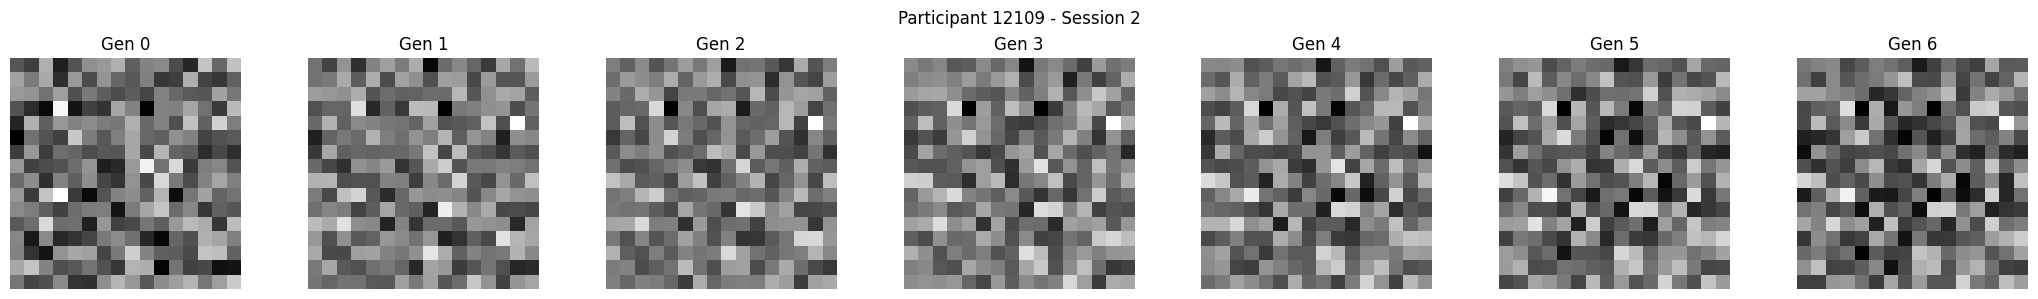

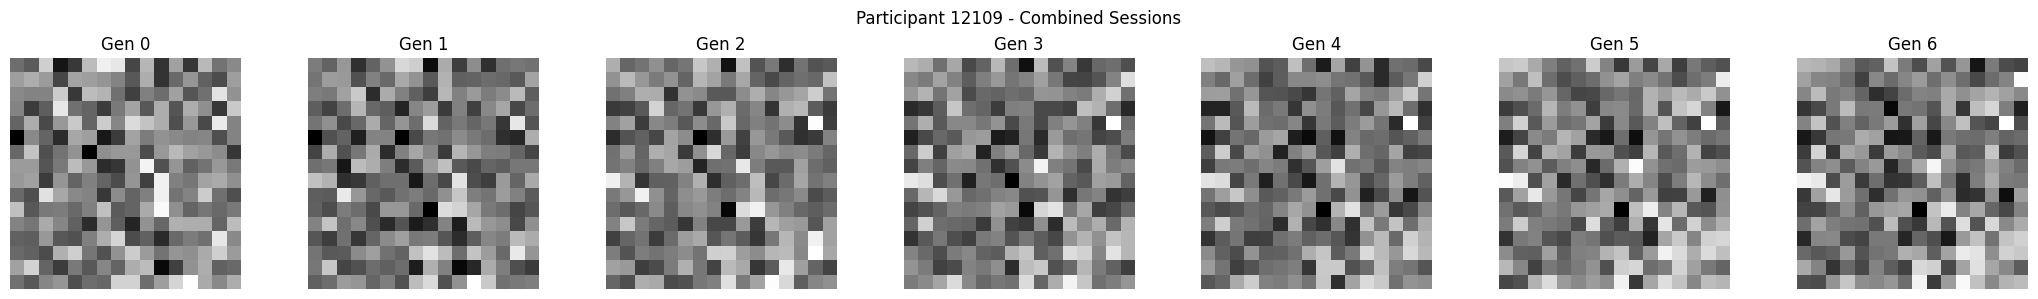


Visualizing Participant 11974


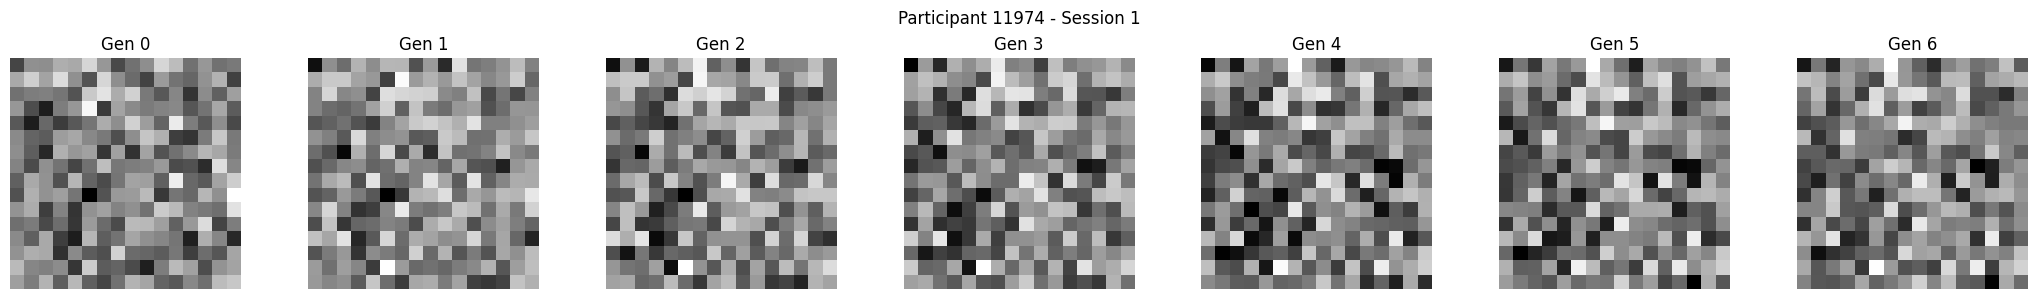

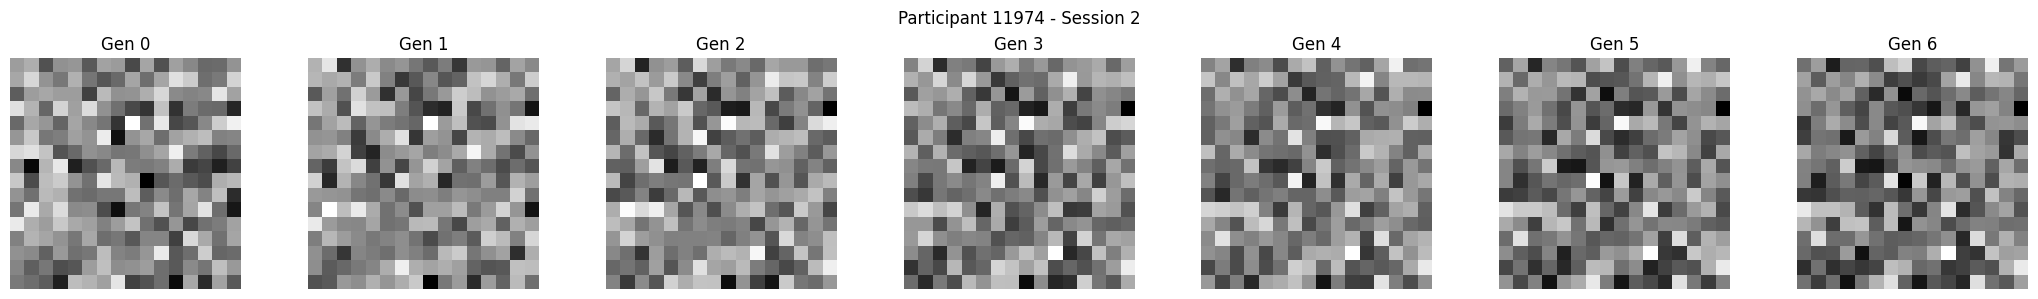

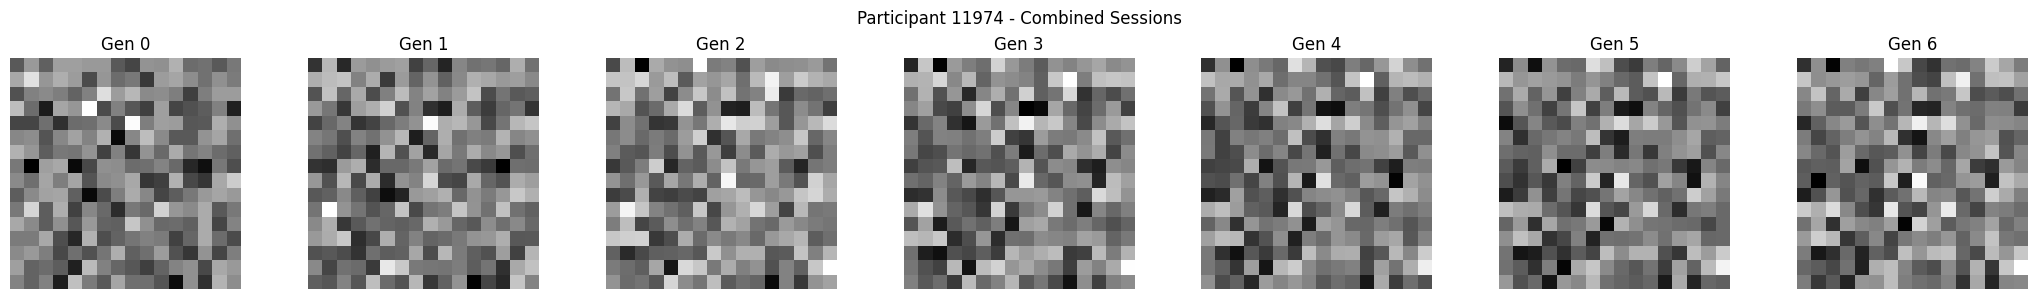


Visualizing Participant 13615


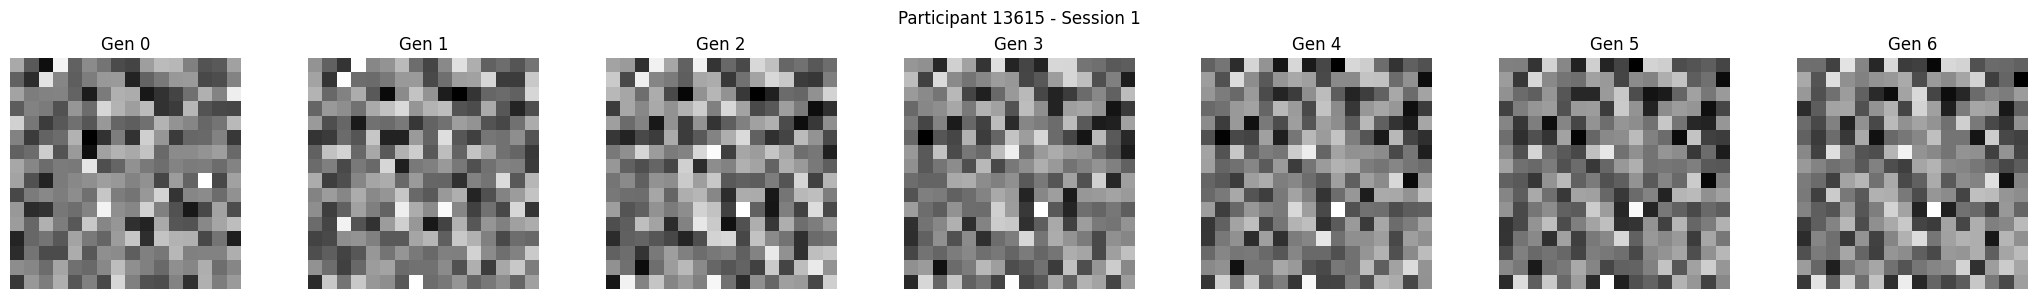

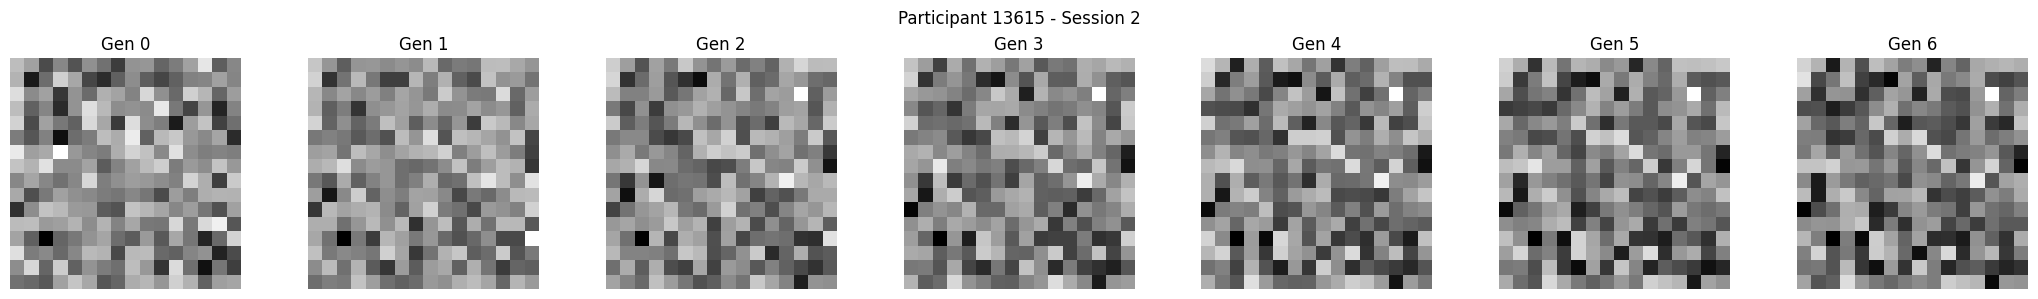

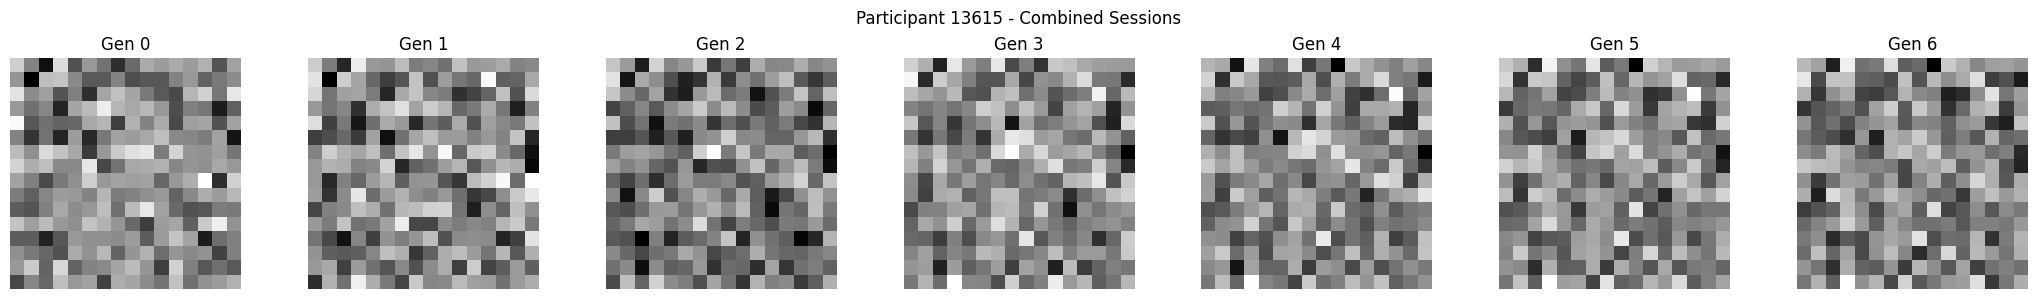


Visualizing Participant 12040


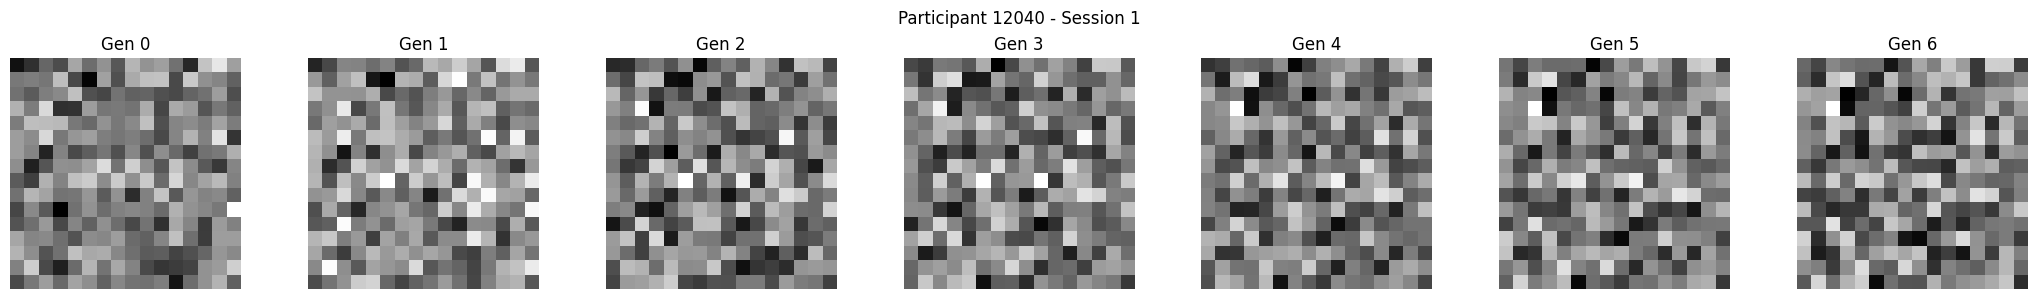

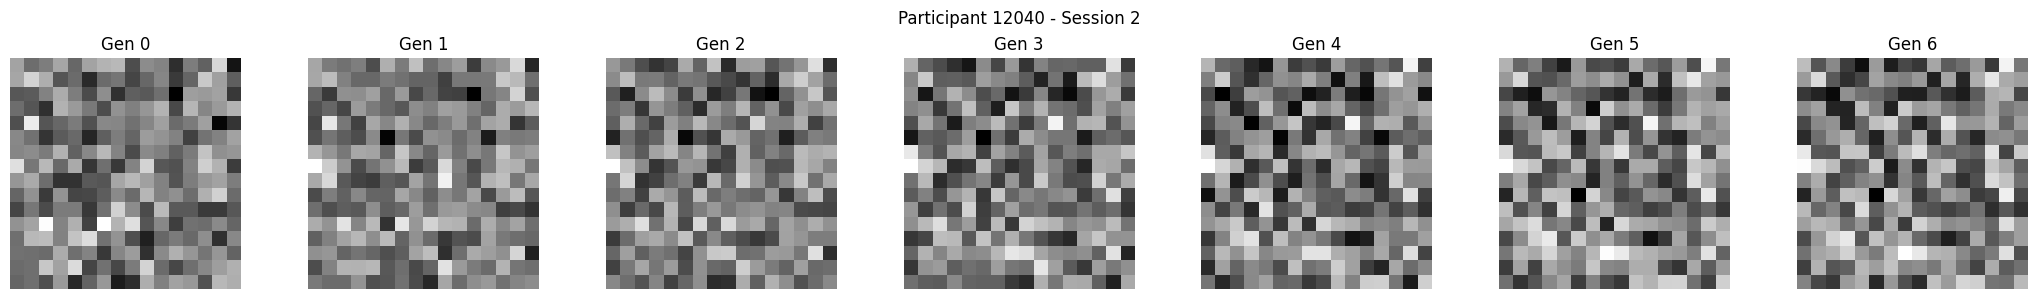

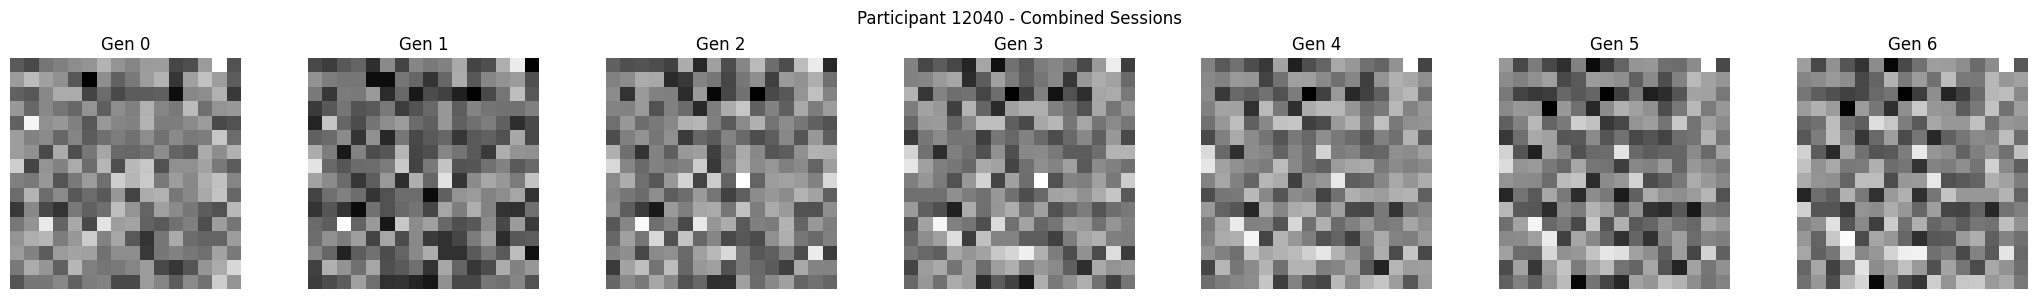


Visualizing Participant 13186


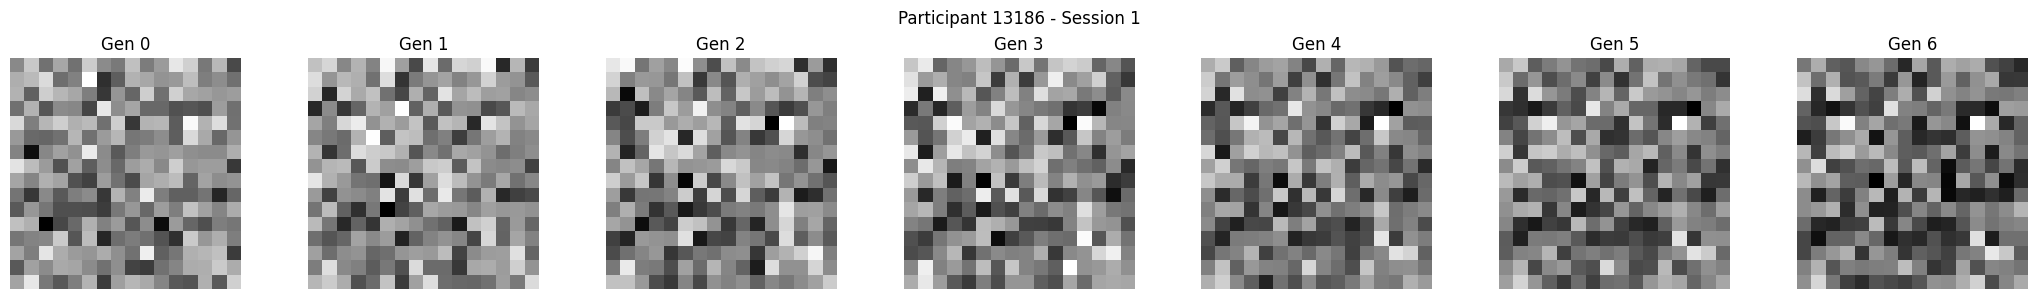

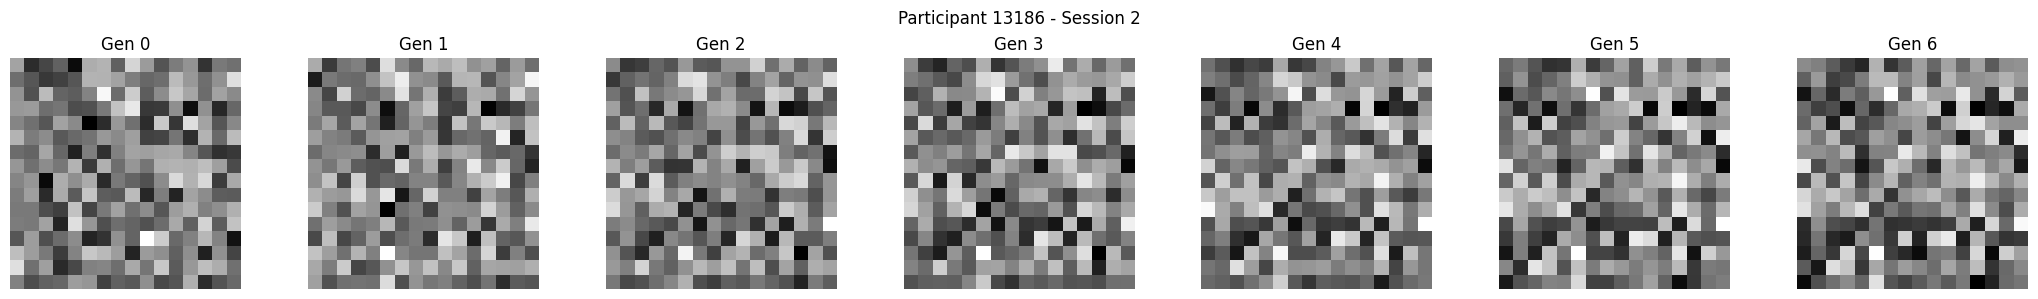

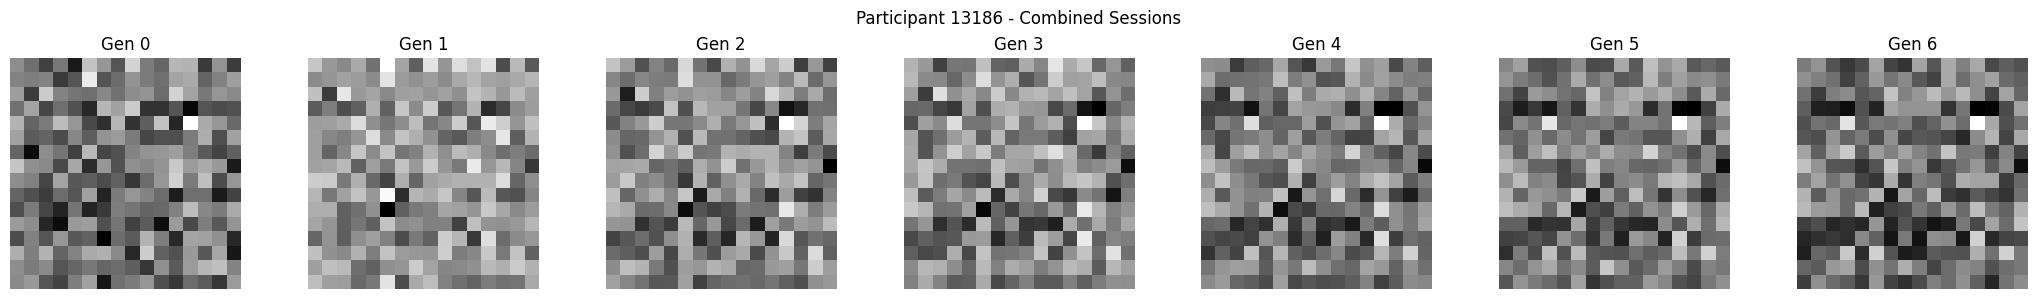


Visualizing Participant 12361


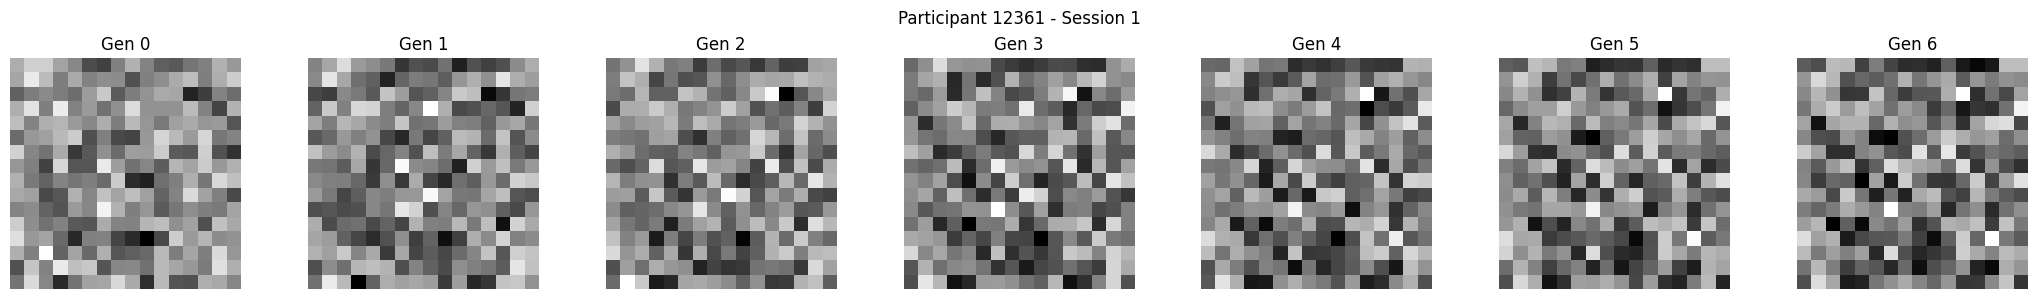

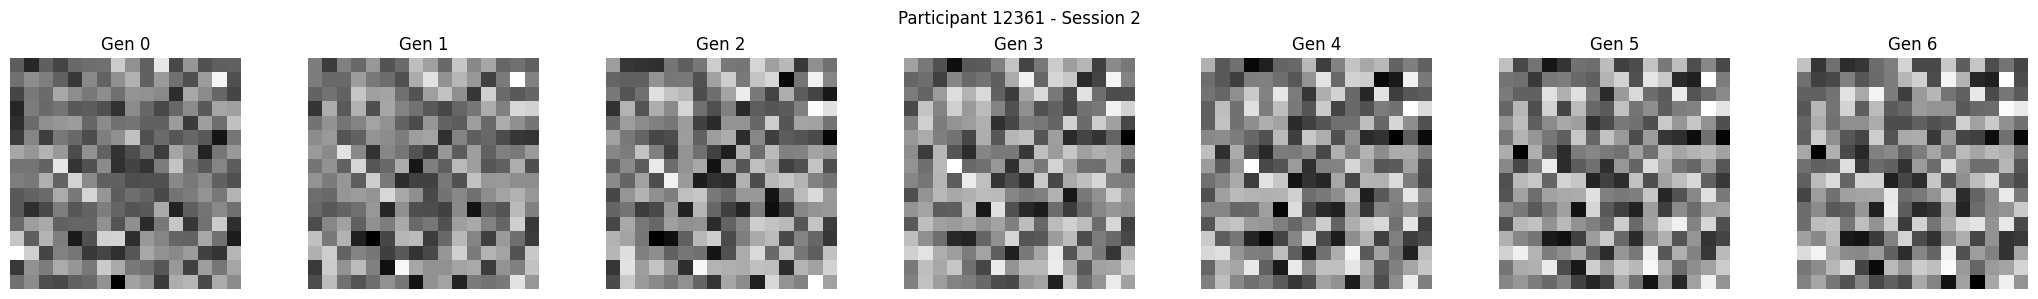

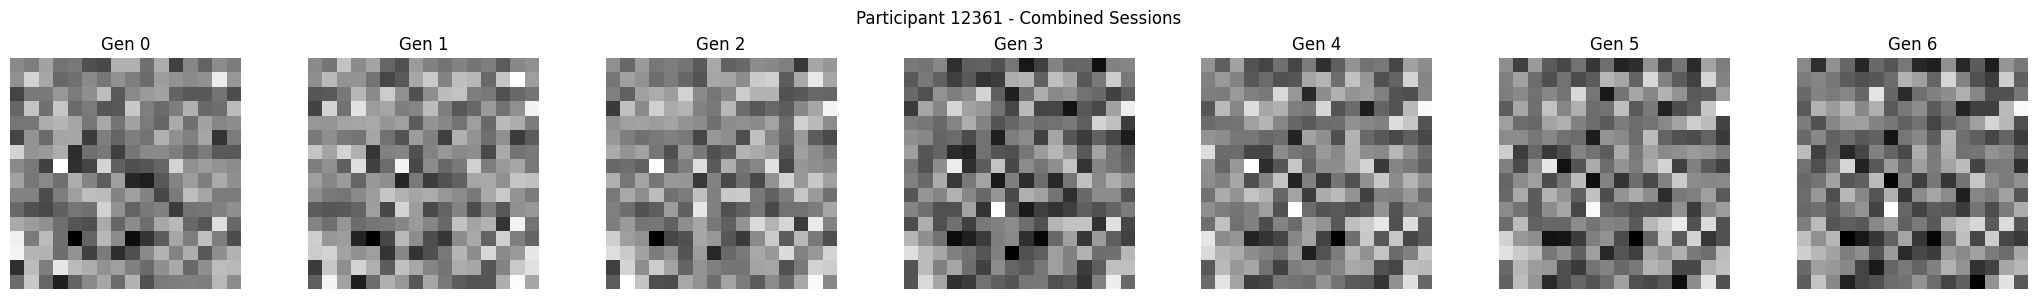


Visualizing Participant 12346


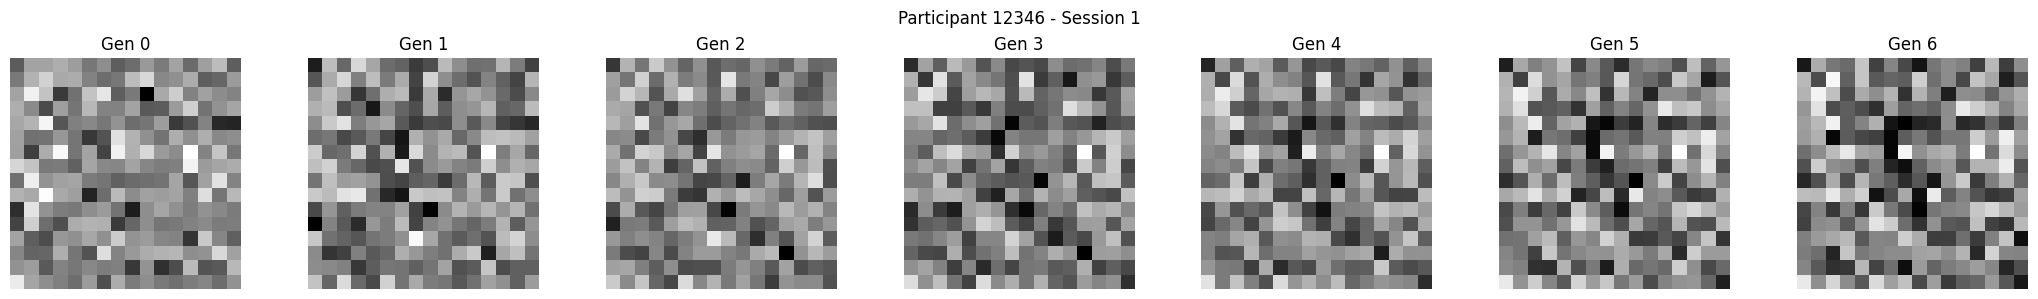

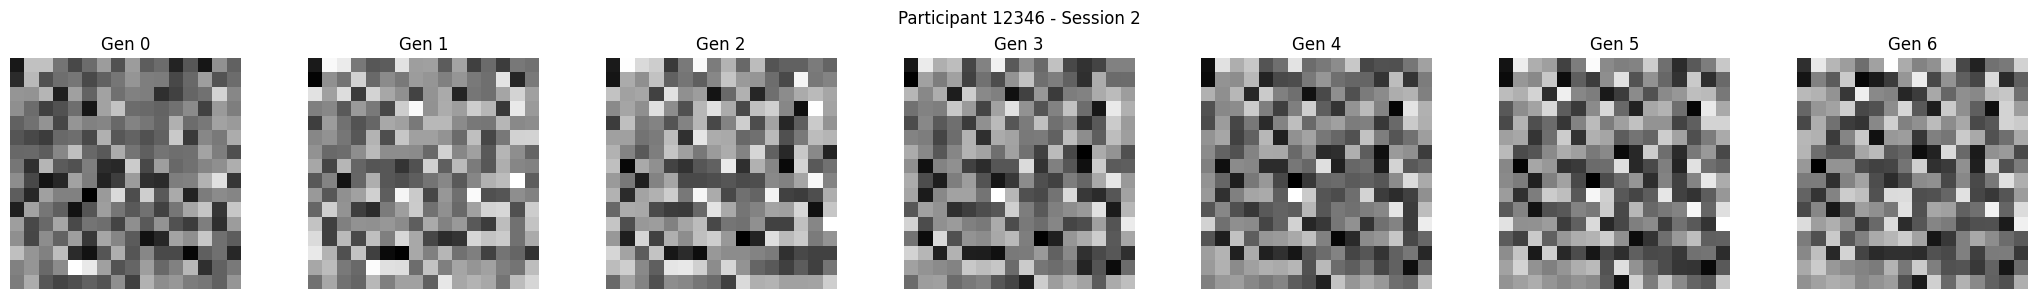

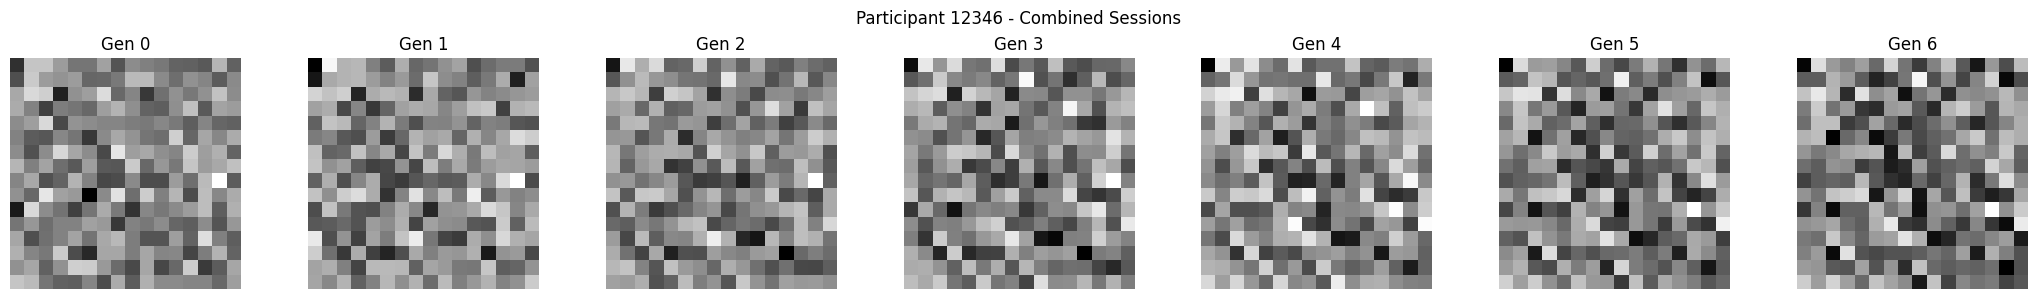


Visualizing Participant 12382


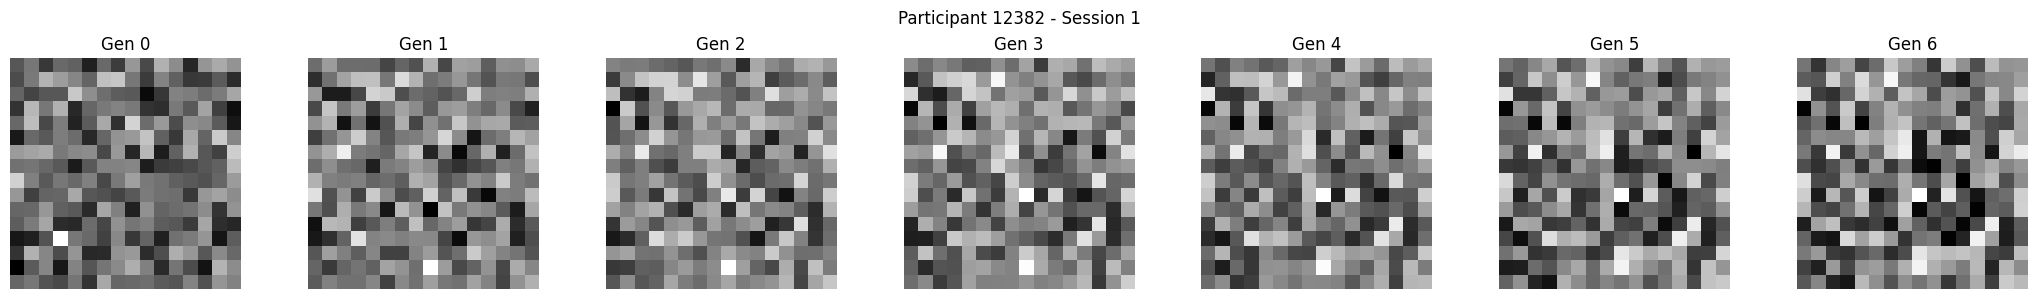

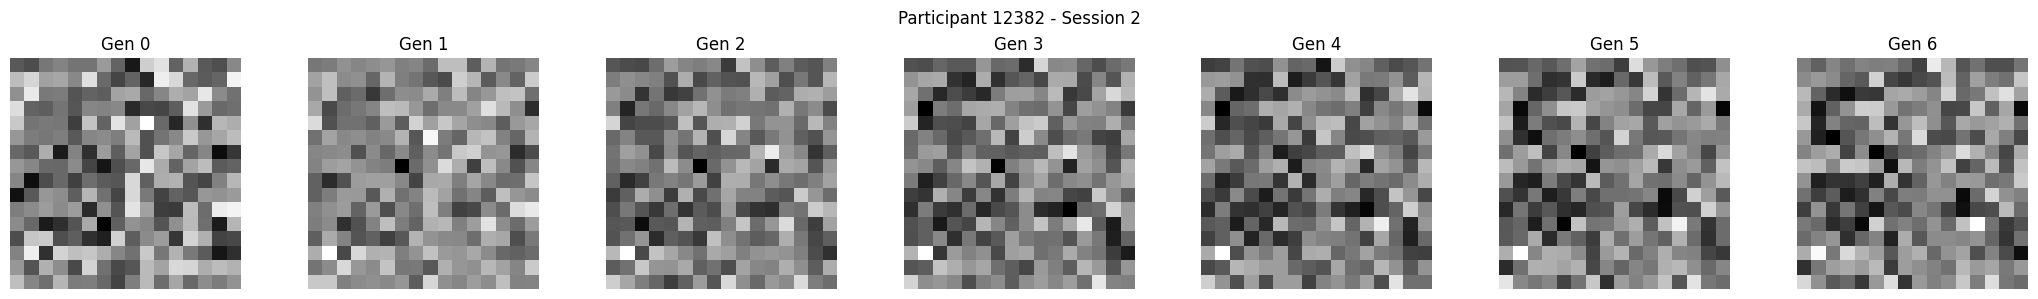

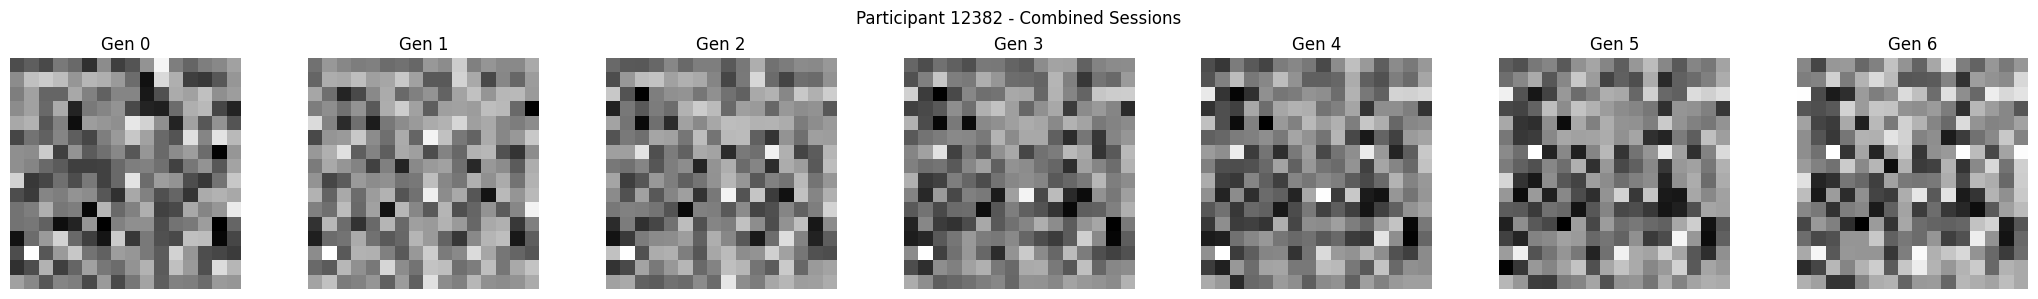


Visualizing Participant 12511


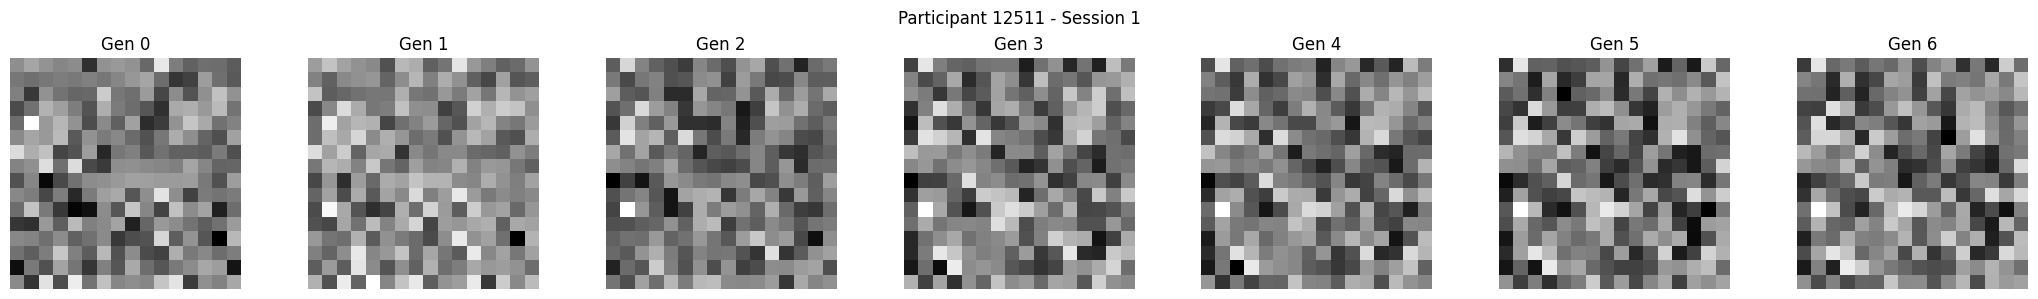

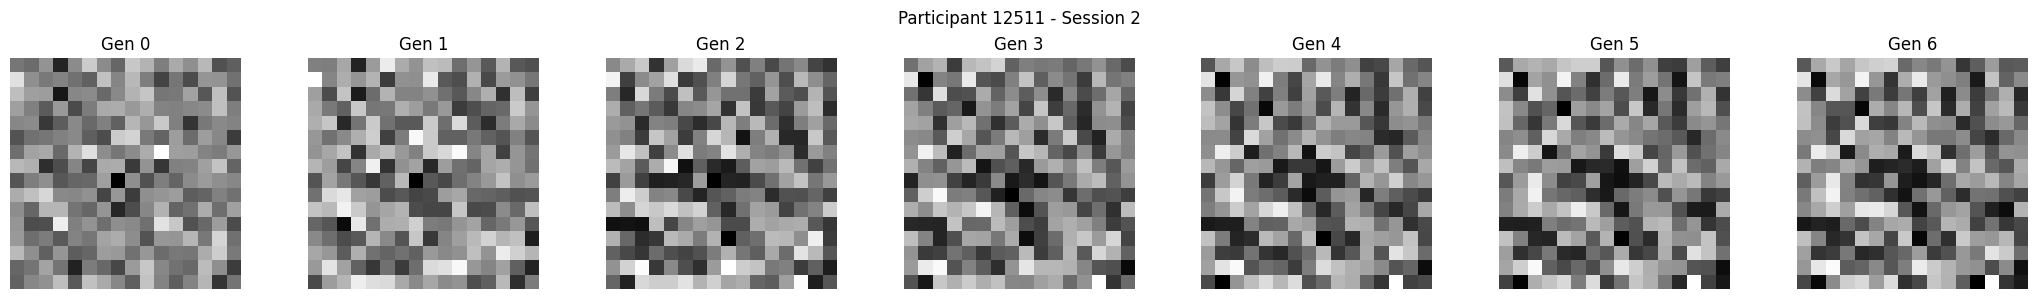

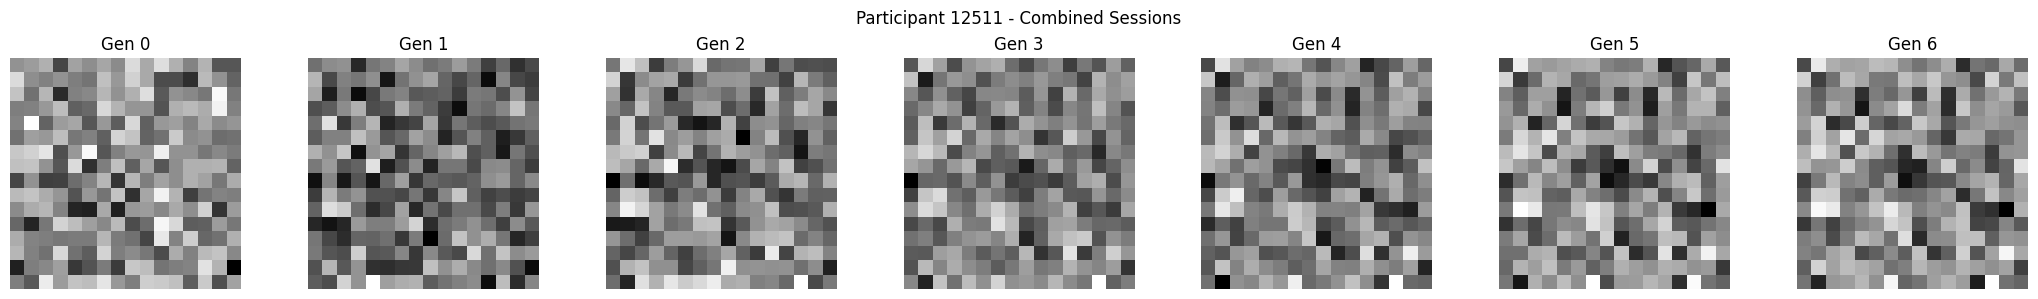


Visualizing Participant 12334


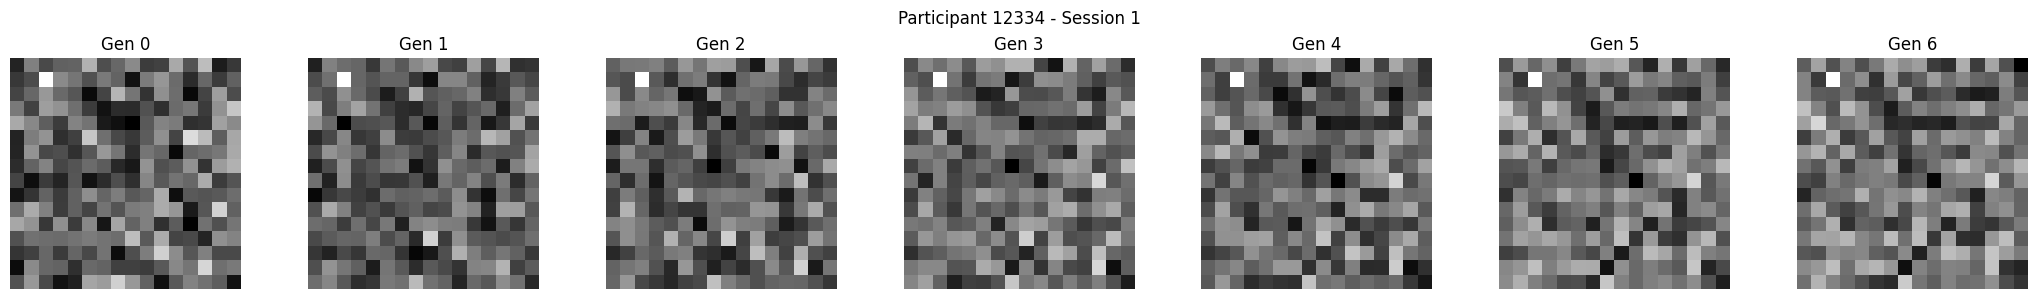

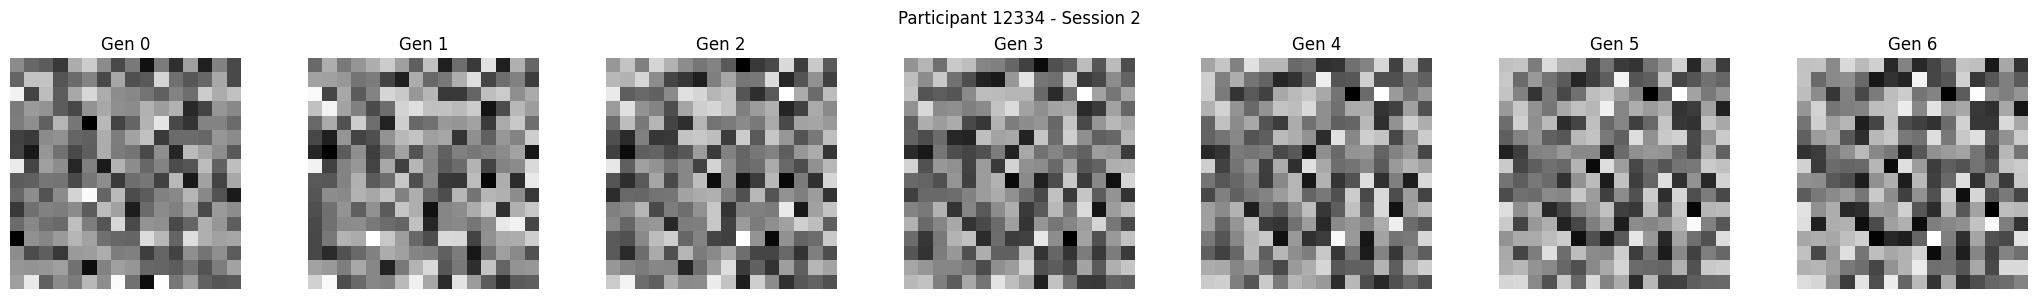

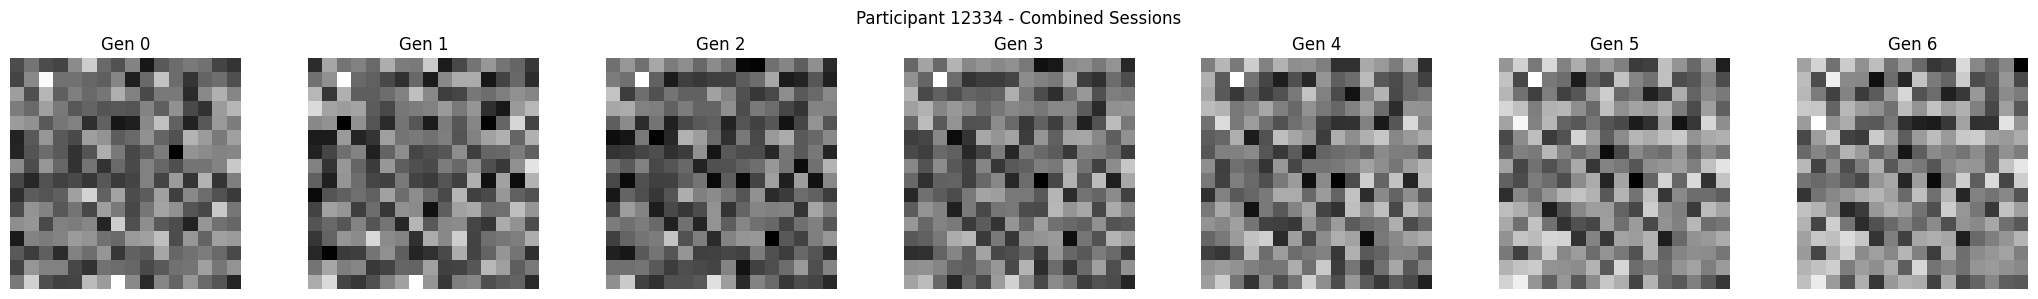


Visualizing Participant 12295


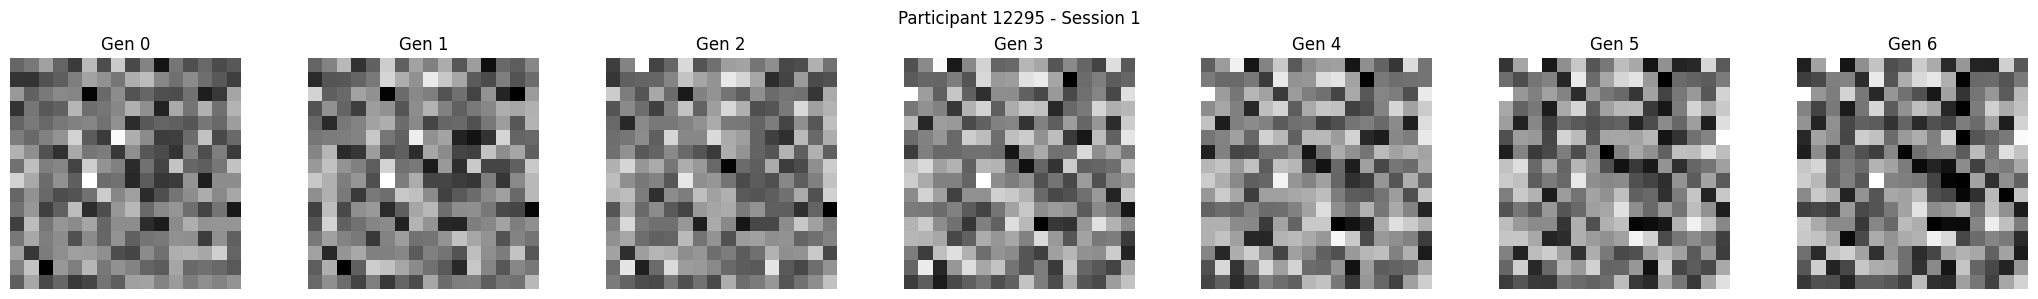

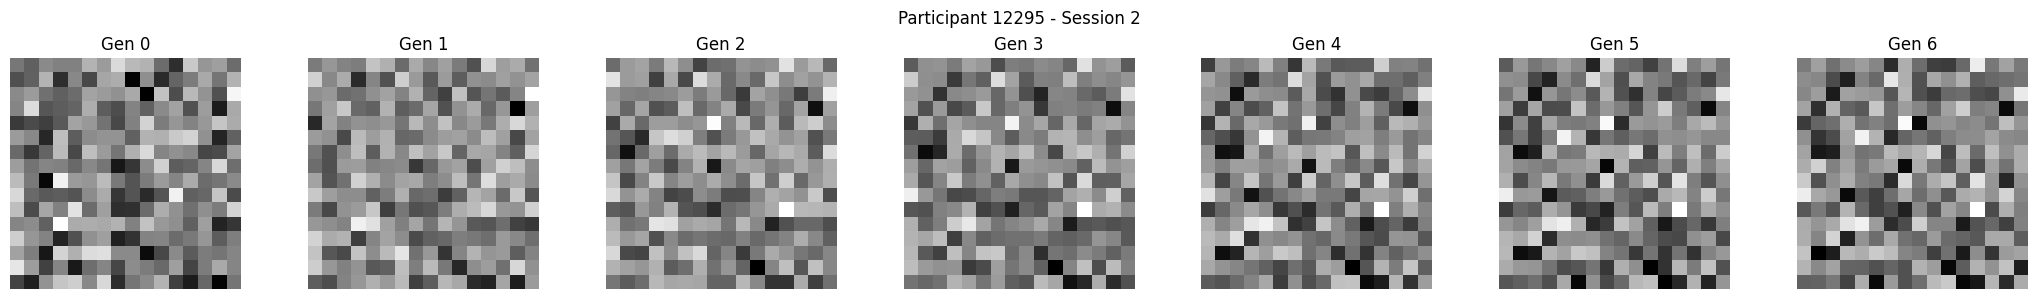

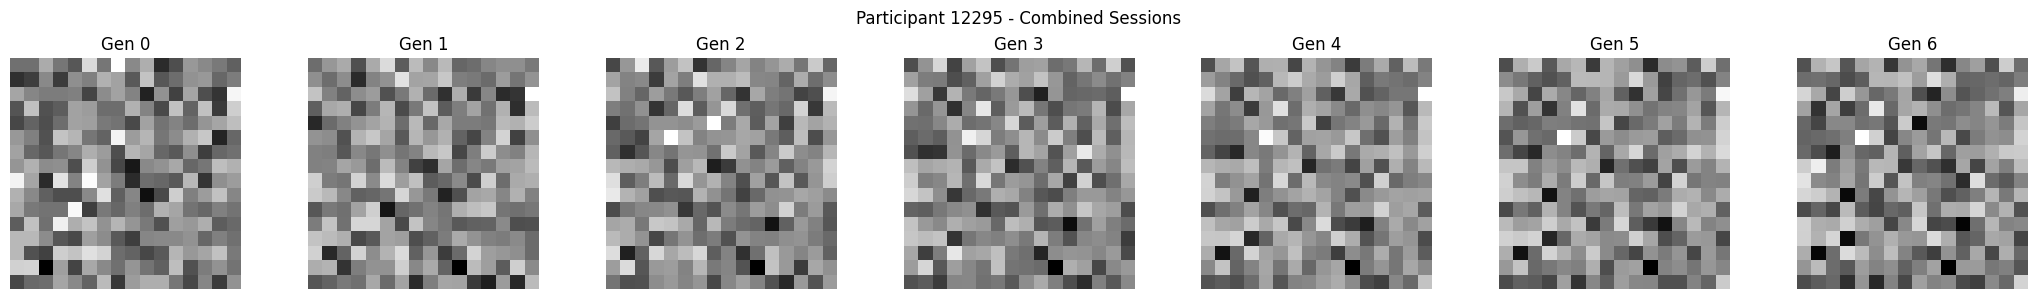


Visualizing Participant 13153


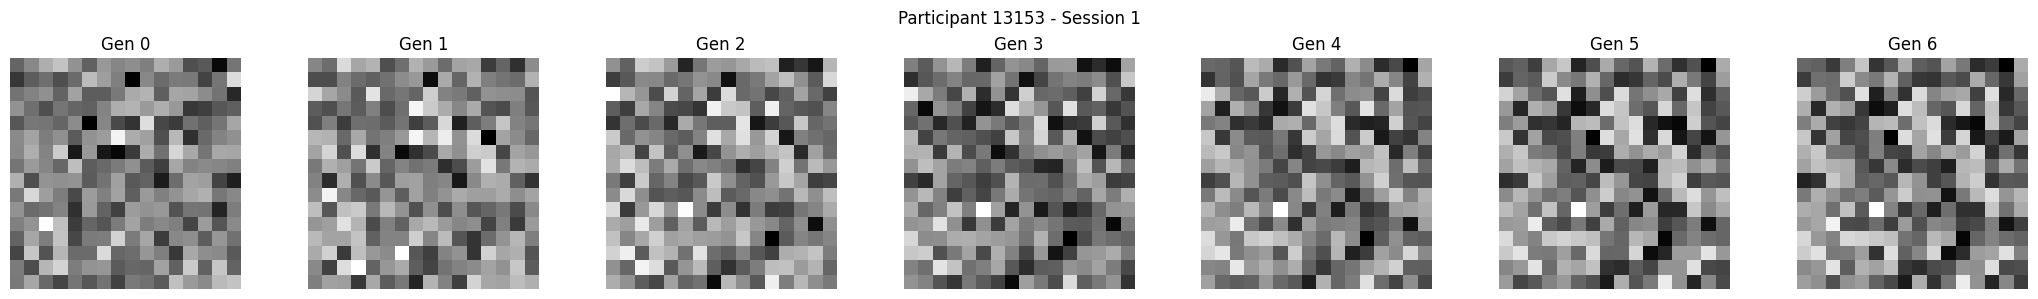

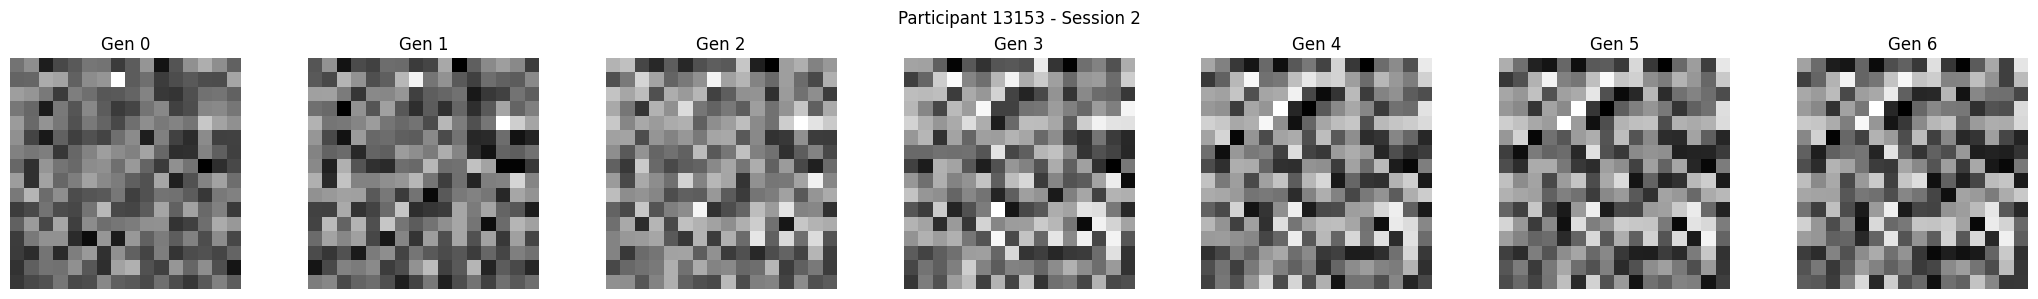

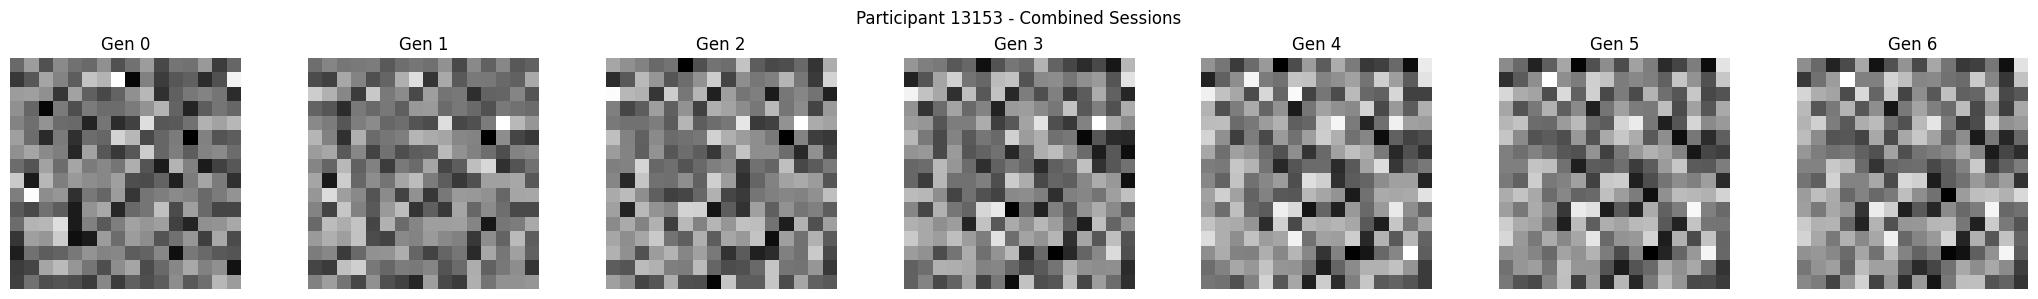


Visualizing Participant 11929


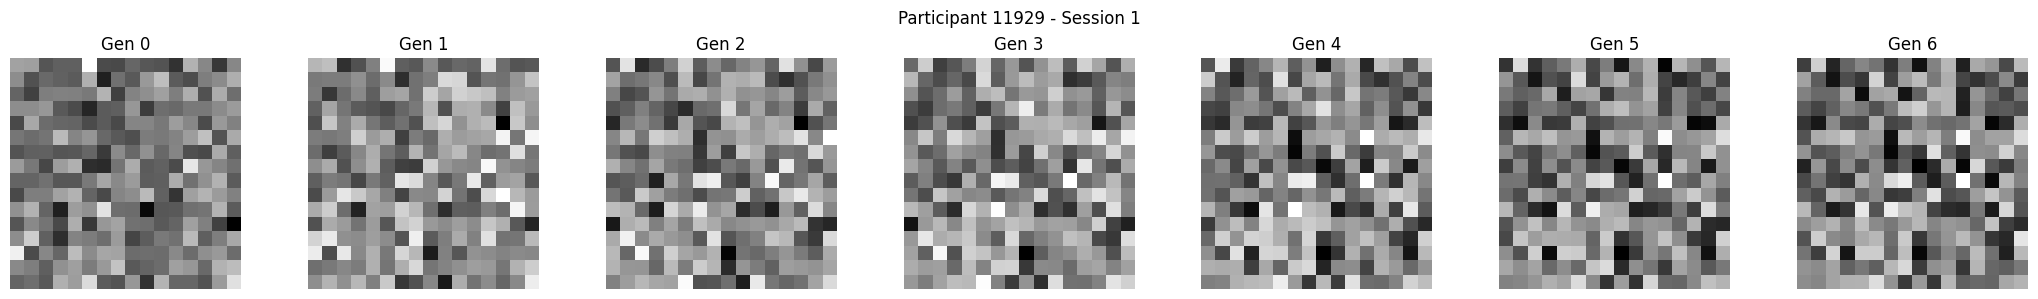

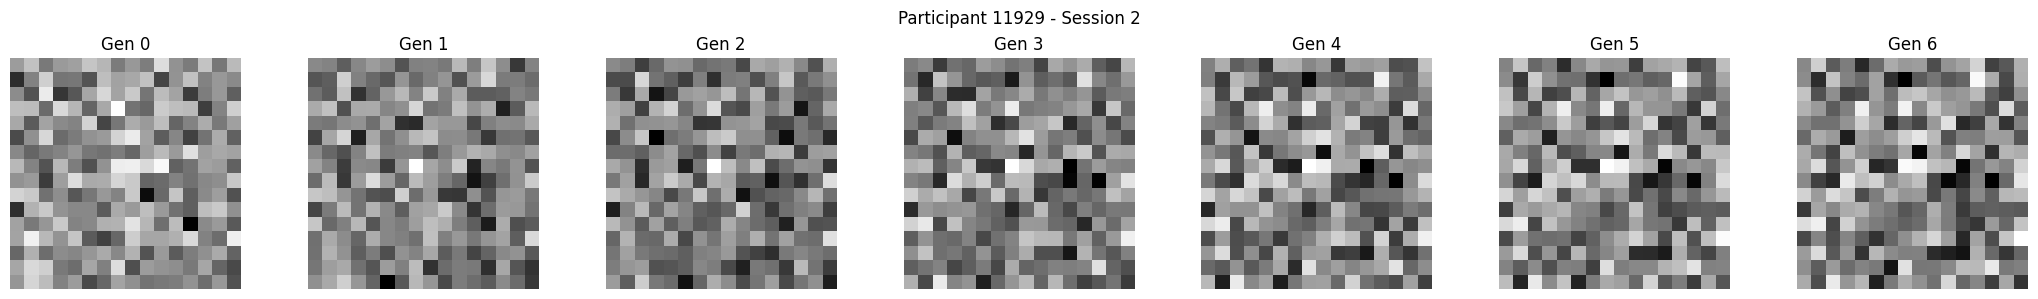

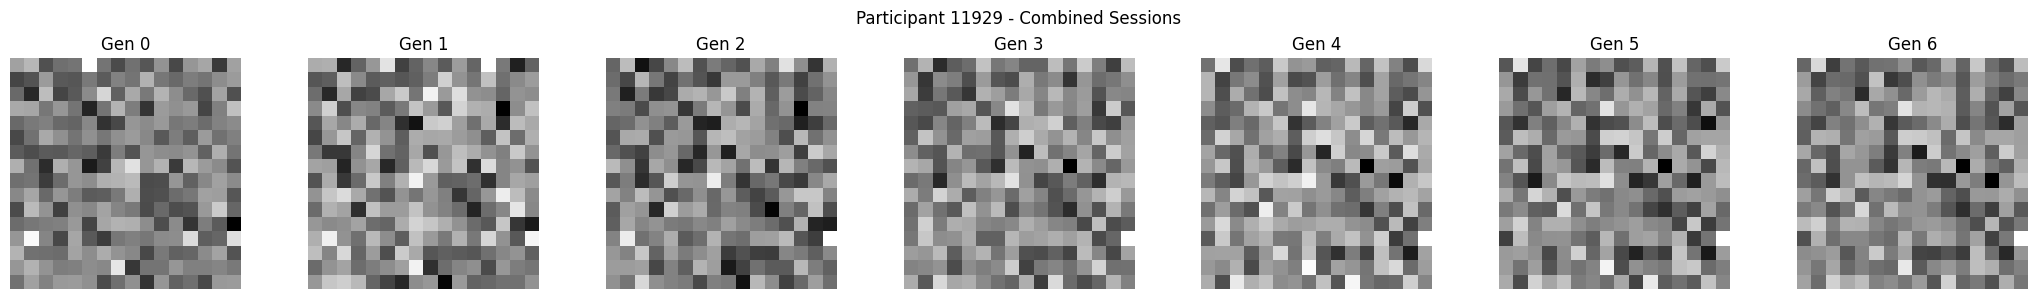


Visualizing Participant 12574


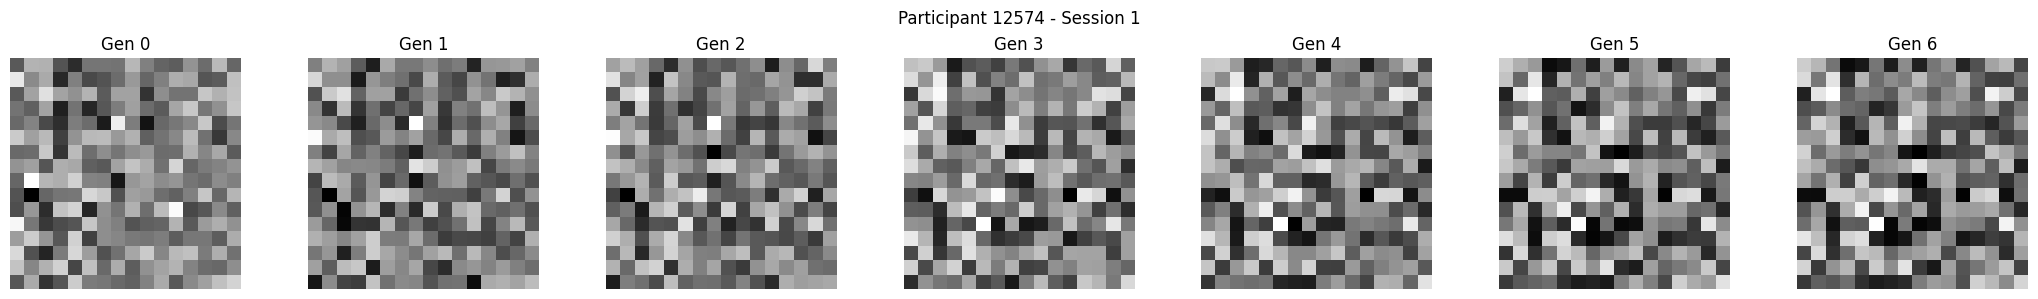

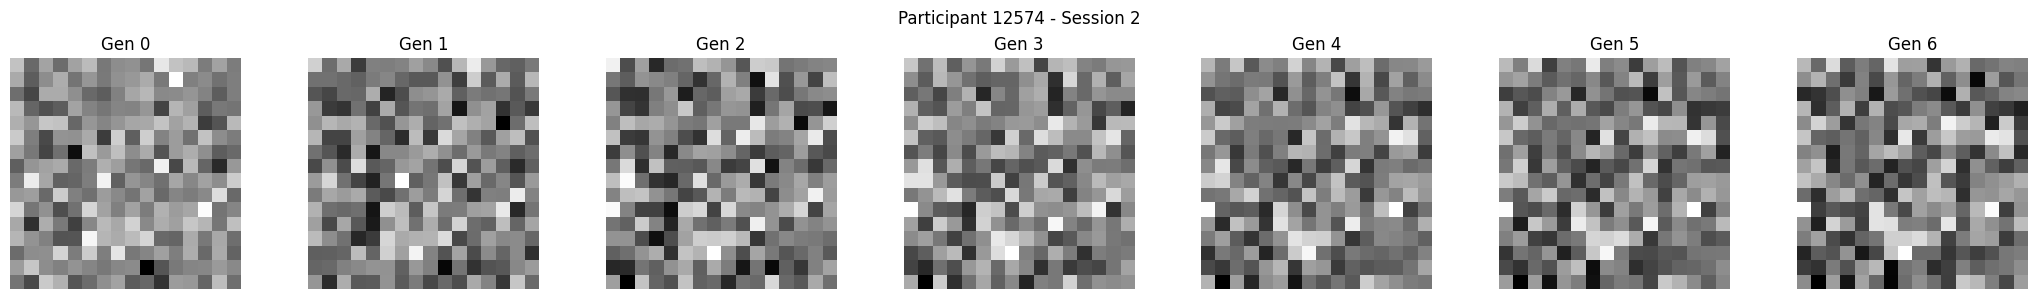

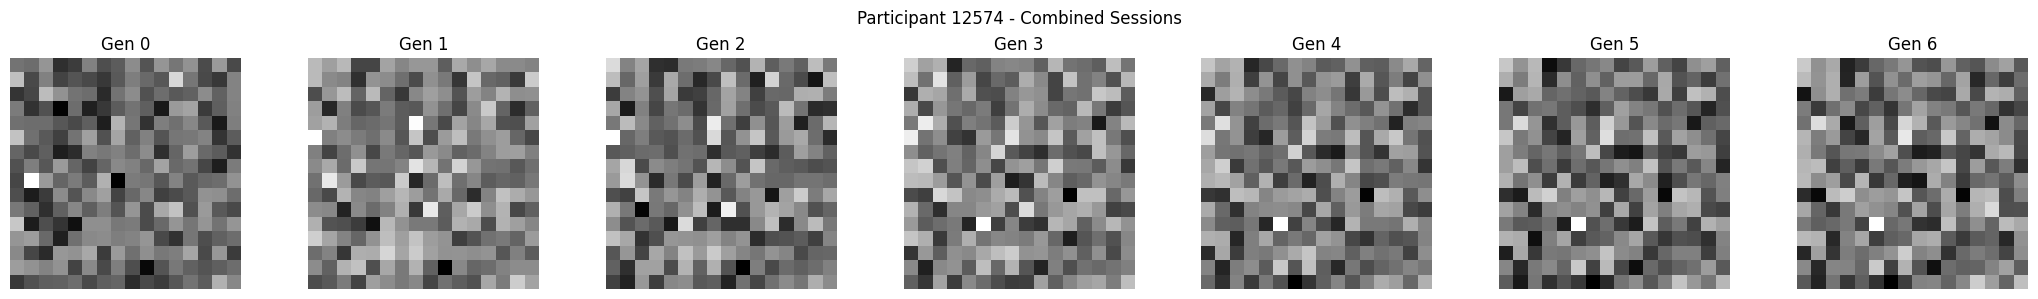


Visualizing Participant 11998


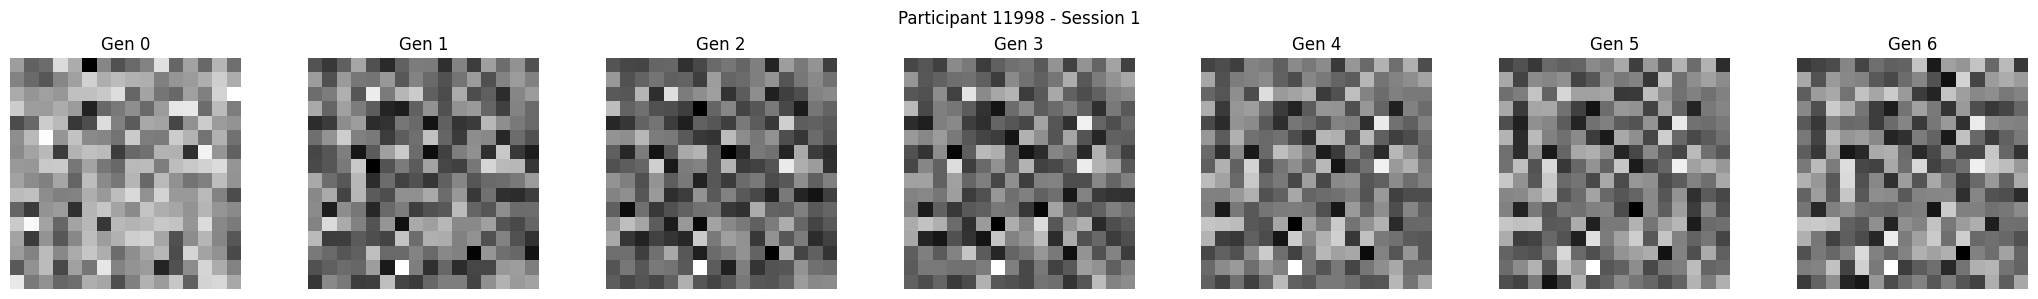

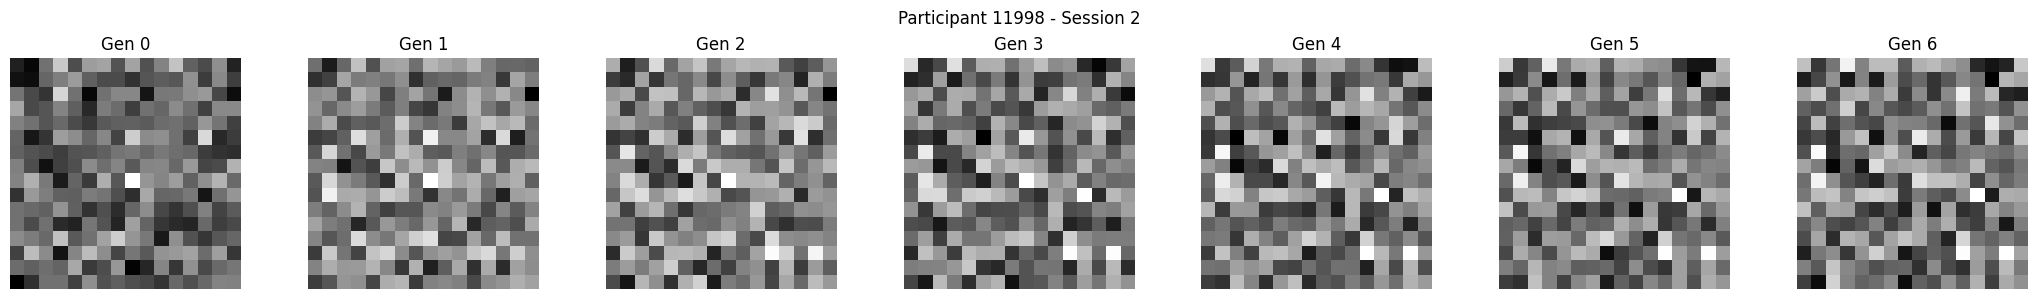

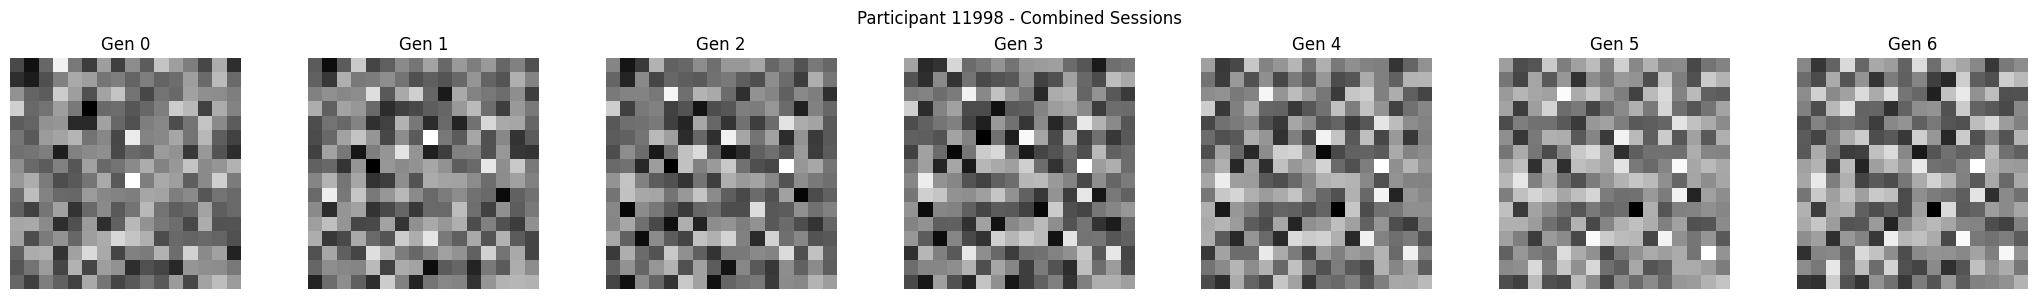


Visualizing Participant 11935


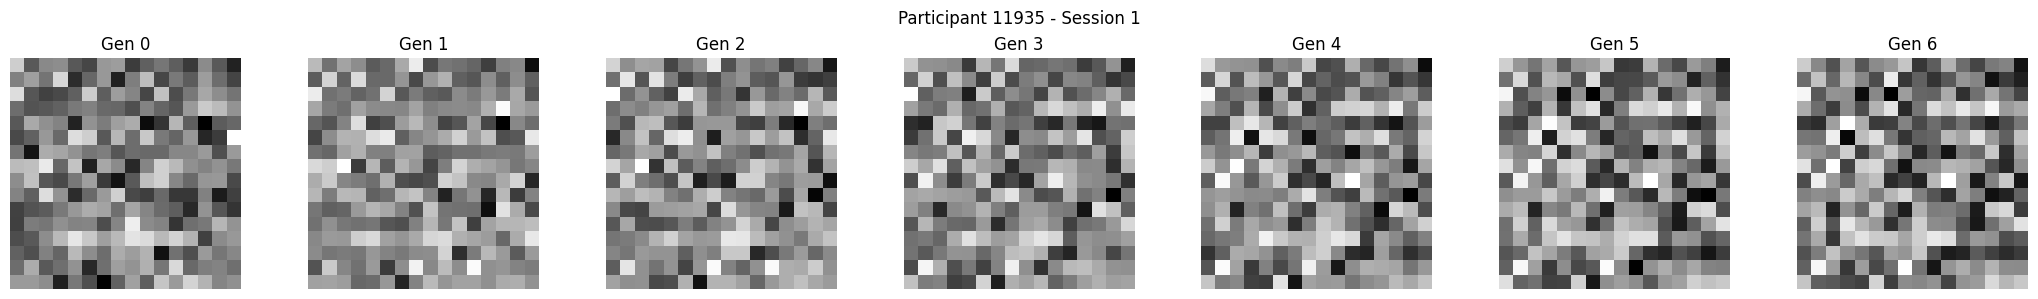

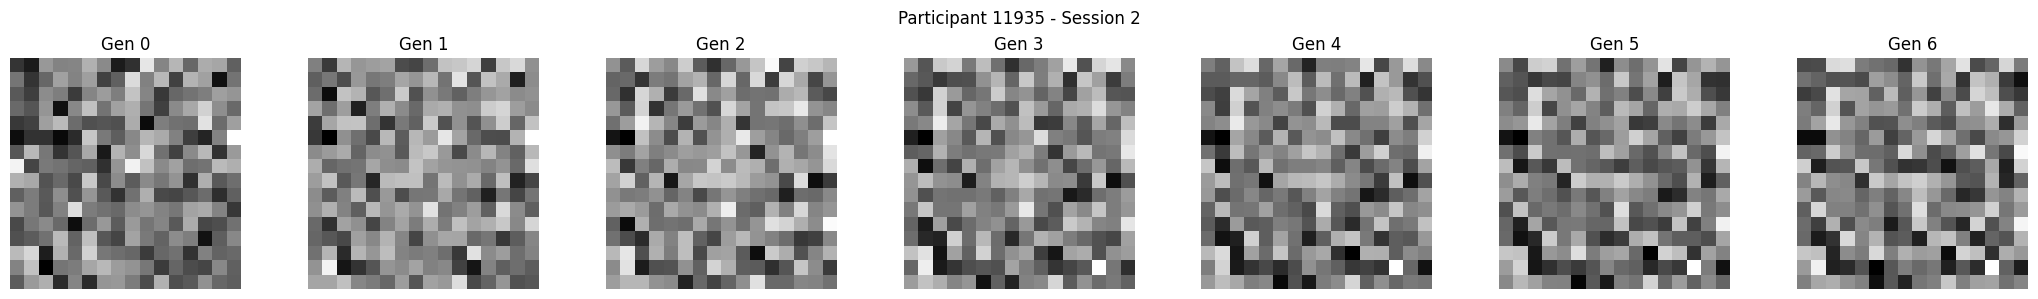

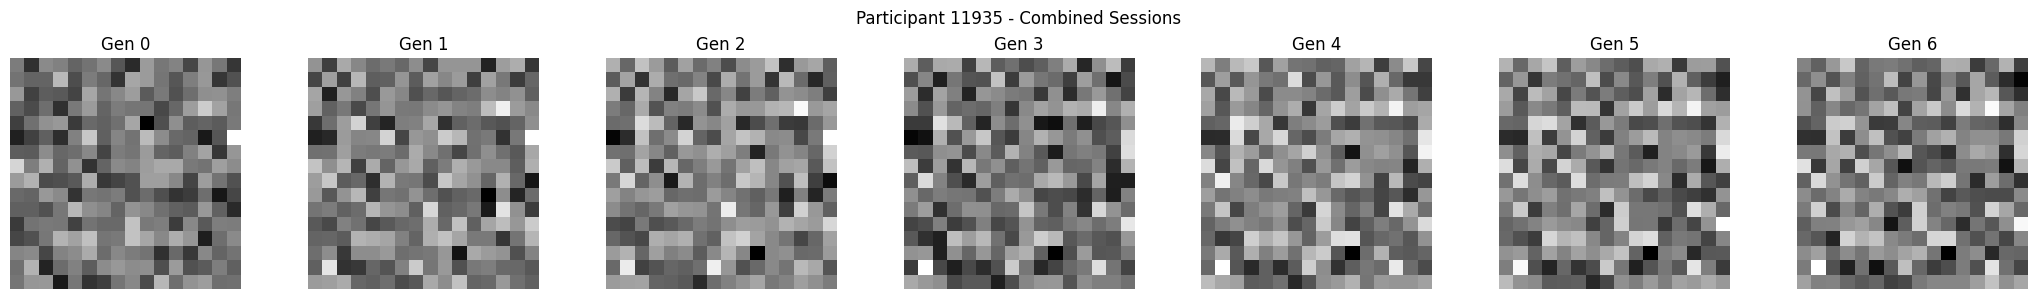


Visualizing Participant 12457


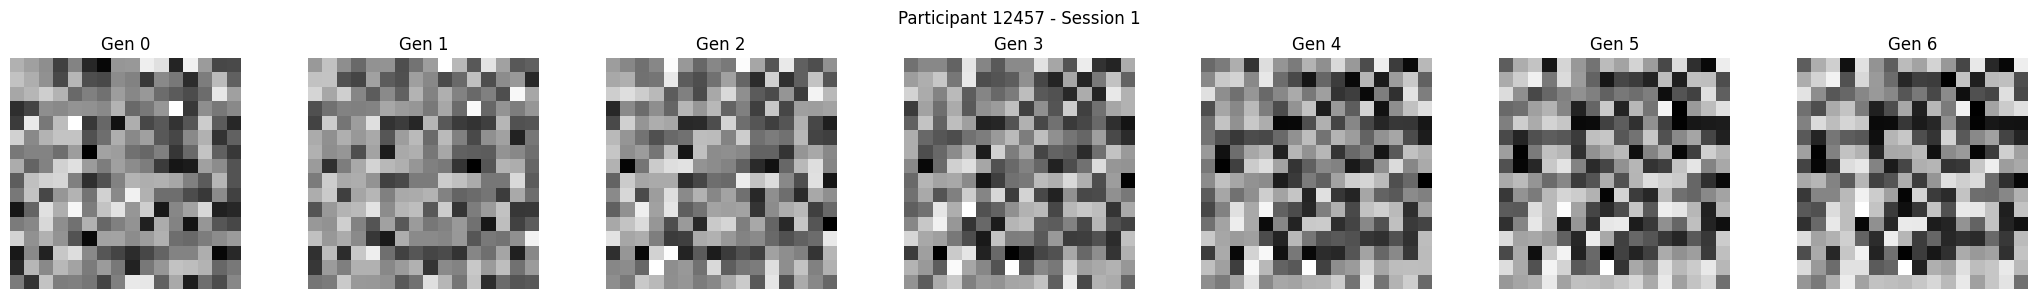

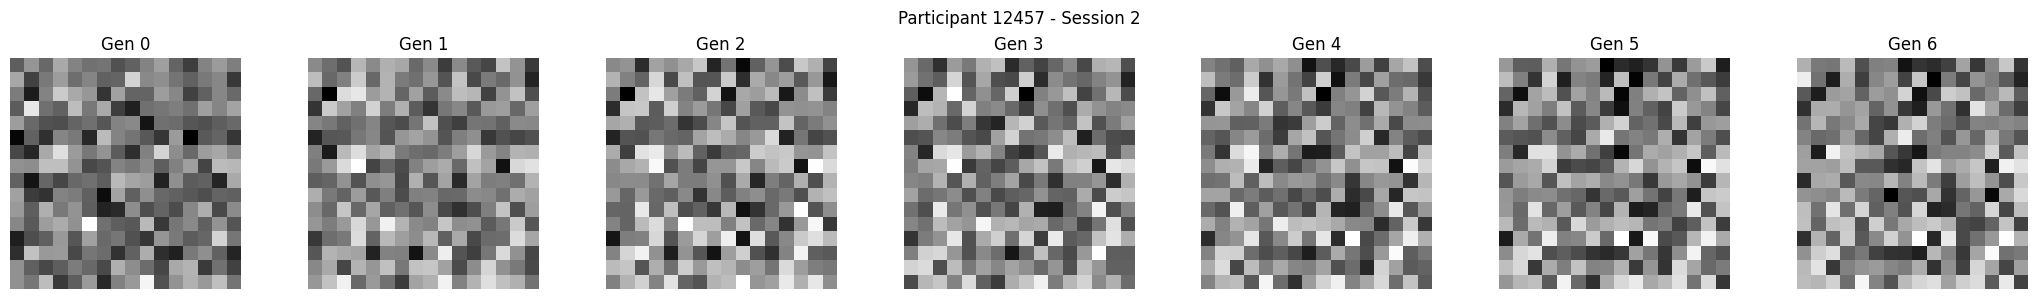

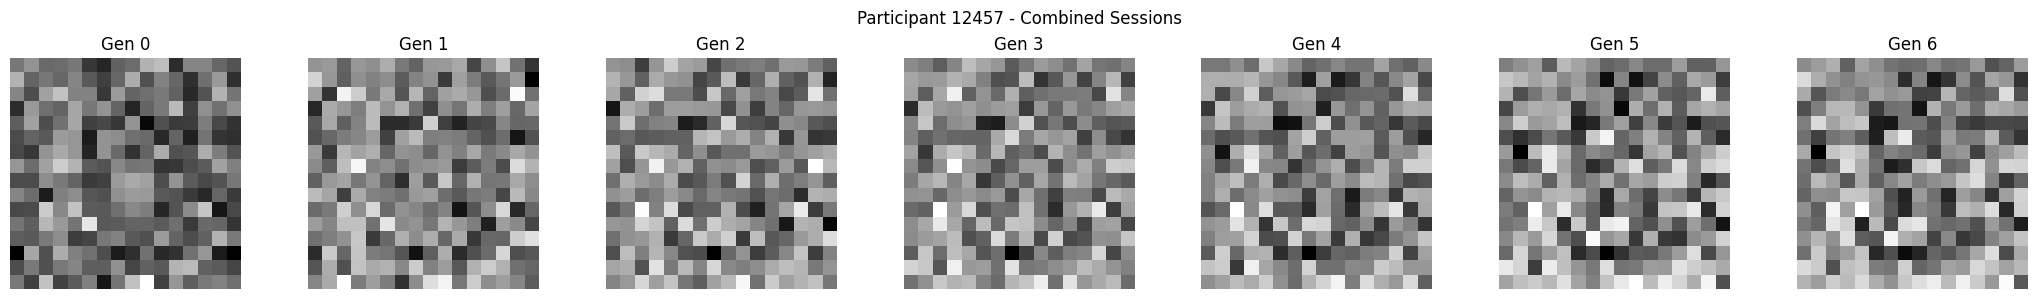


Visualizing Participant 12085


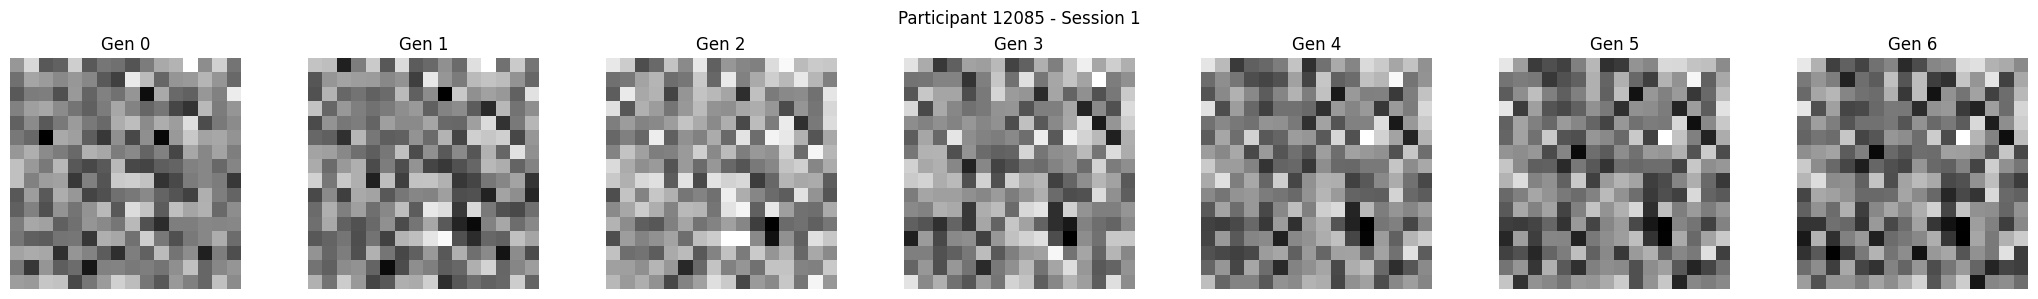

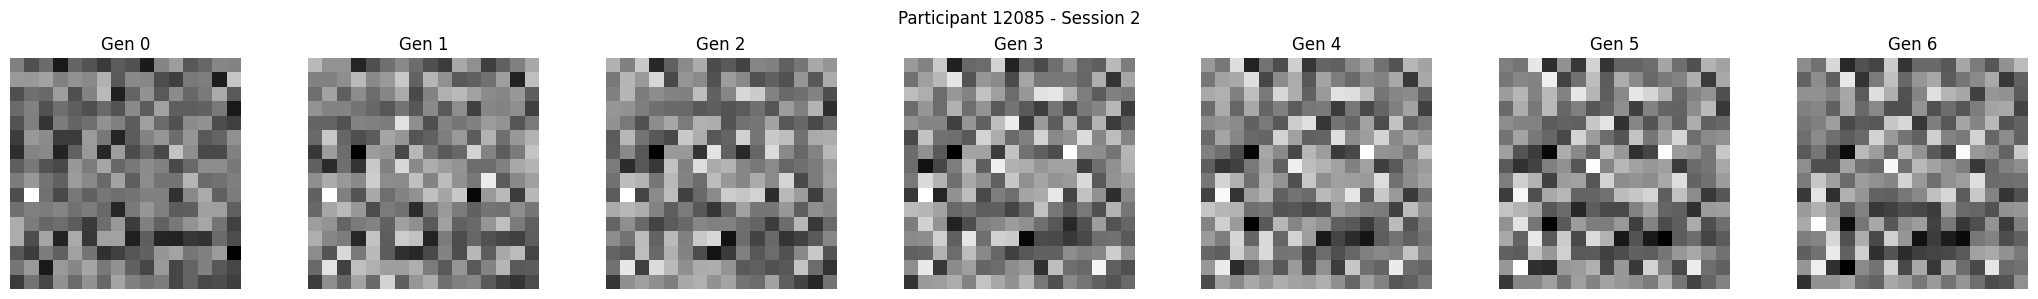

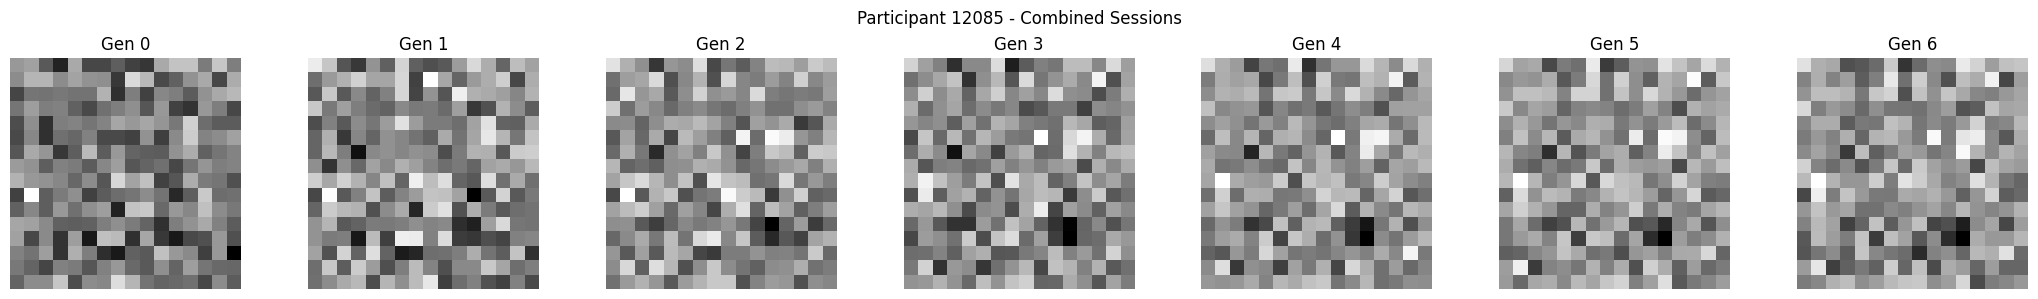


Visualizing Participant 12082


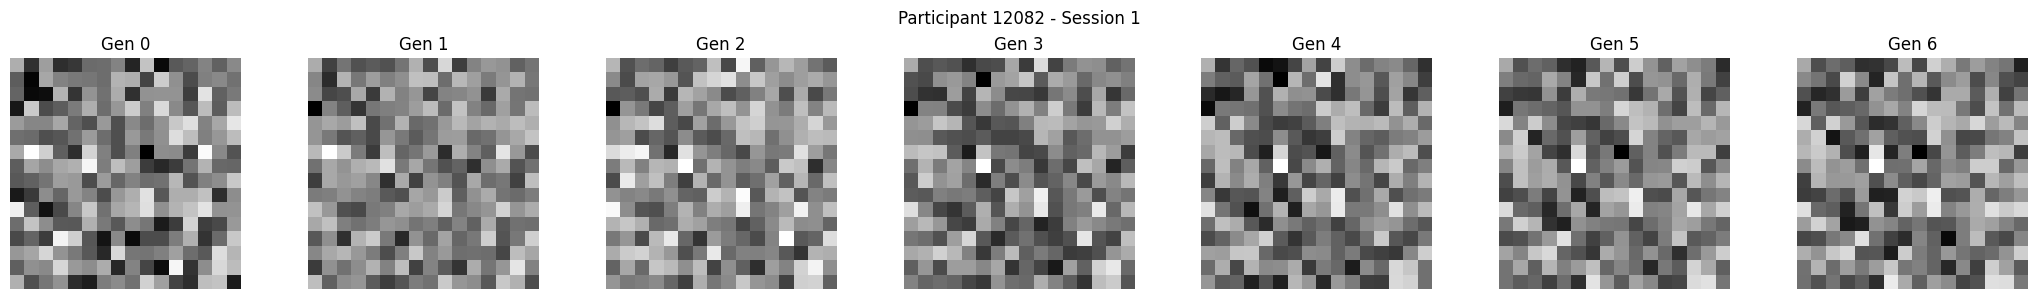

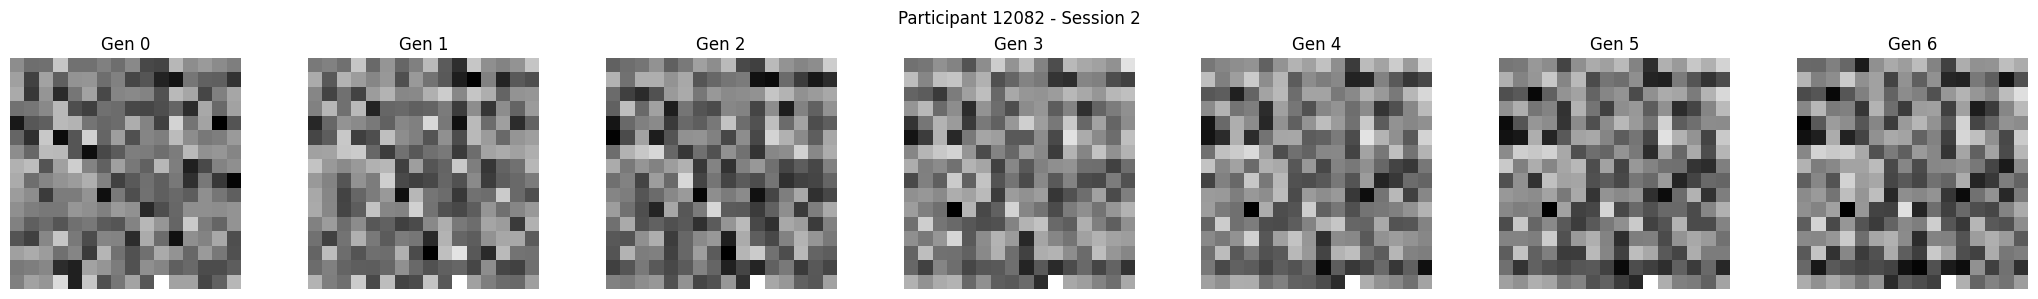

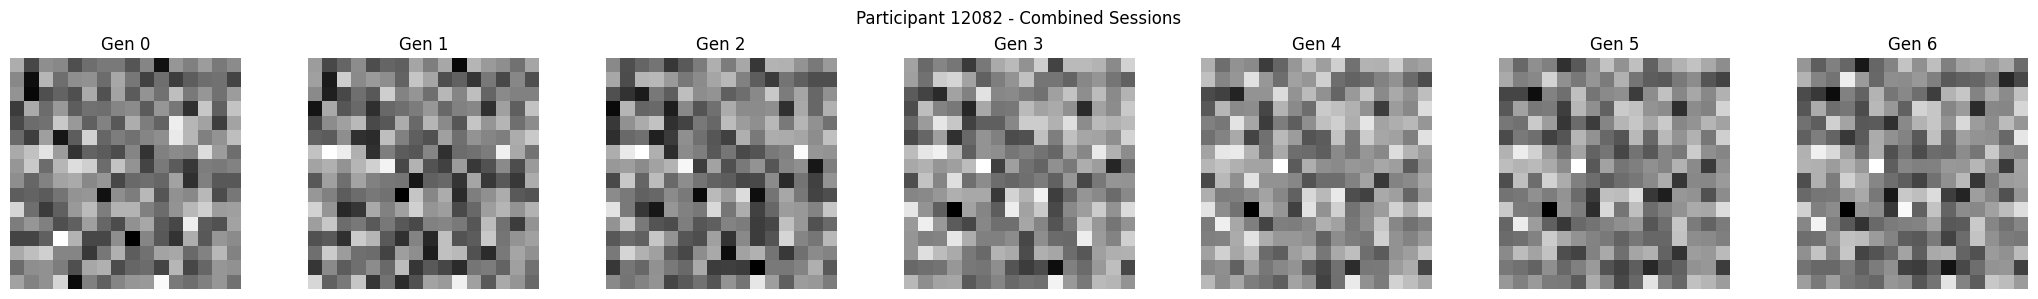


Visualizing Participant -1


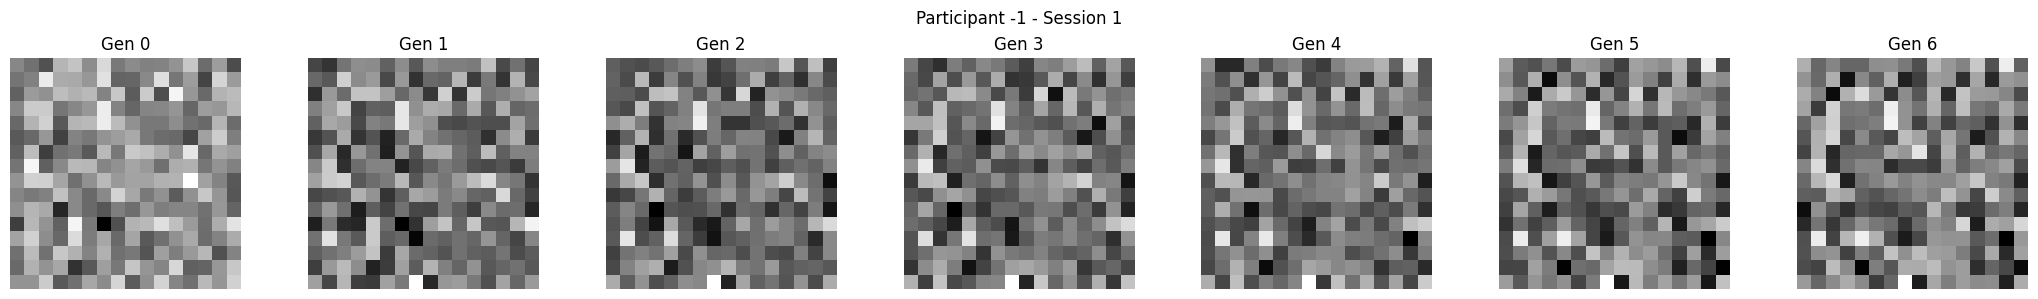

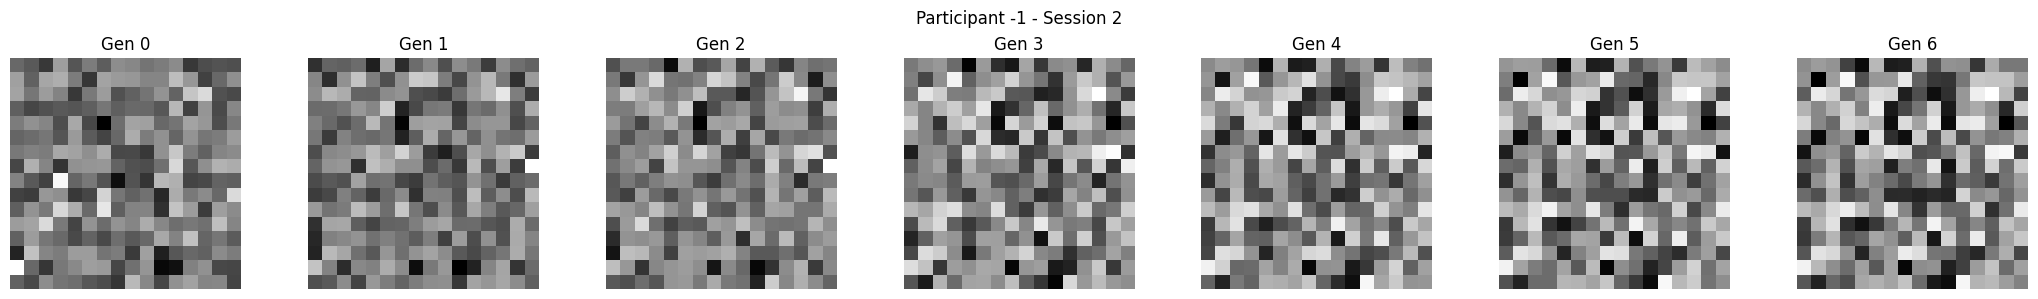

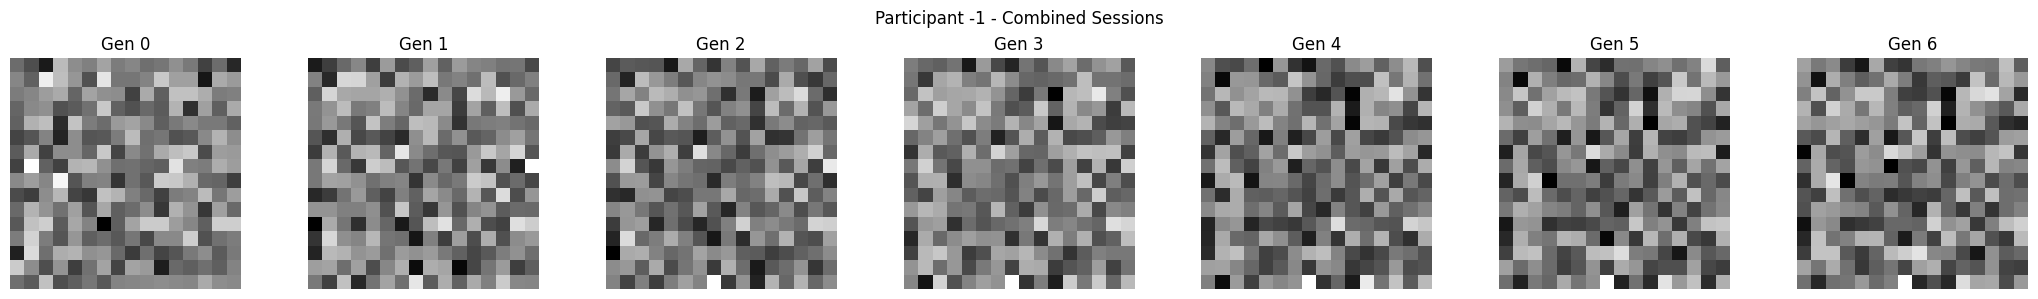


Visualizing Participant 12301


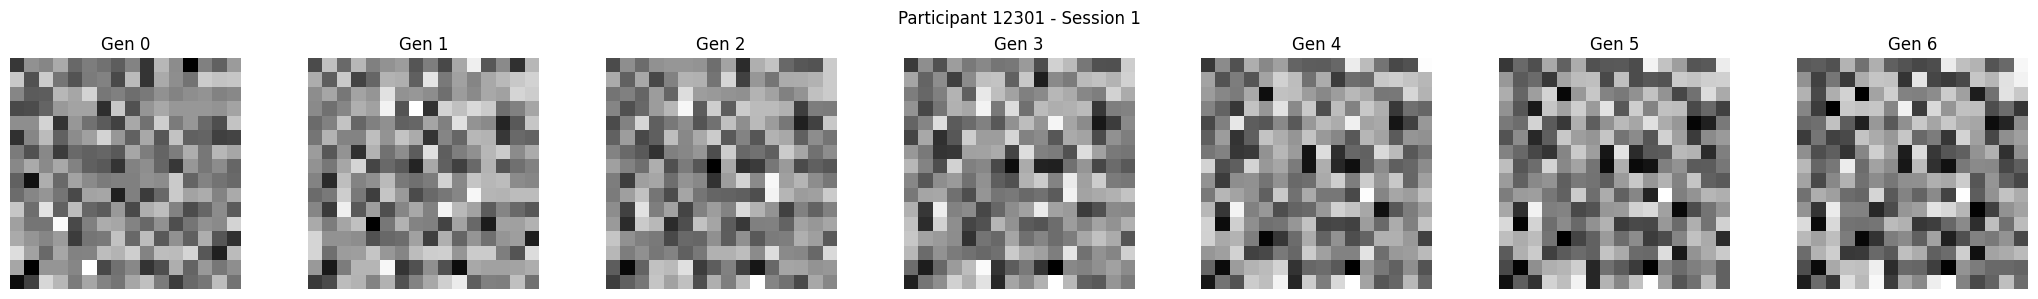

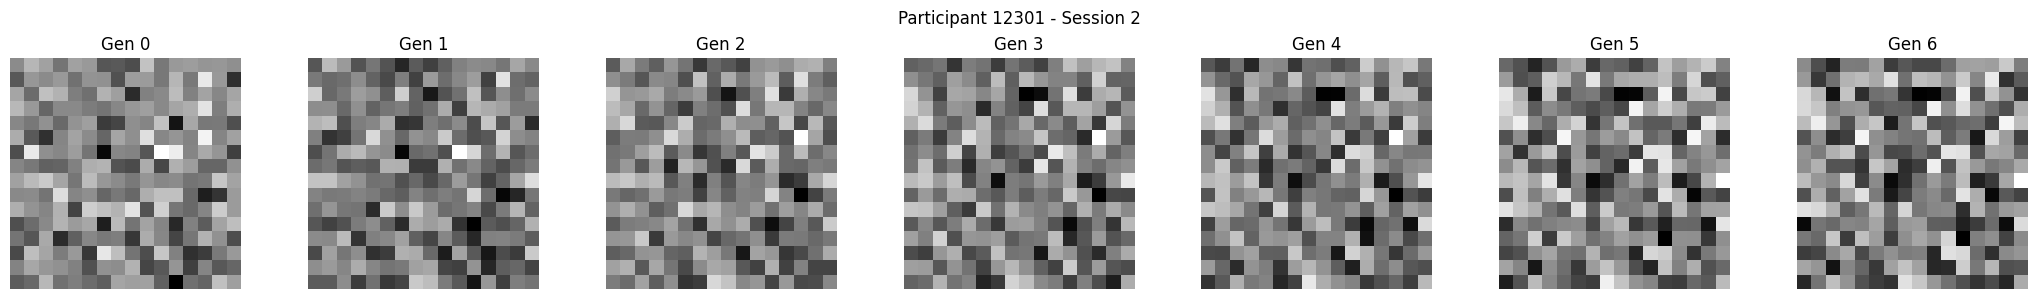

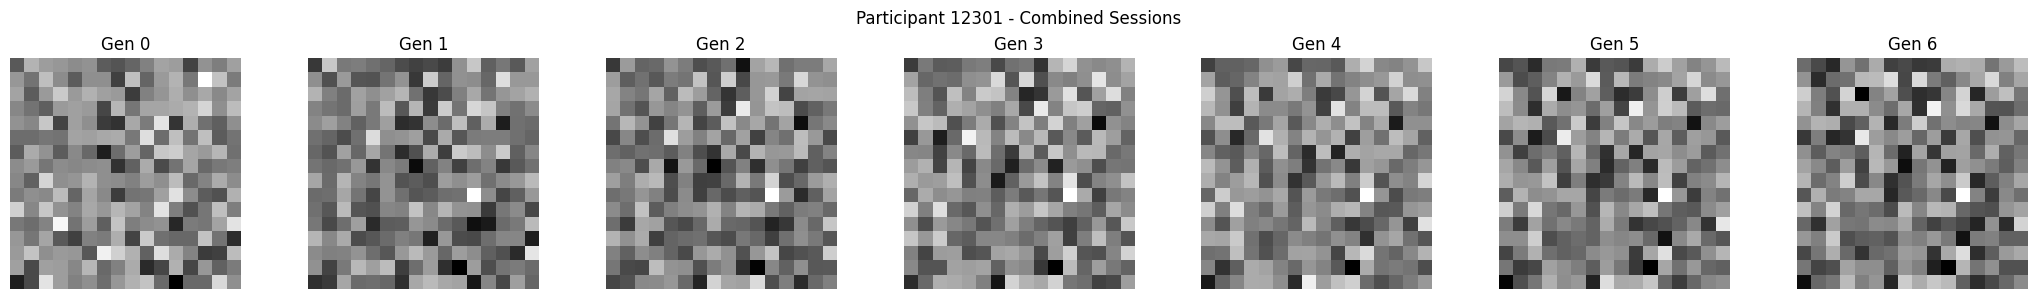


Visualizing Participant 12055


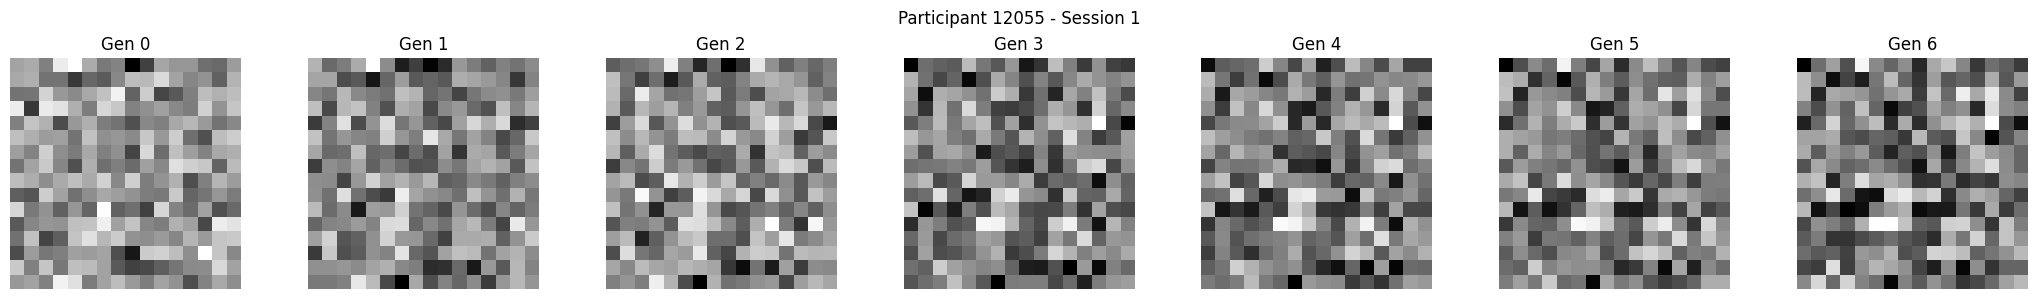

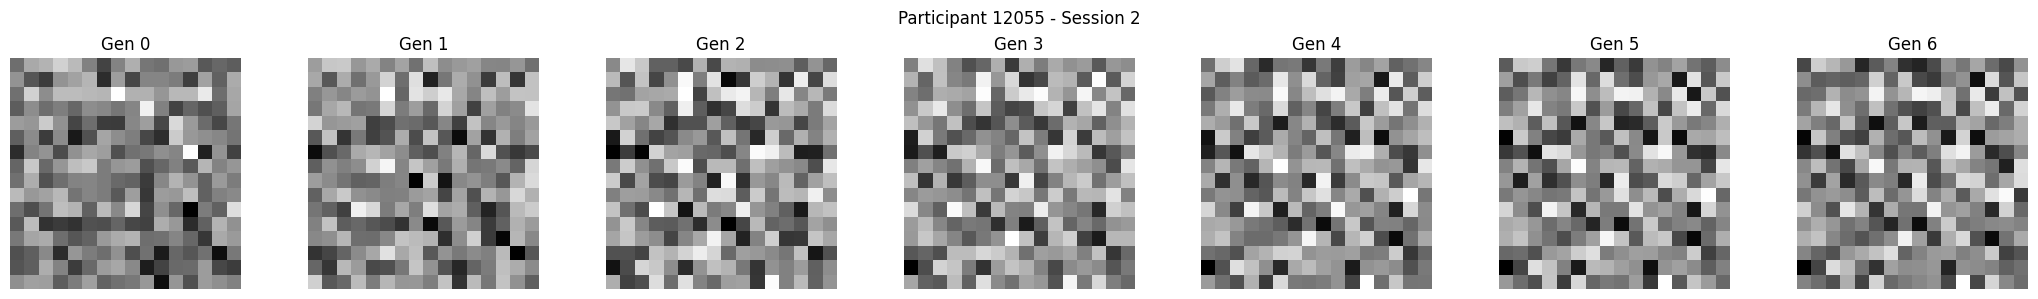

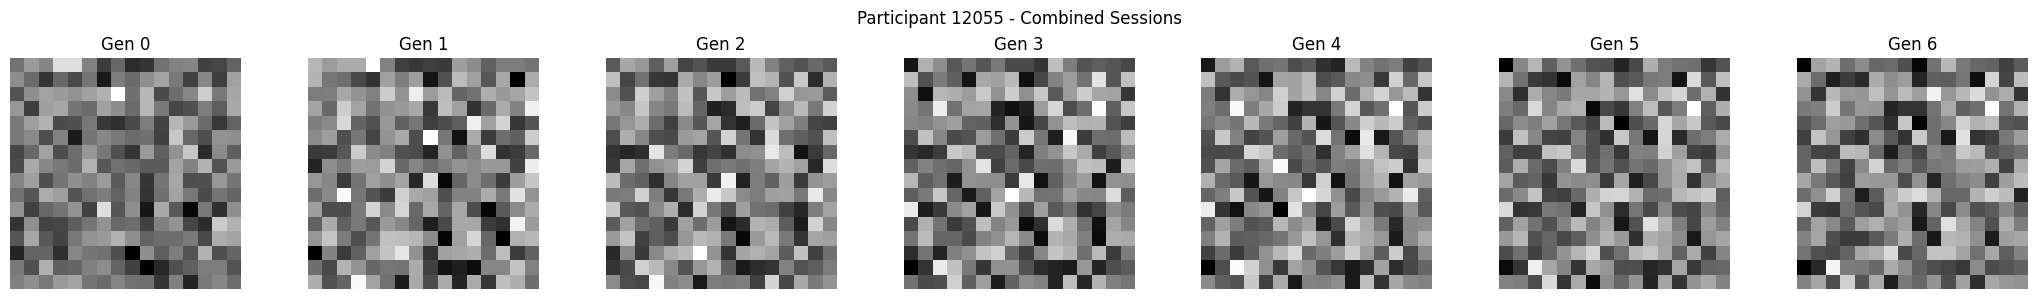


Visualizing Participant 12601


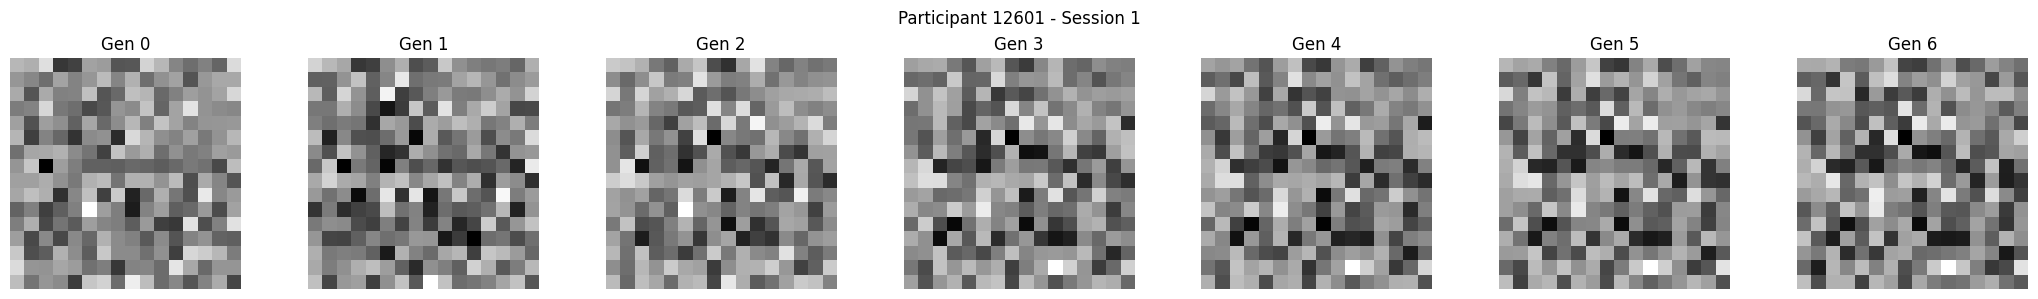

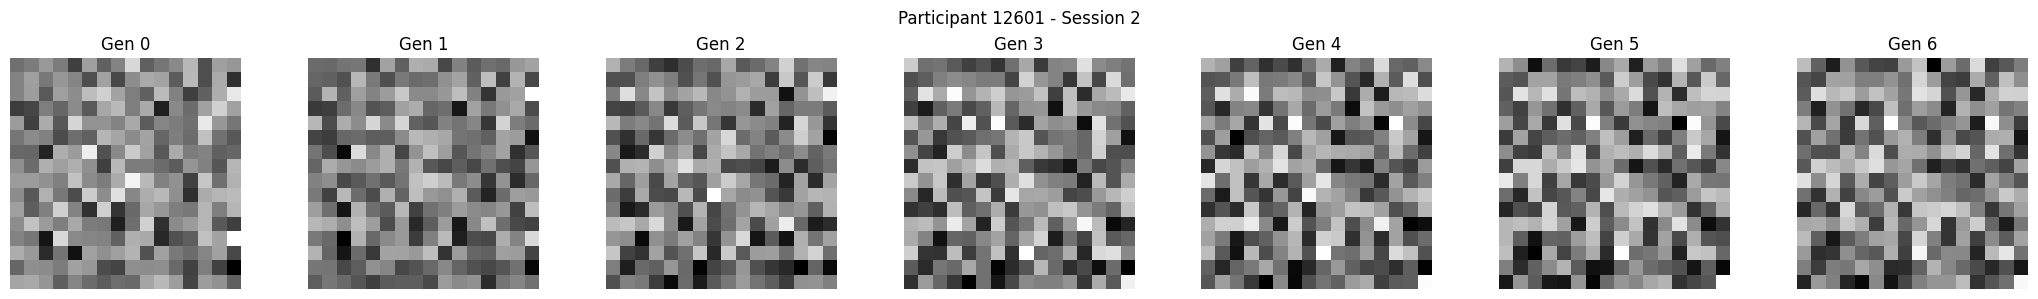

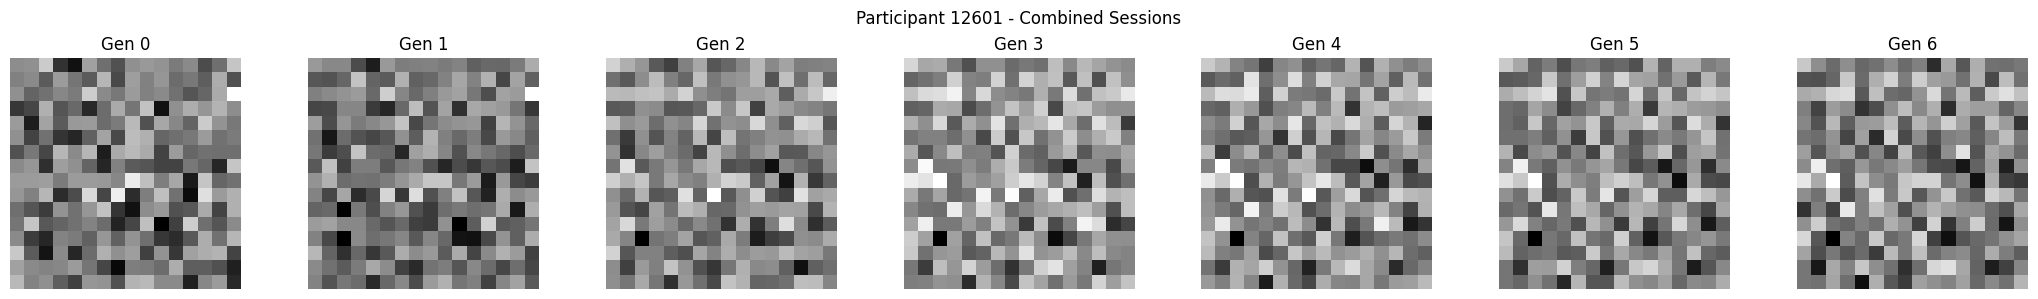


Visualizing Participant 14755


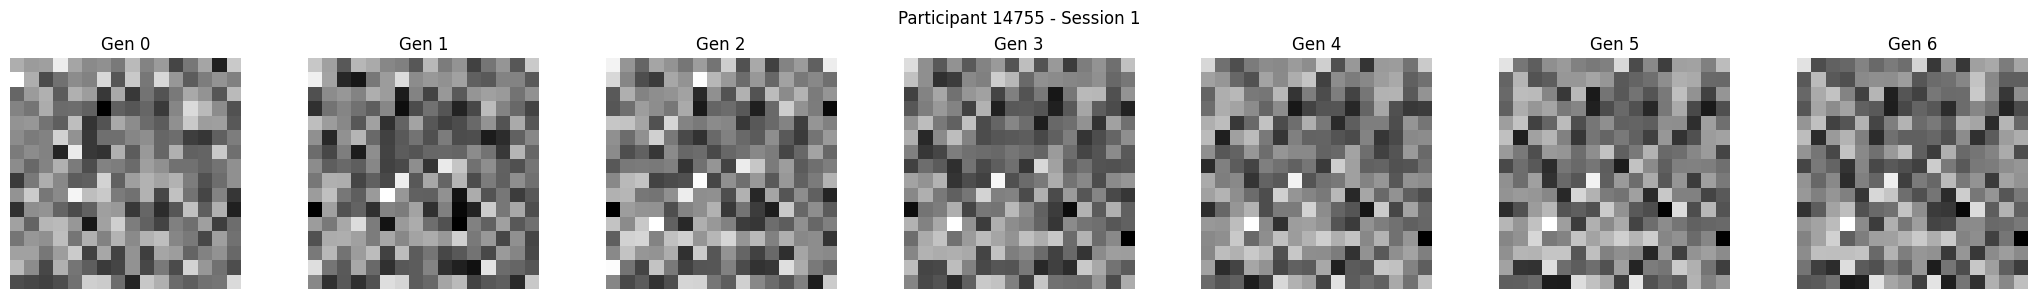

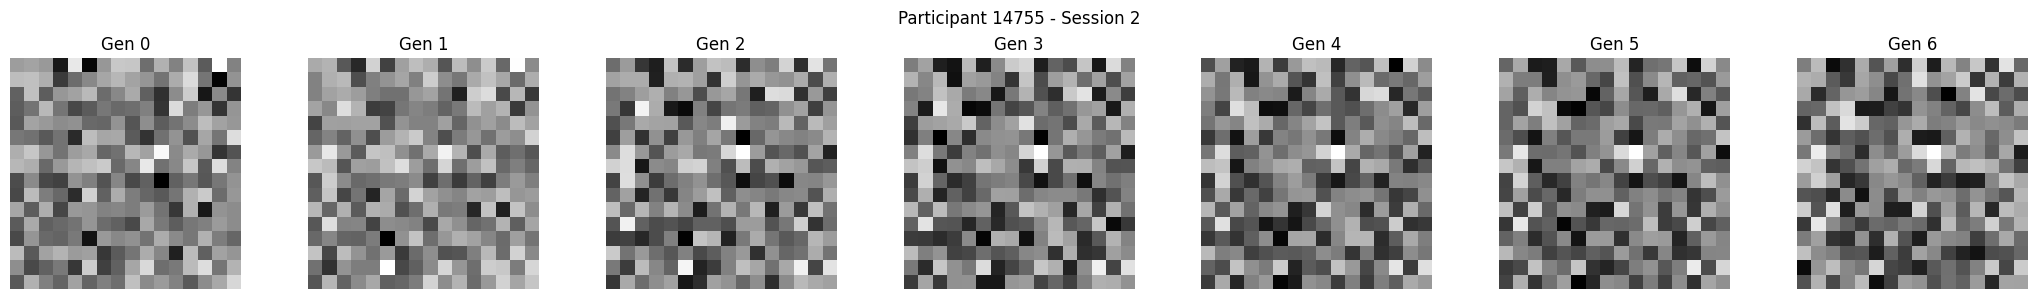

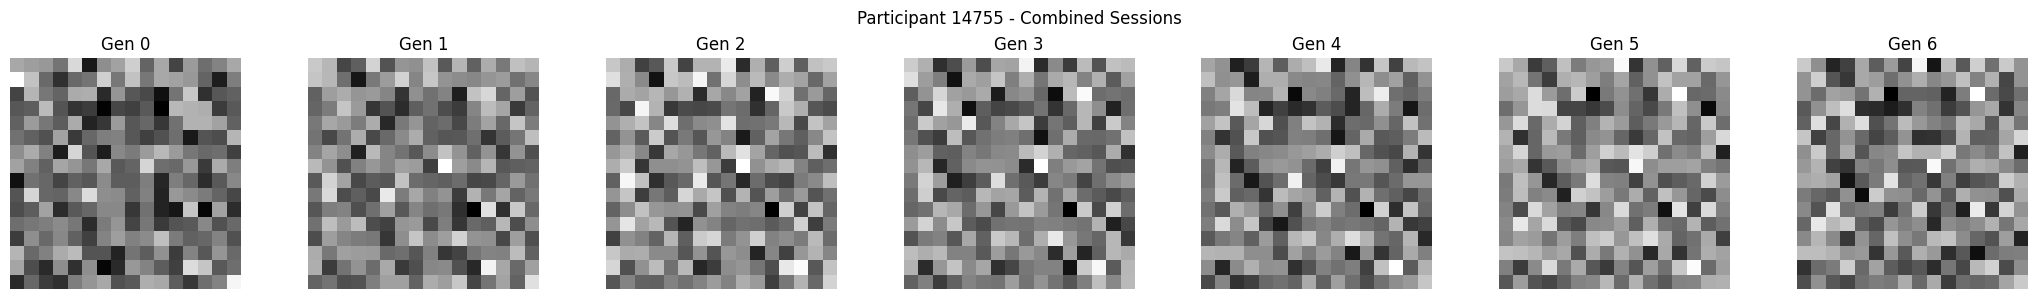


Visualizing Participant 13465


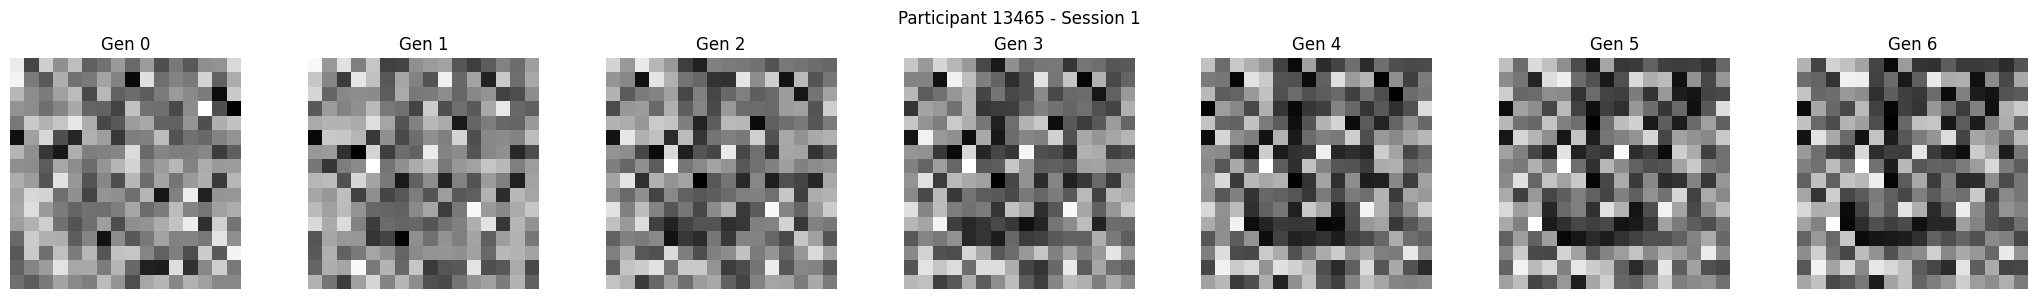

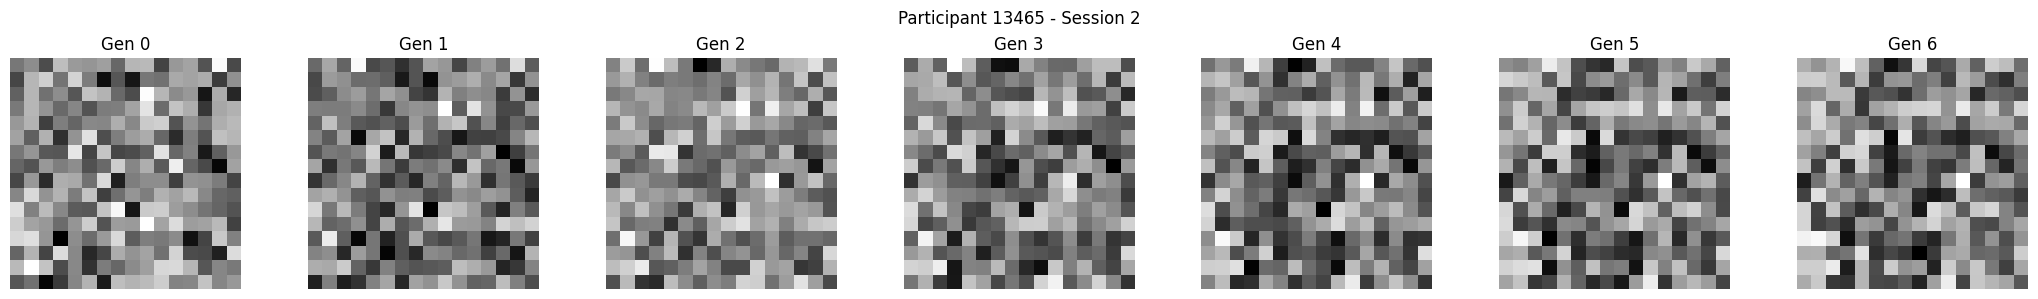

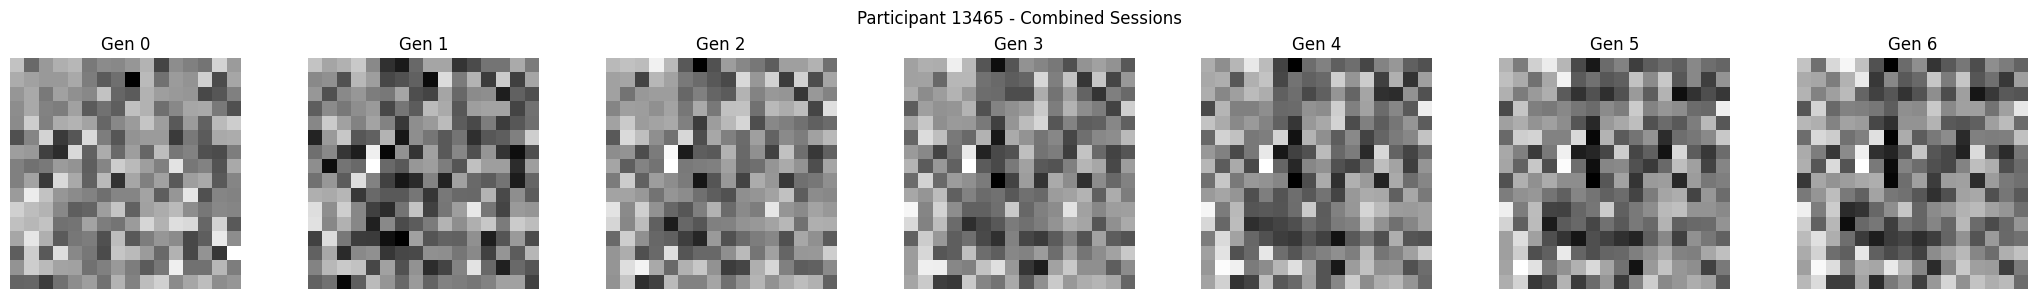


Visualizing Participant 14413


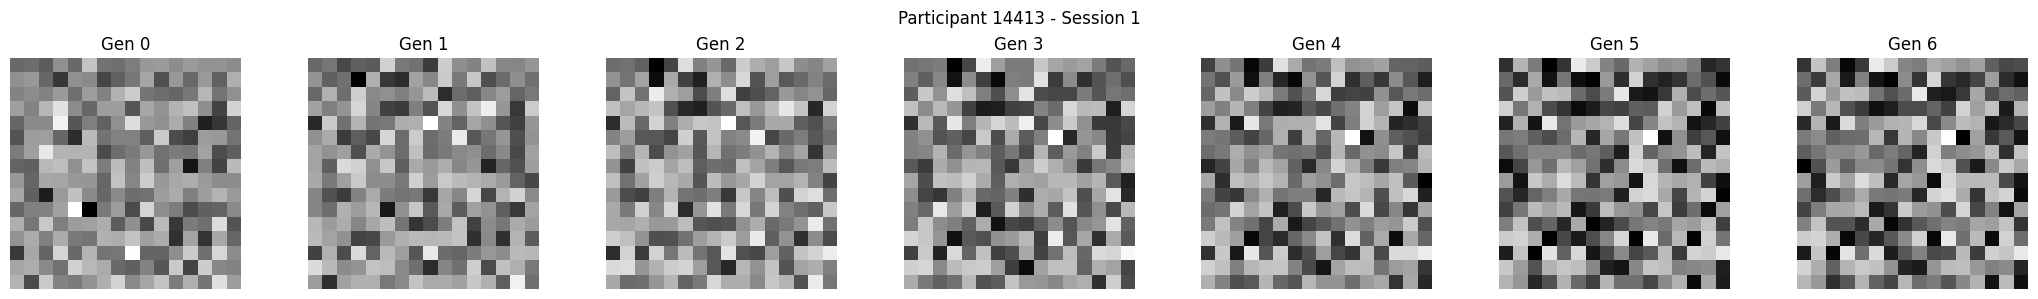

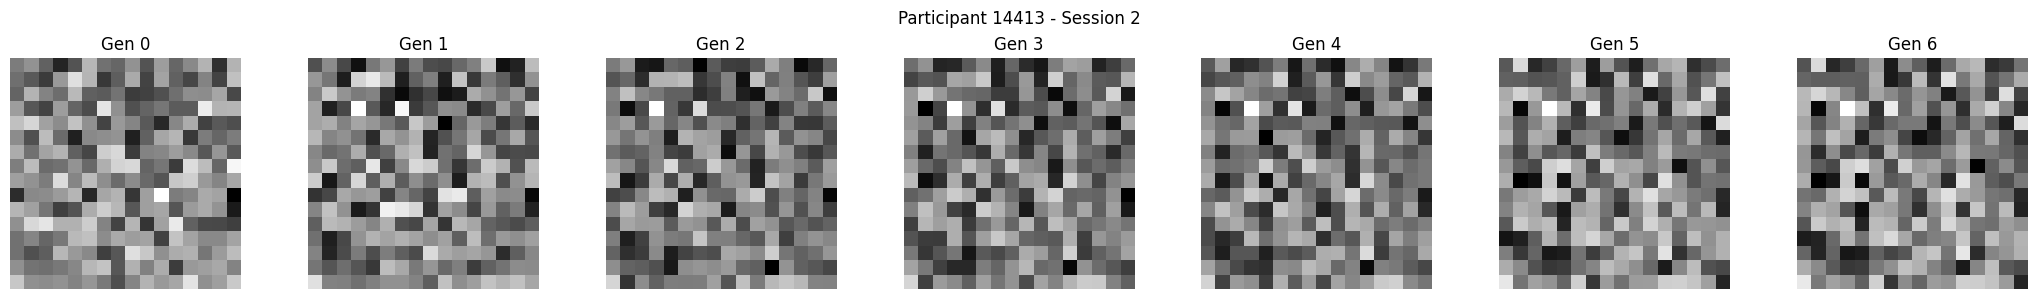

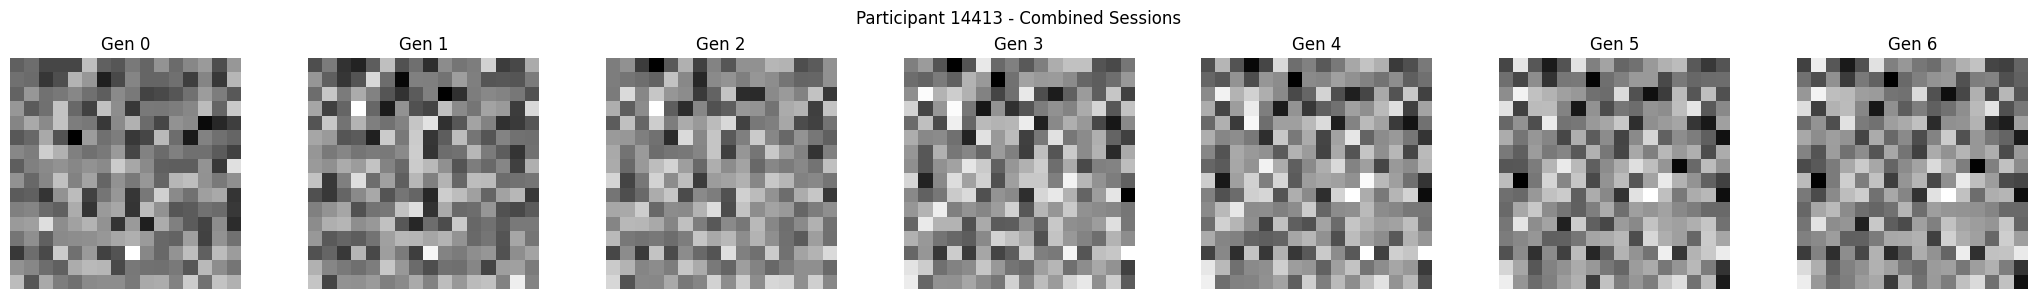


Visualizing Participant 13597


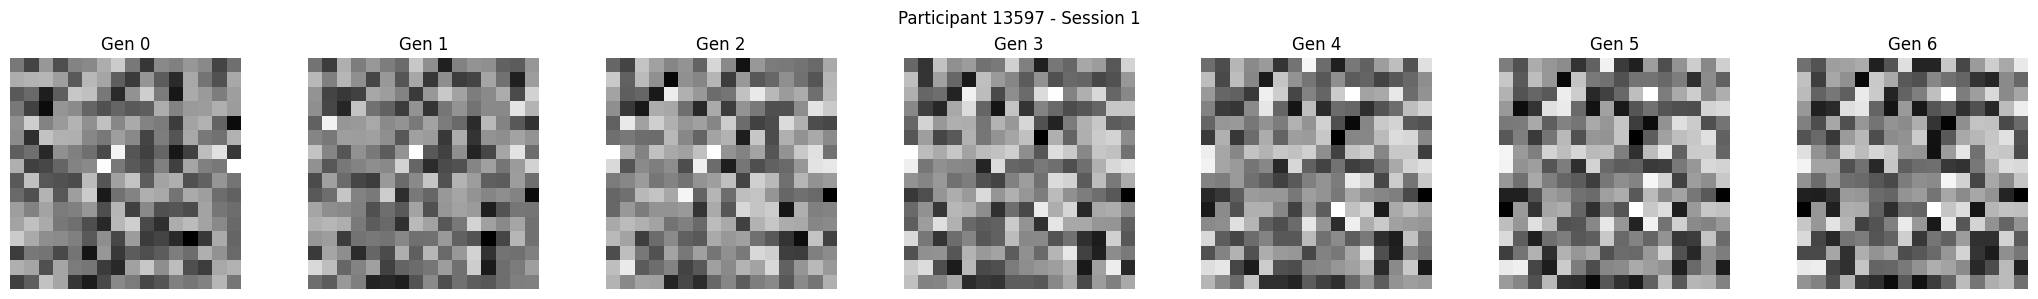

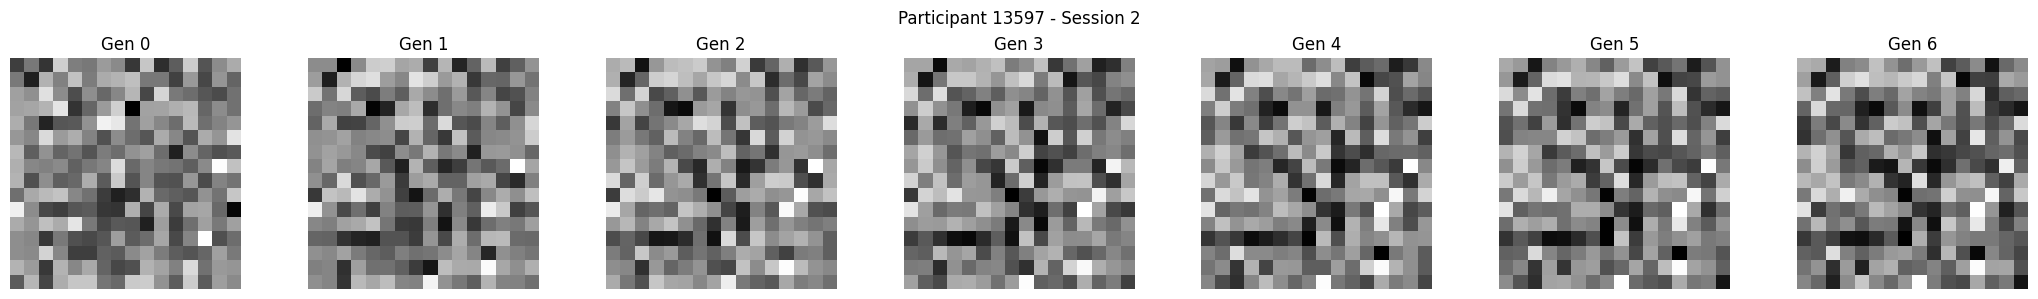

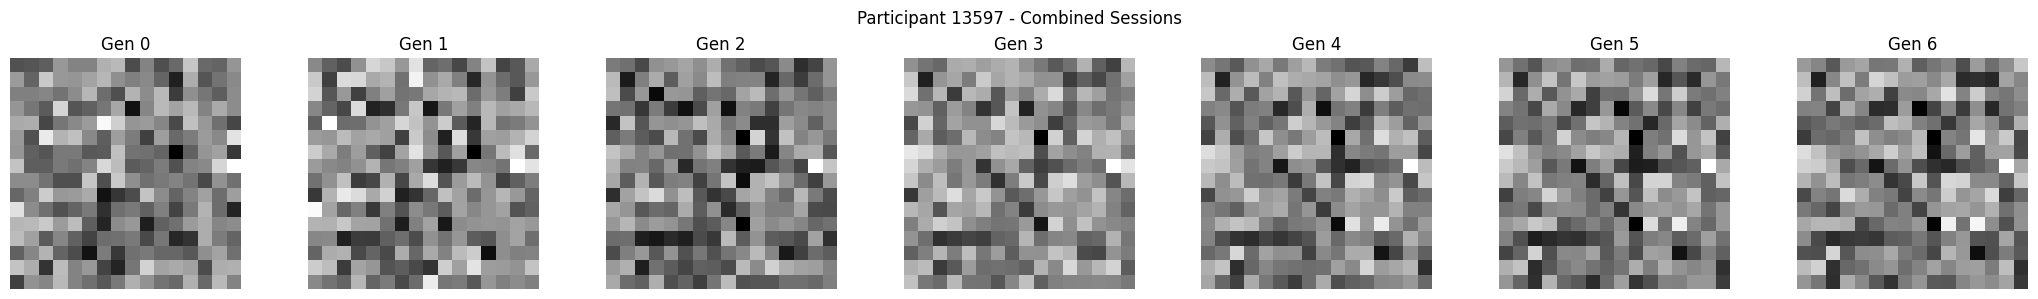


Visualizing Participant 13438


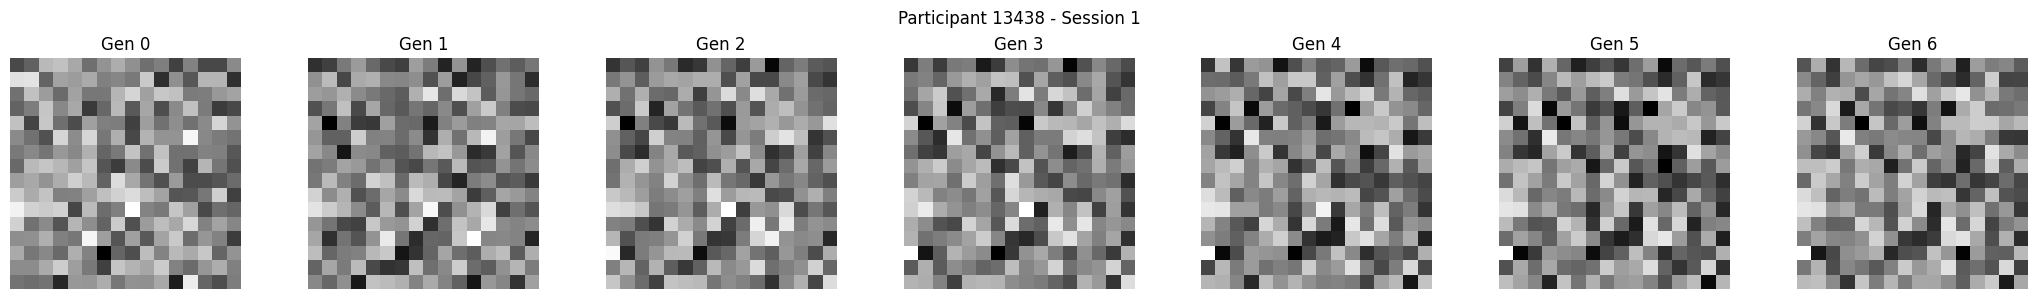

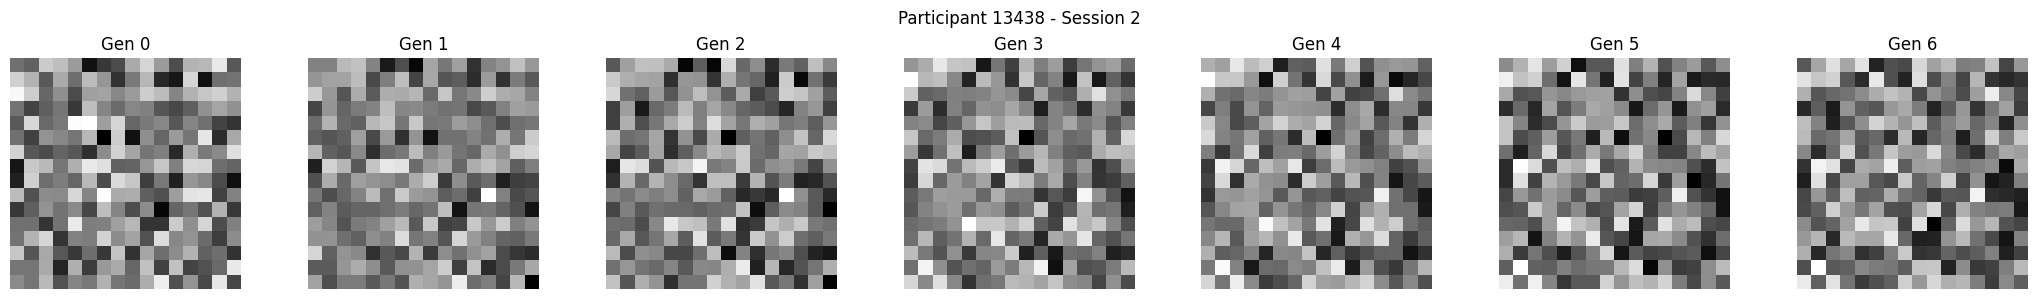

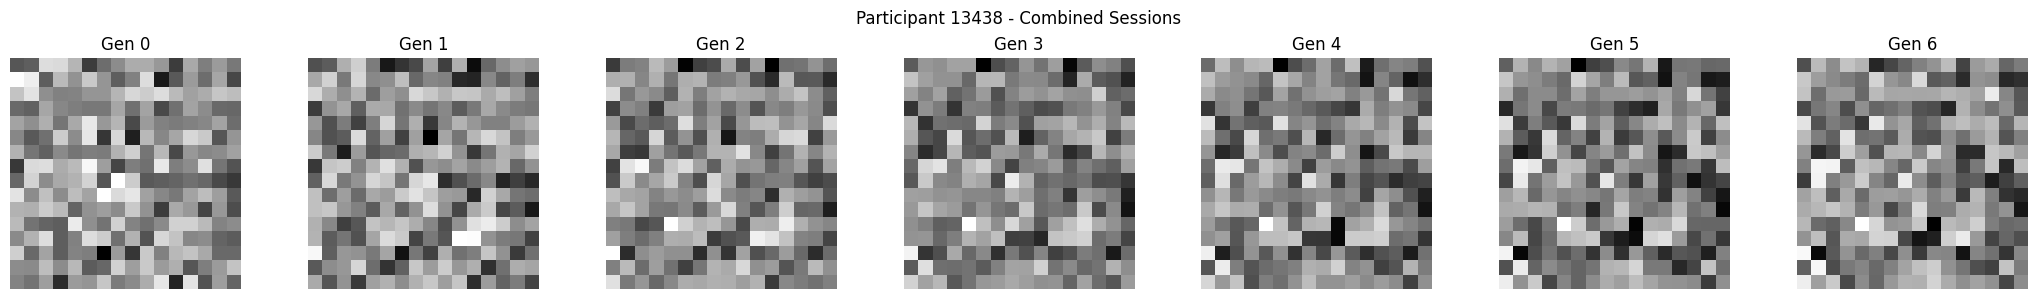


Visualizing Participant 12727


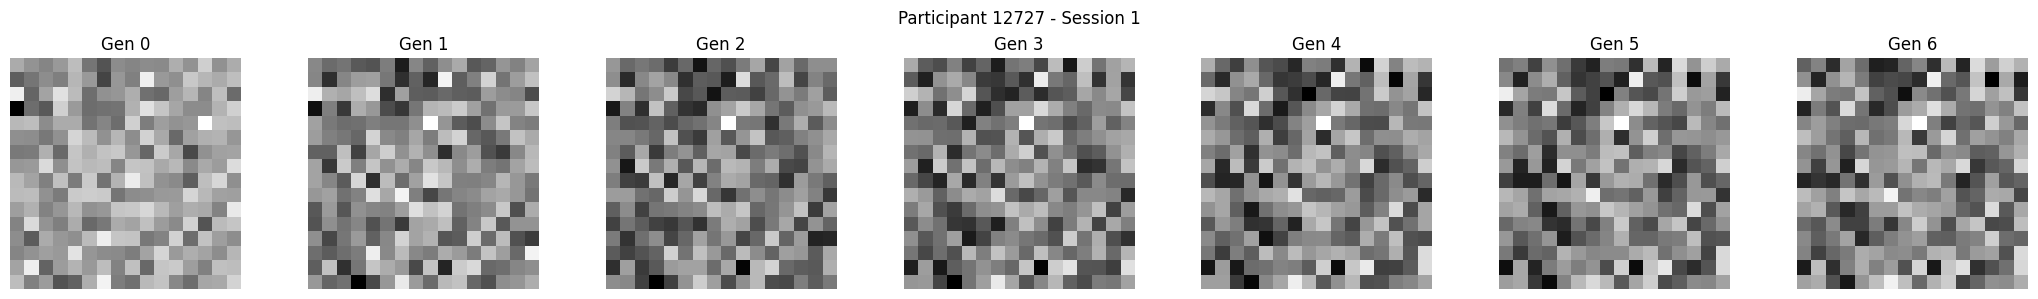

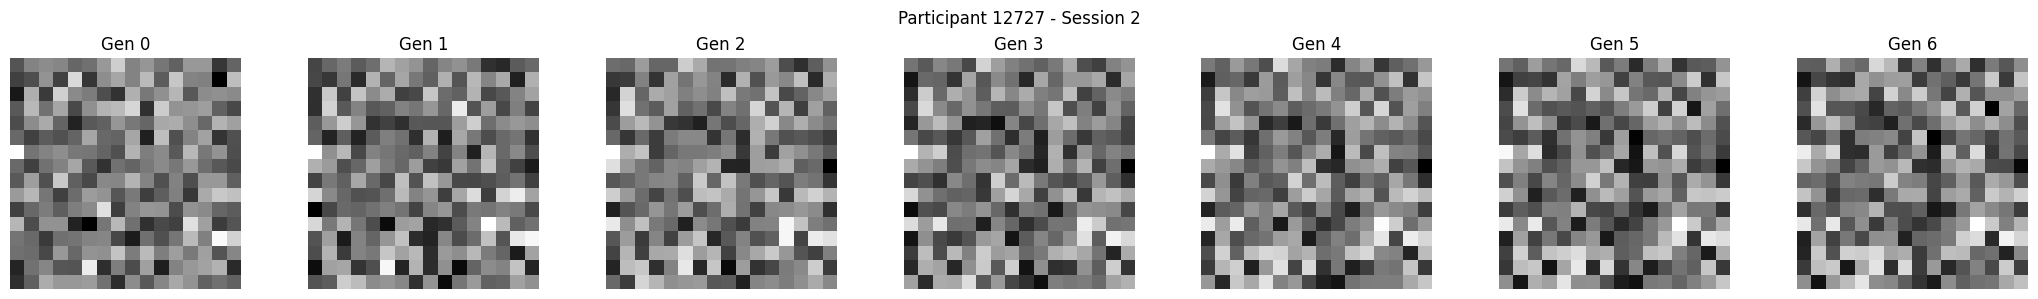

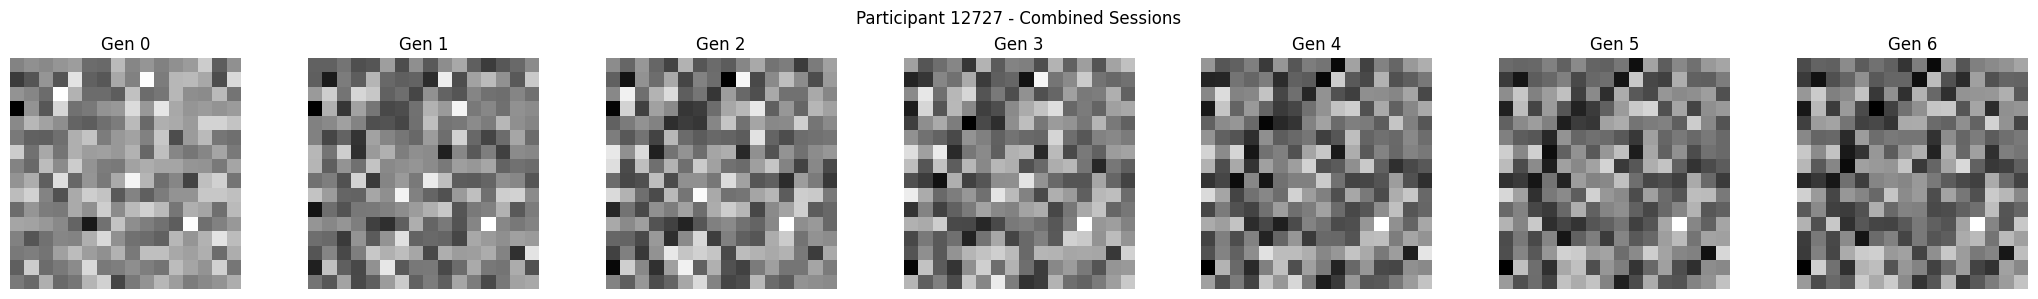


Visualizing Participant 12031


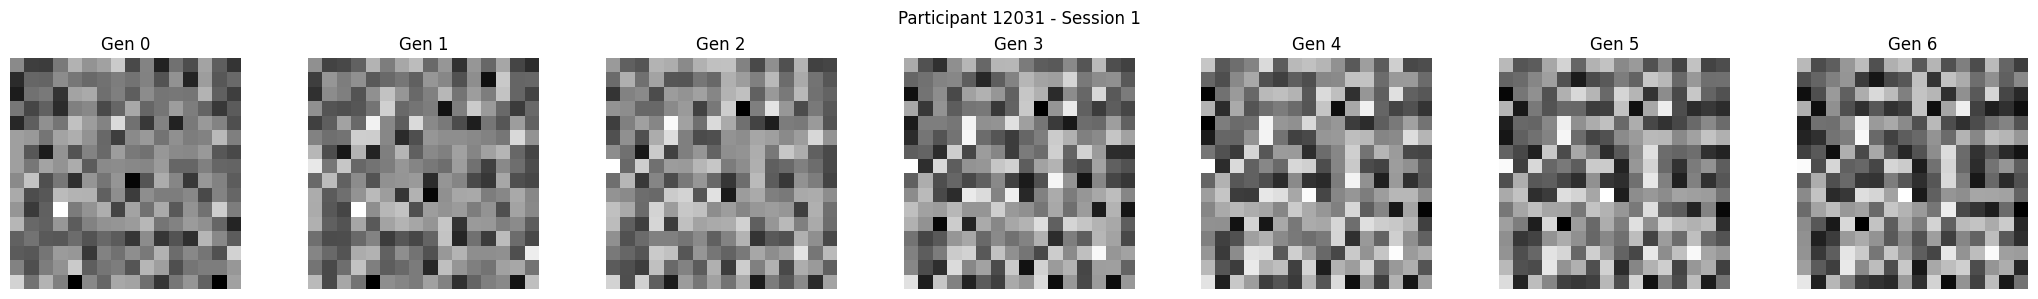

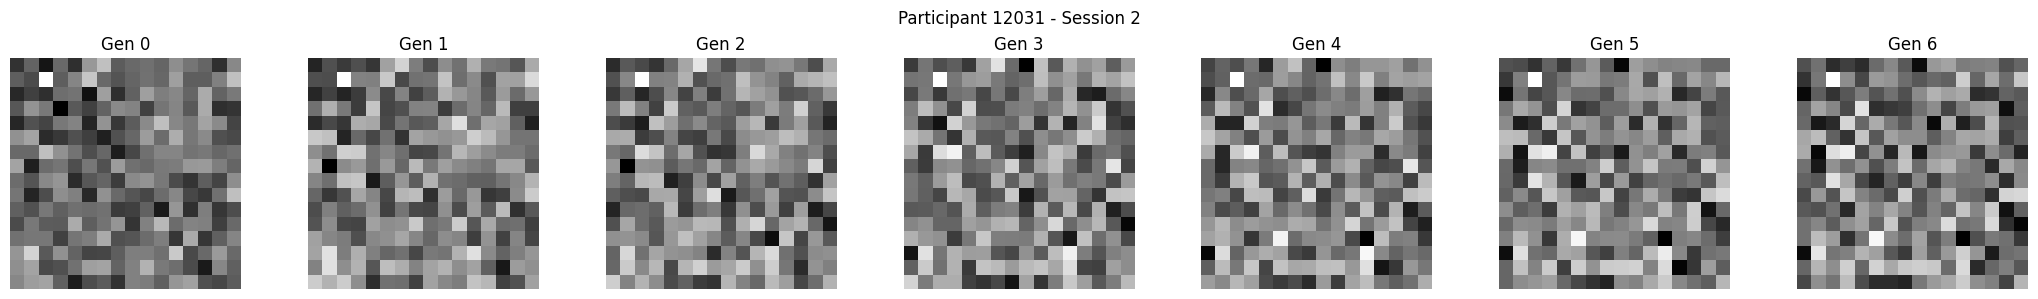

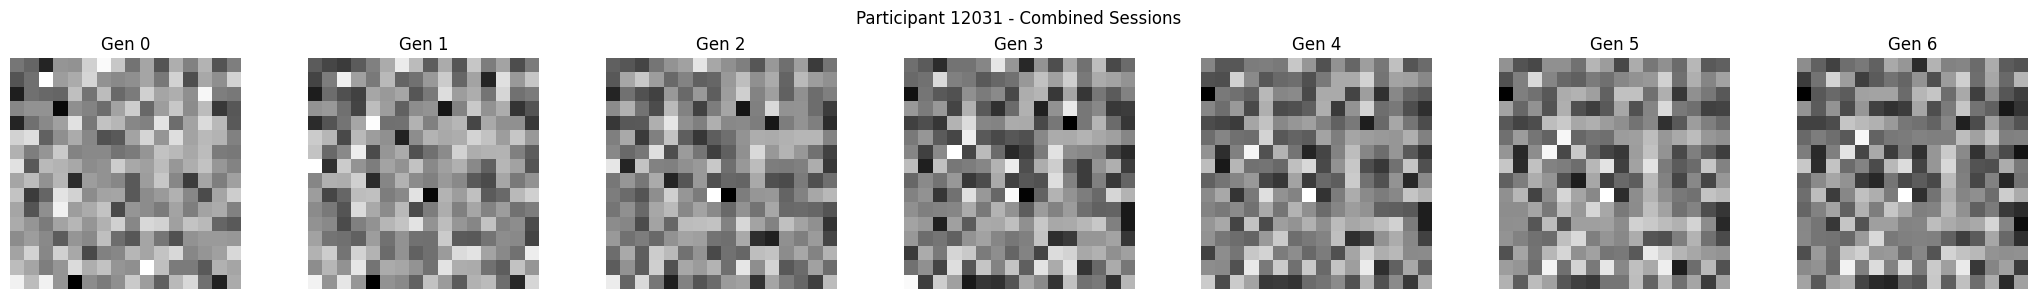


Visualizing Participant 14536


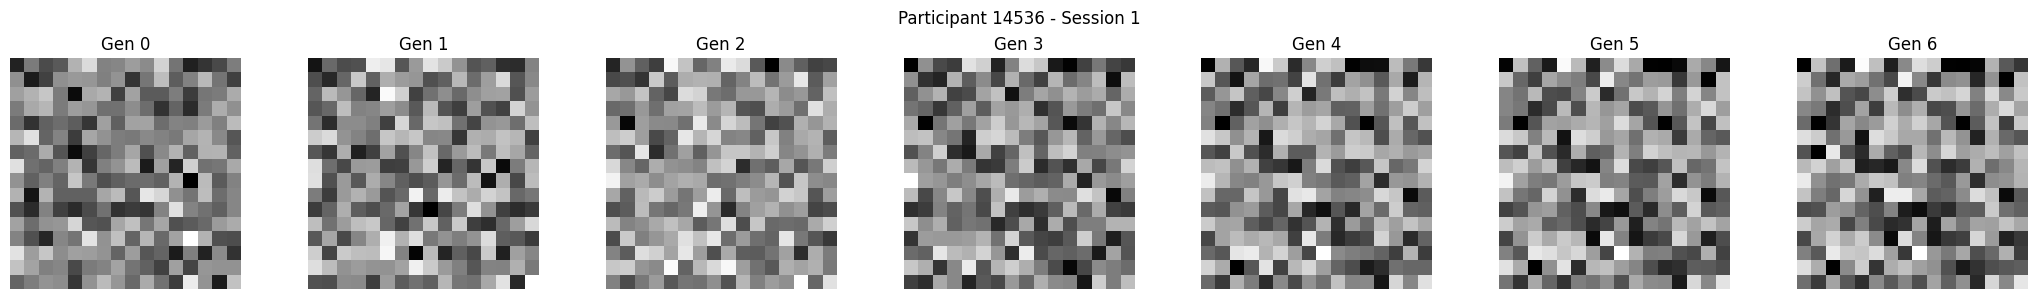

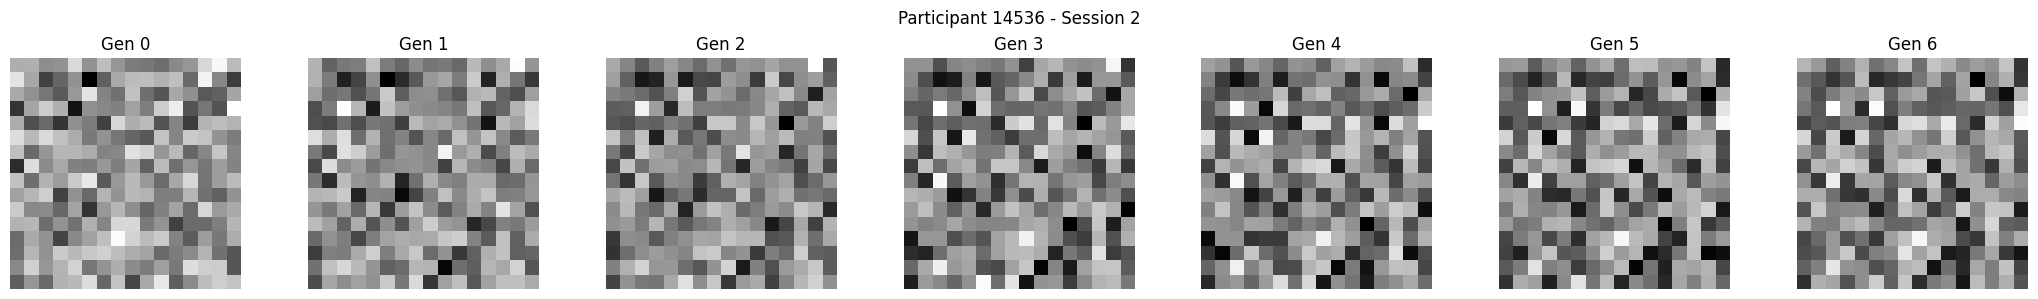

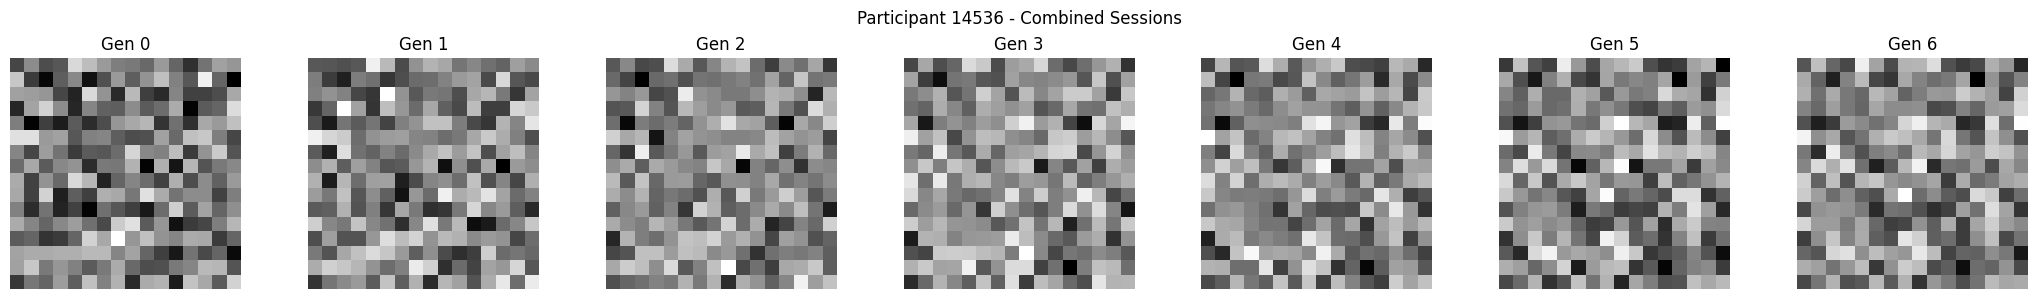


Visualizing Participant 12298


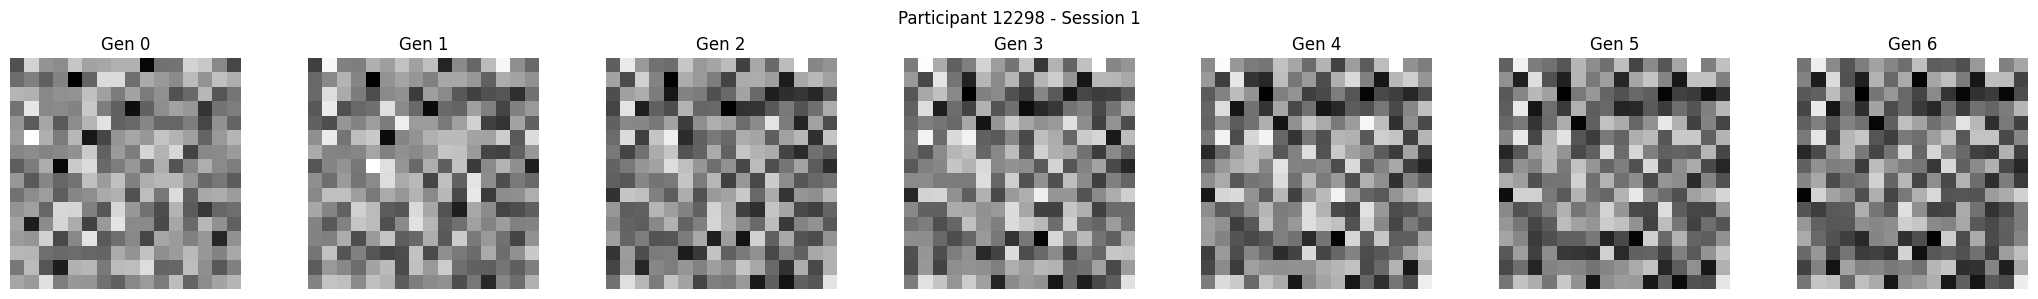

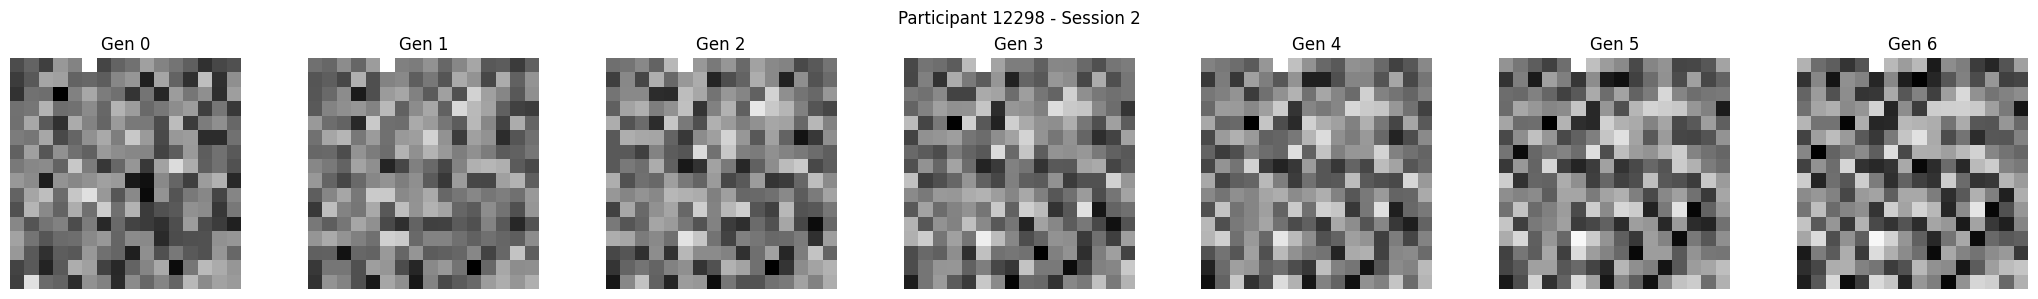

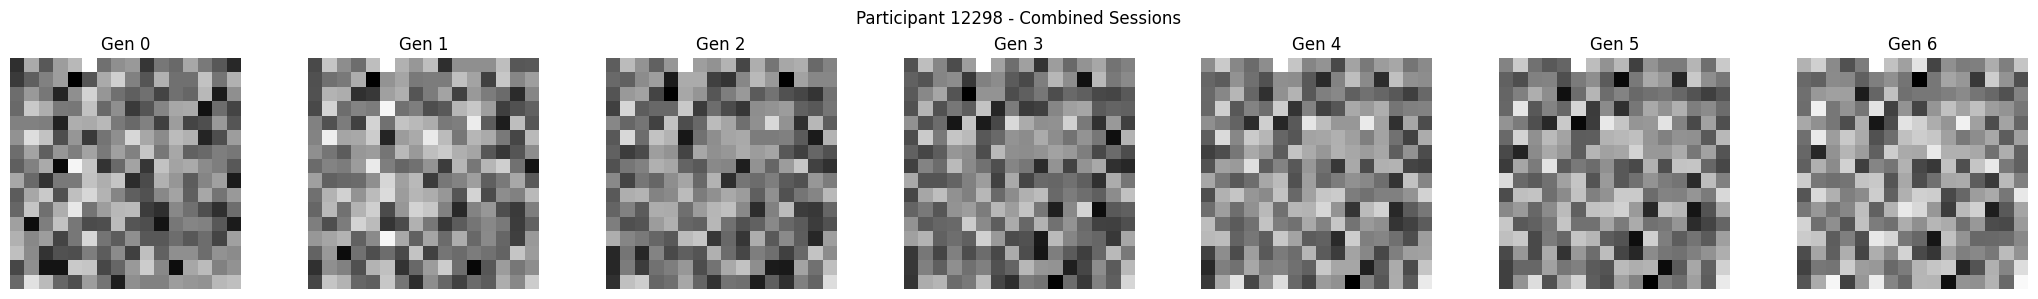


Visualizing Participant 13204


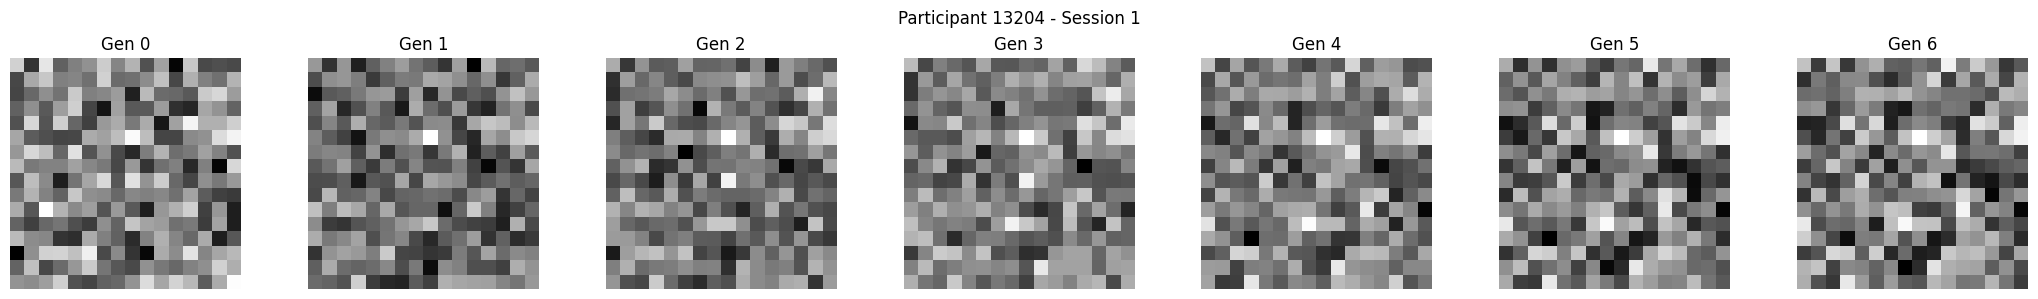

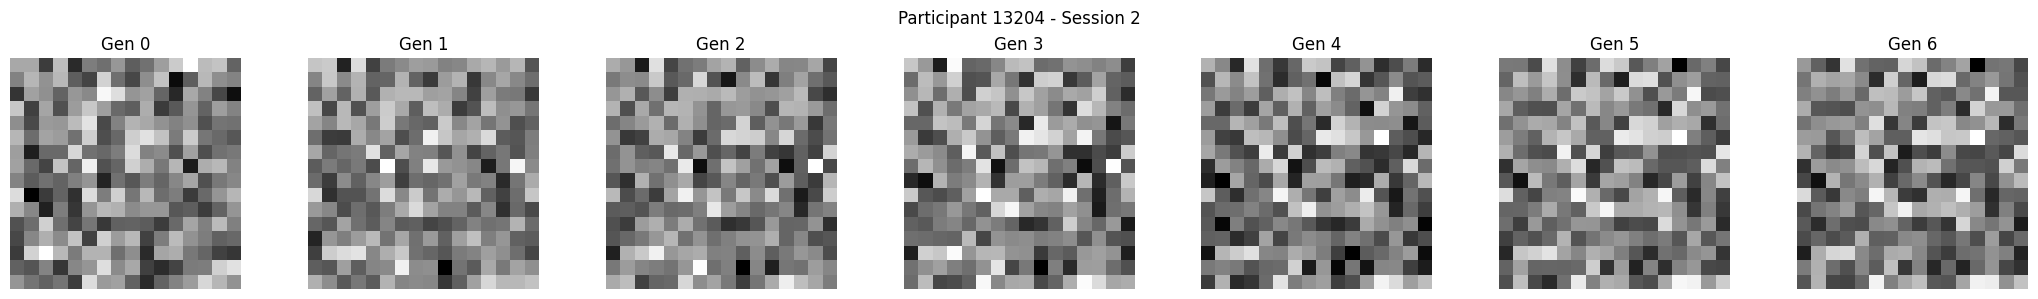

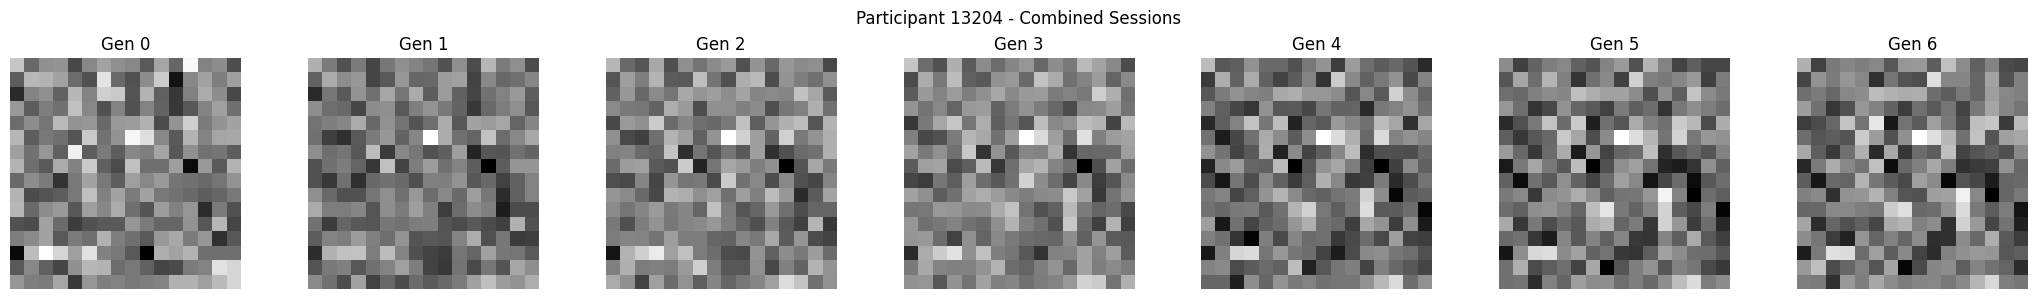


Visualizing Participant 12292


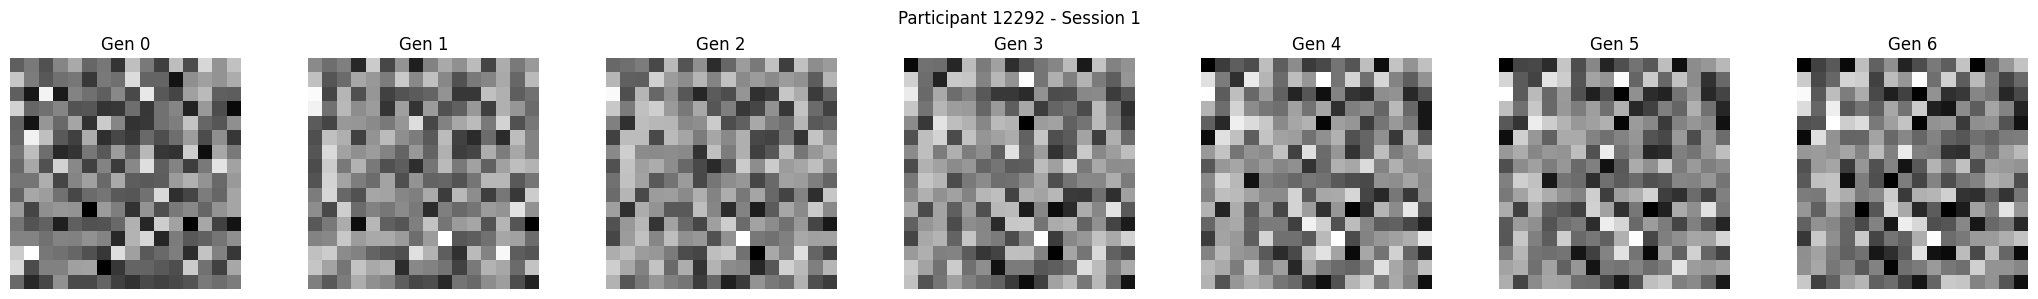

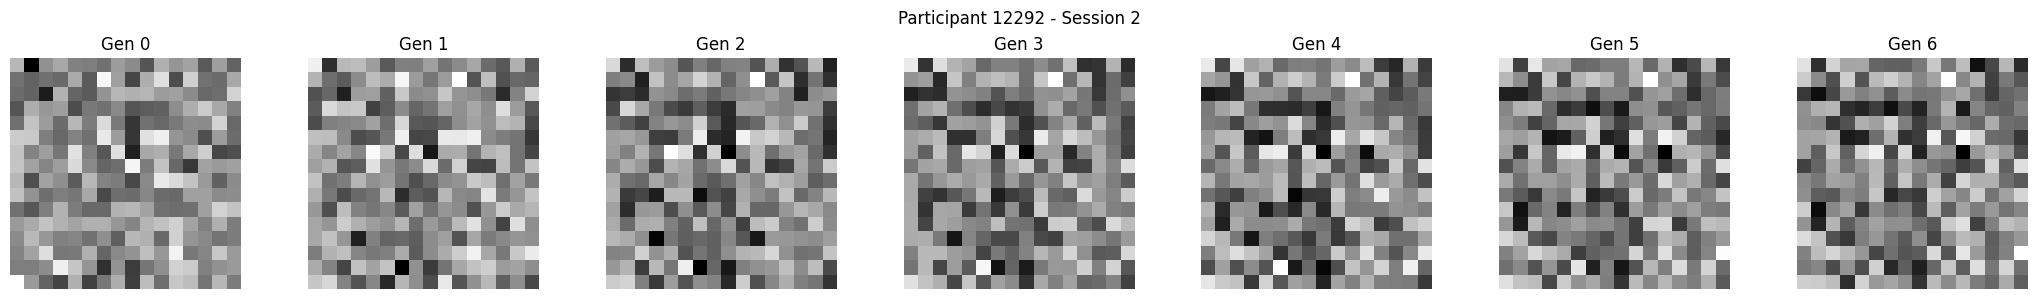

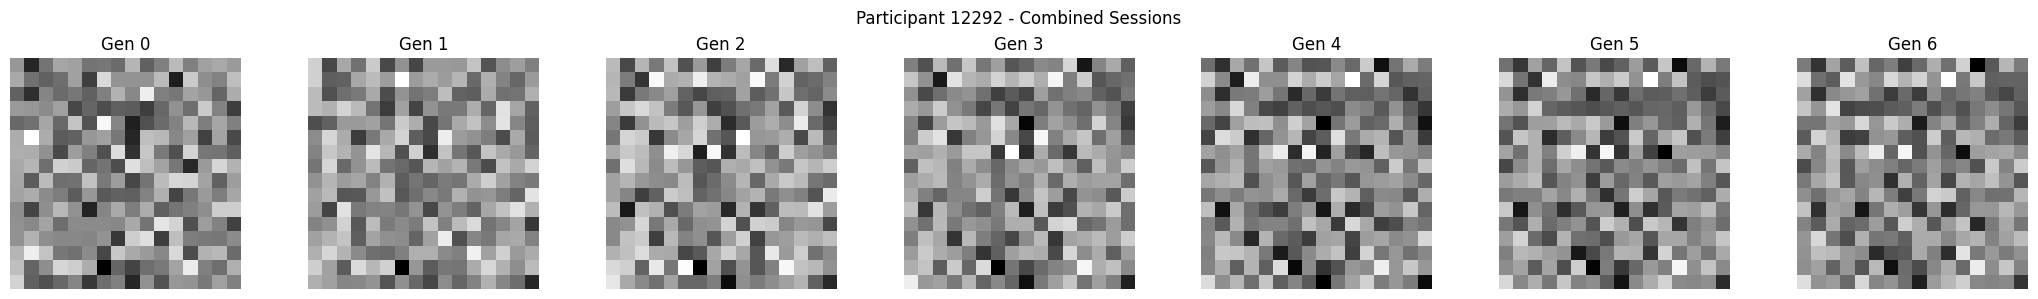


Visualizing Participant 13564


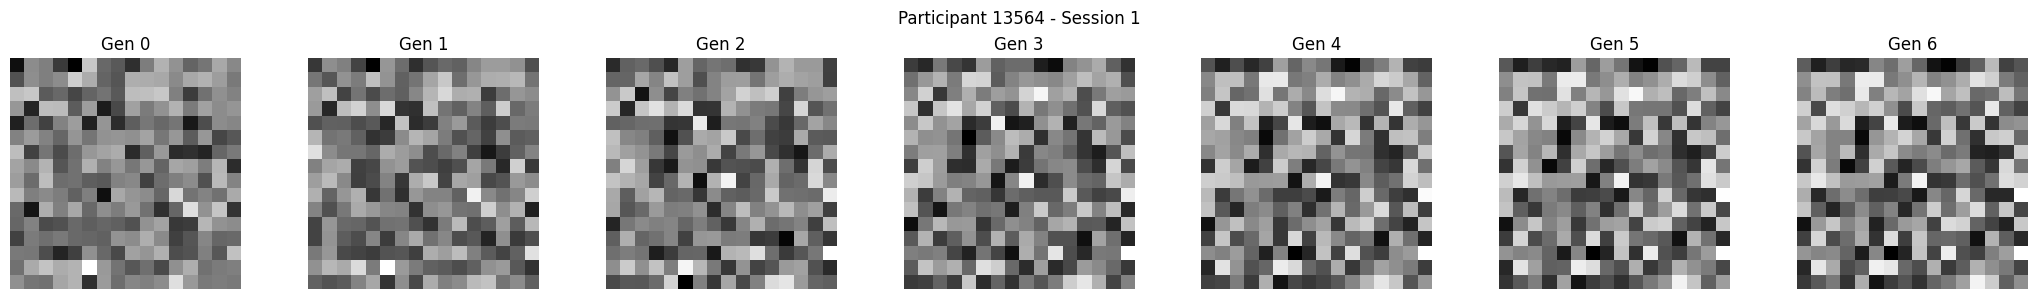

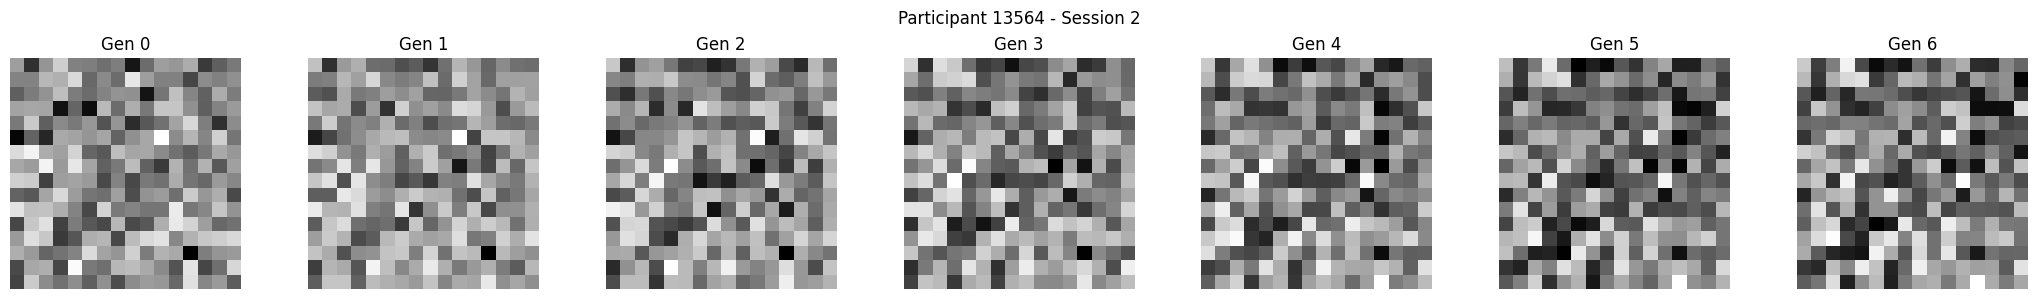

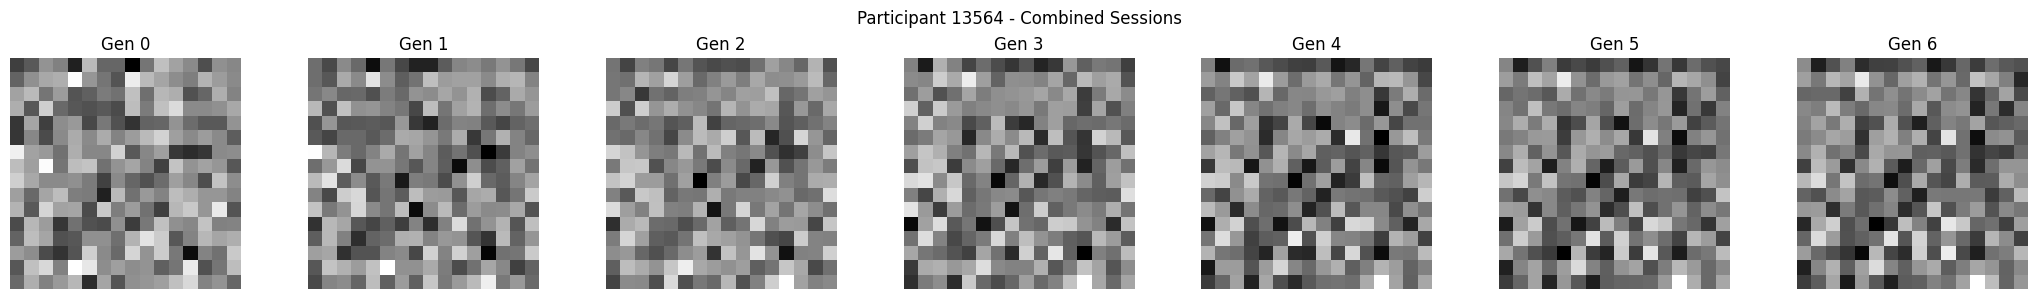


Visualizing Participant 12286


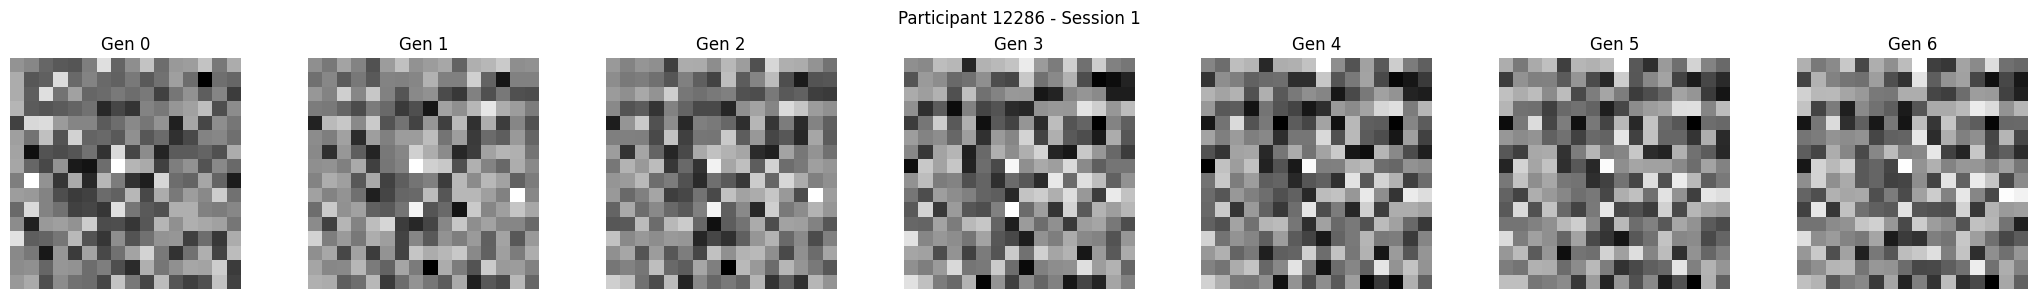

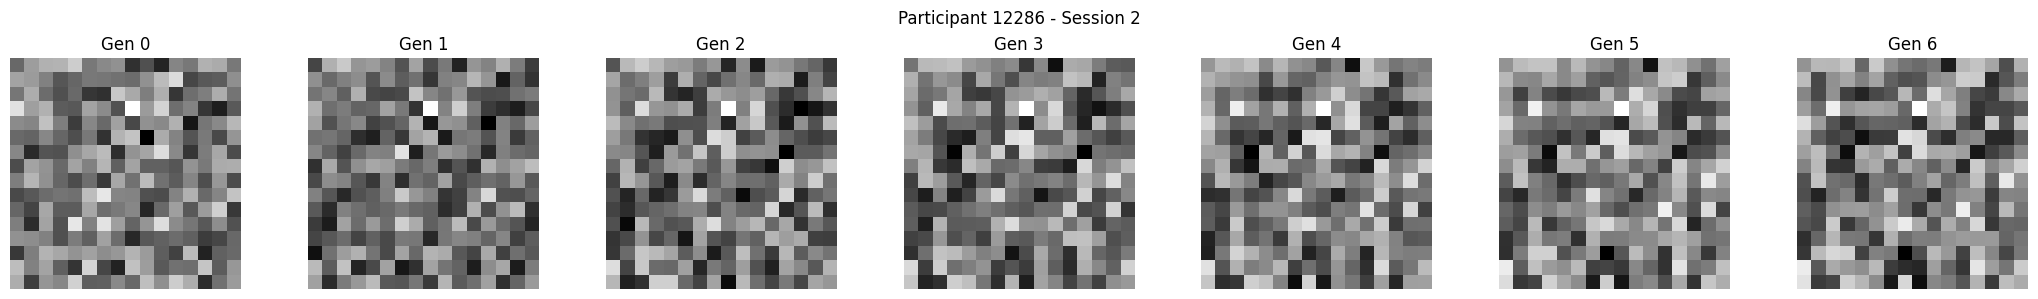

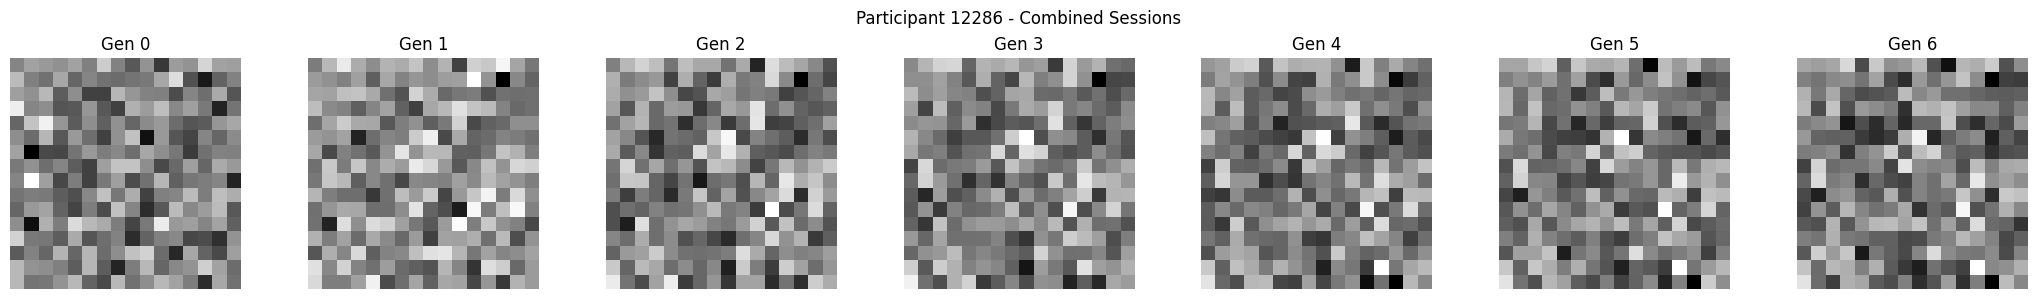


Visualizing Participant 12451


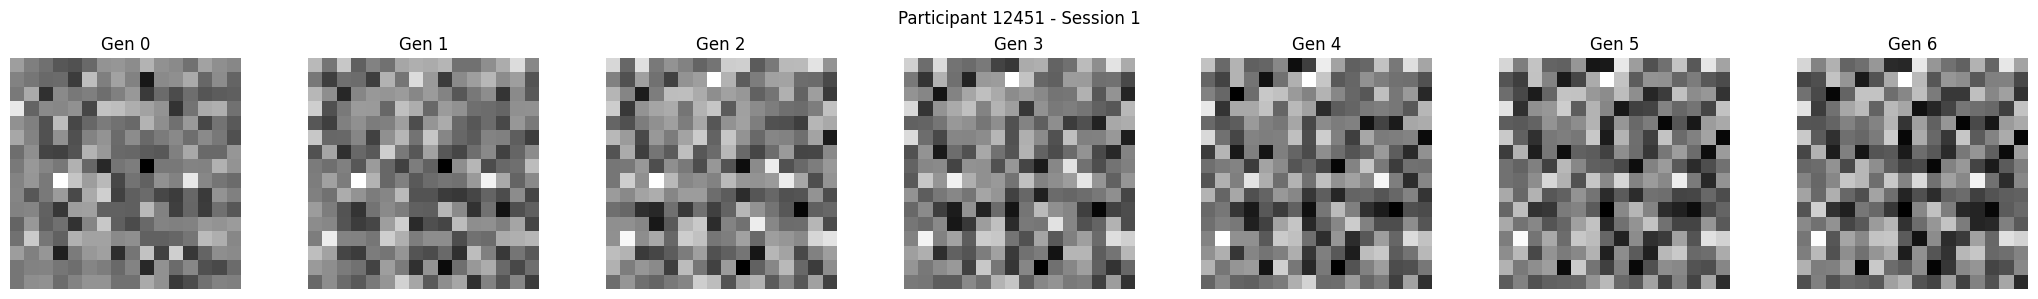

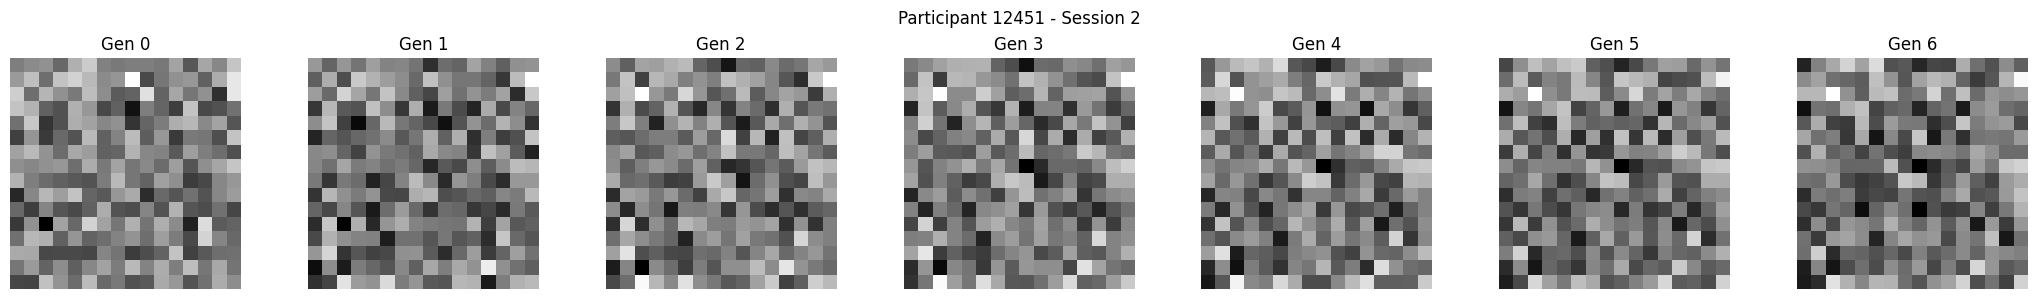

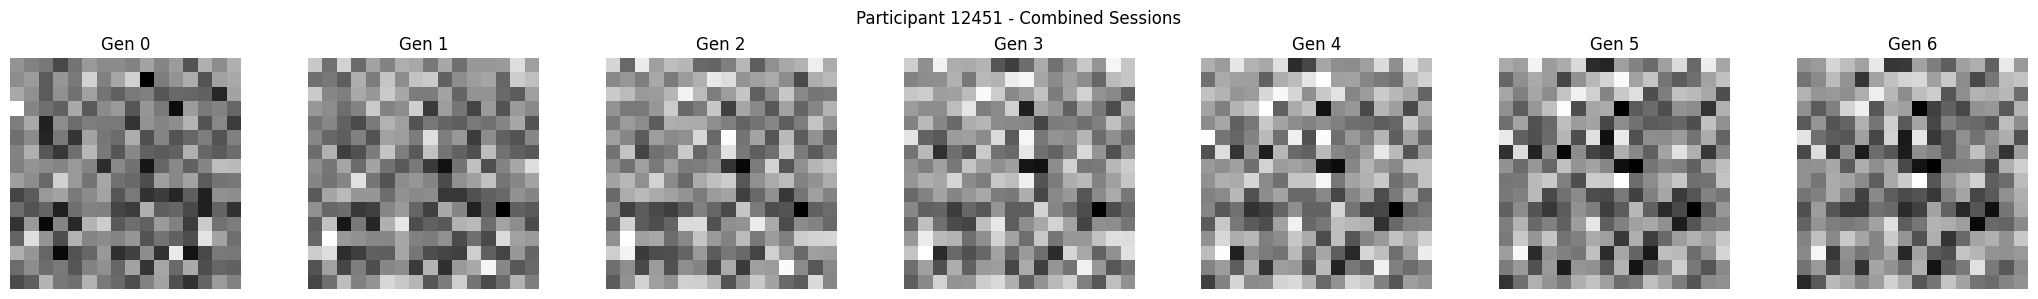


Visualizing Participant 14215


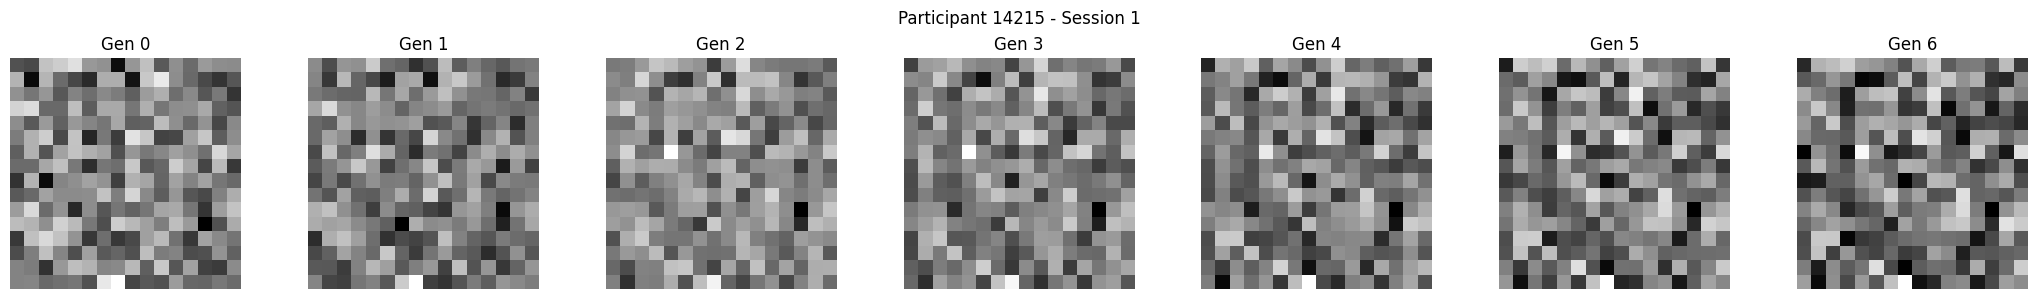

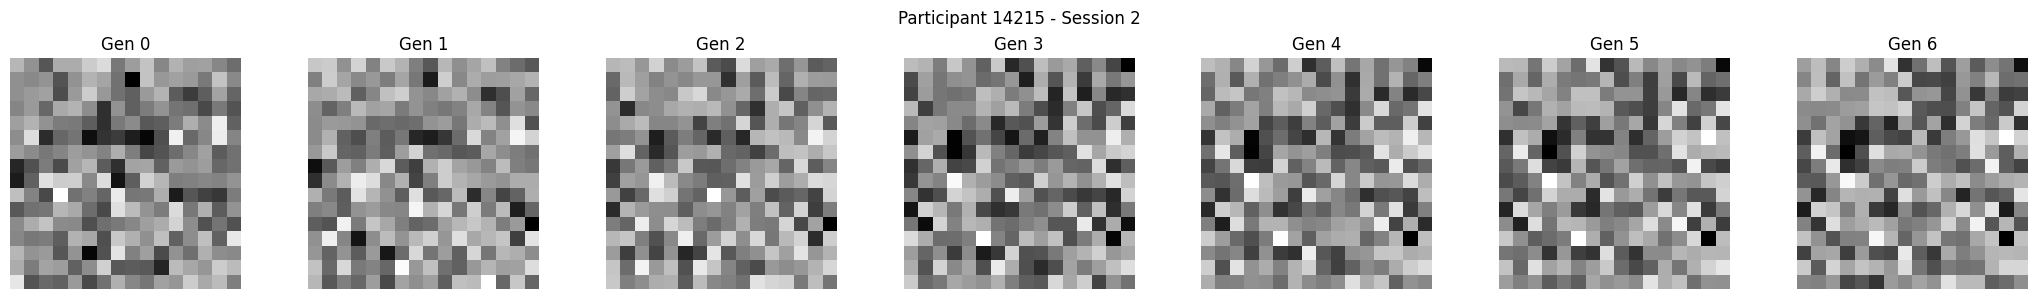

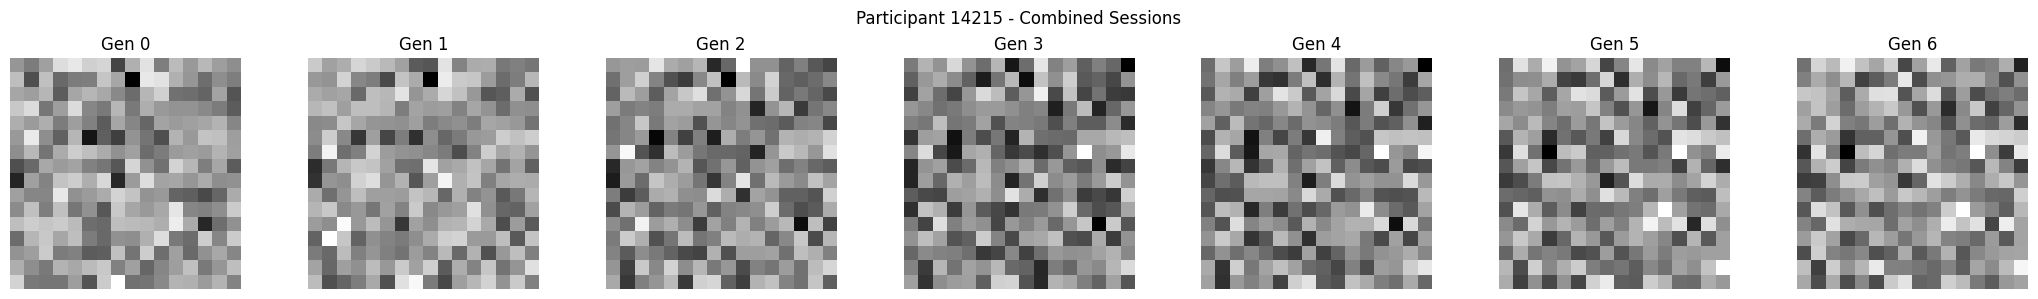


Visualizing Participant 11932


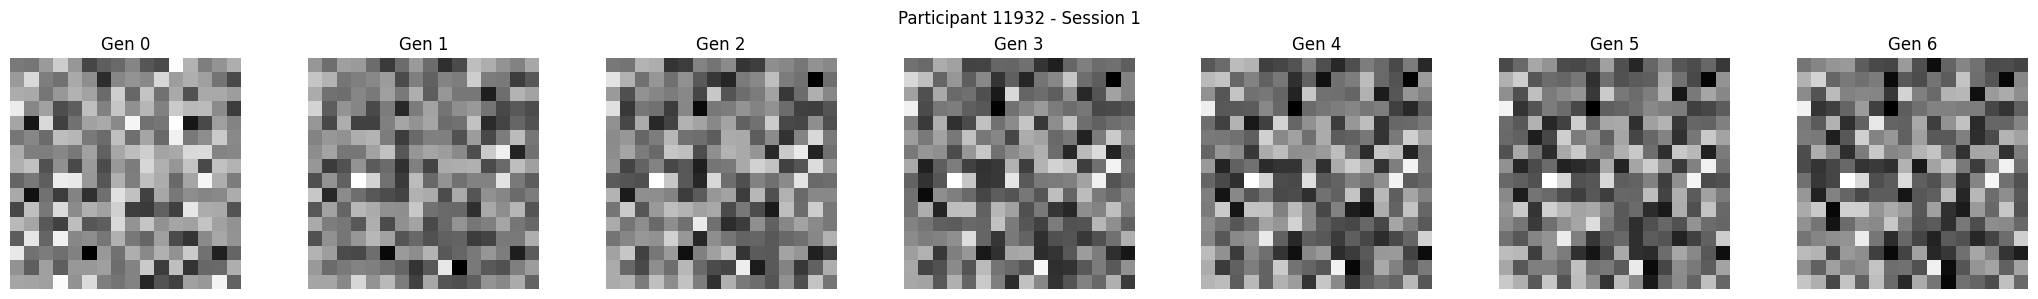

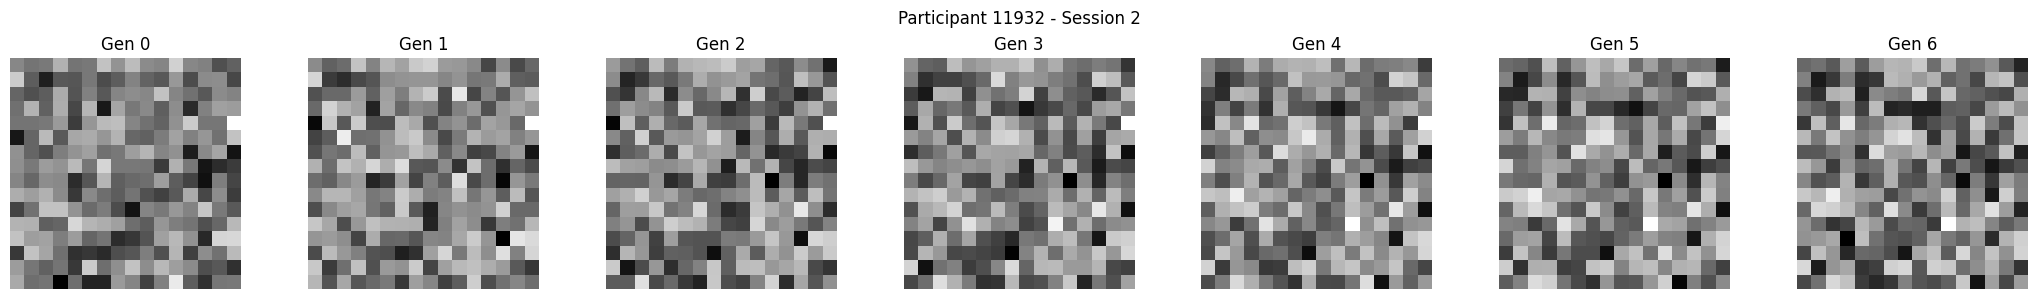

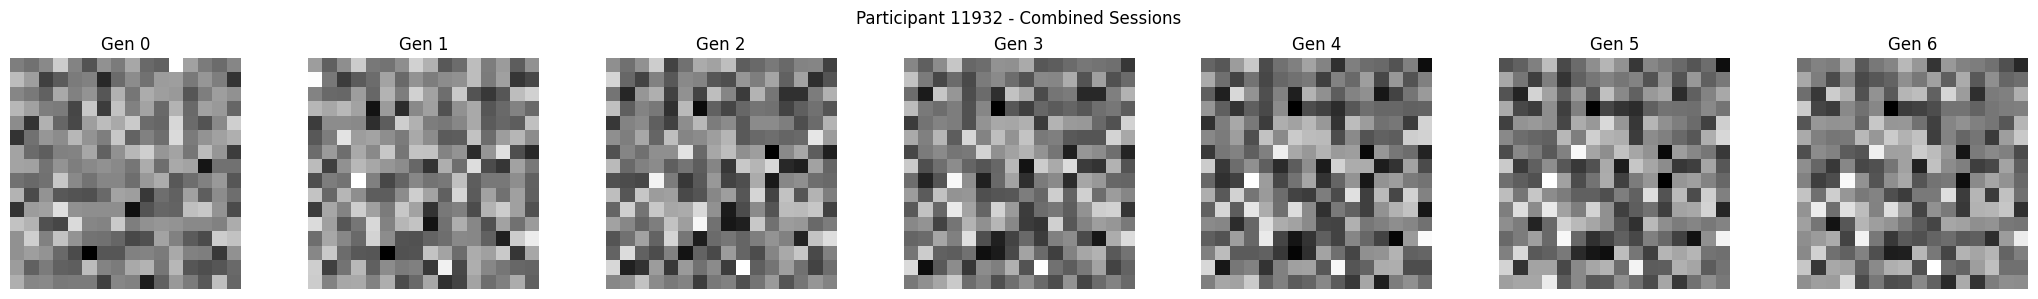


Visualizing Participant 12682


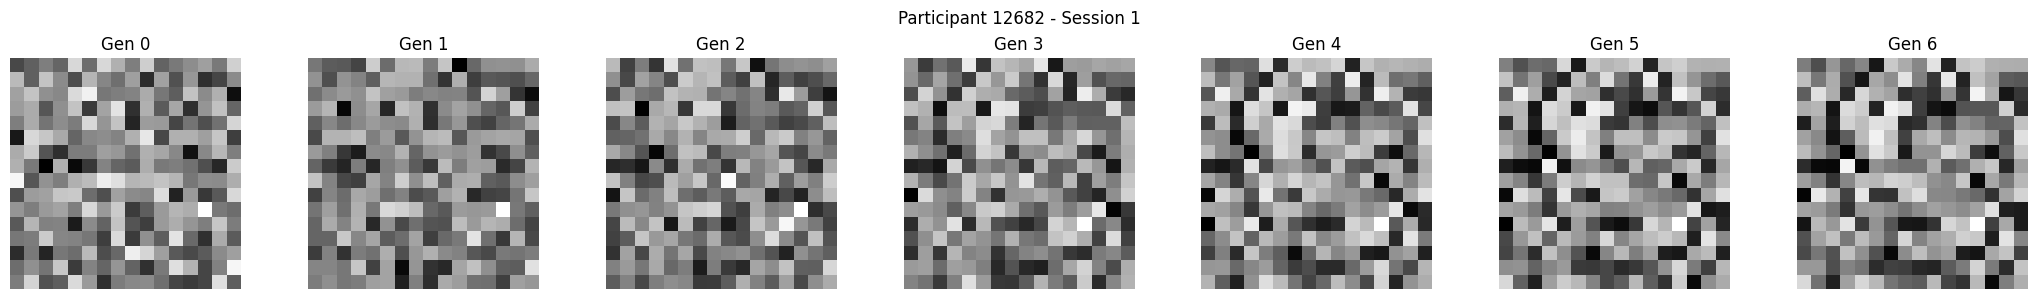

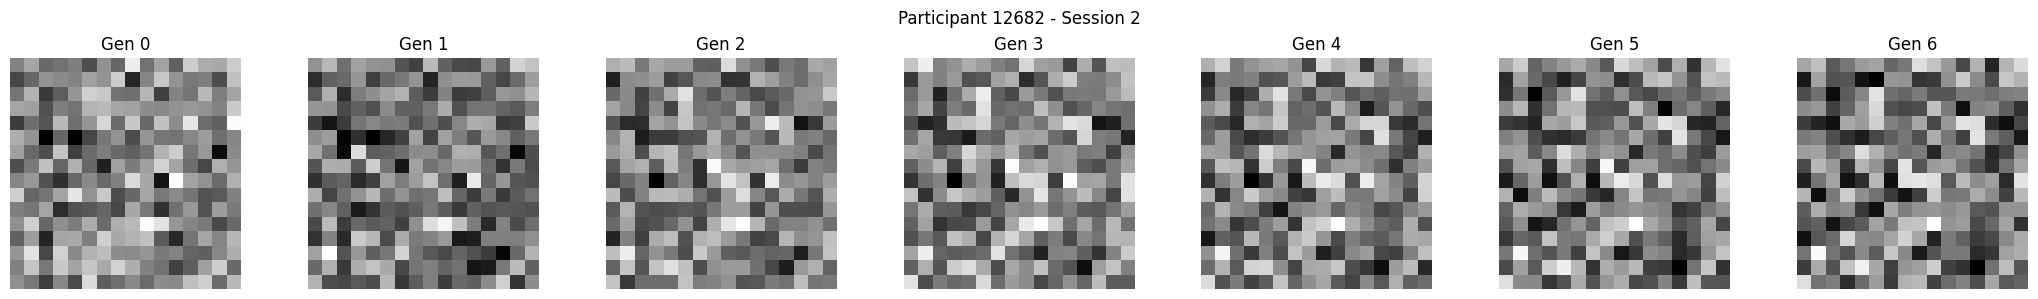

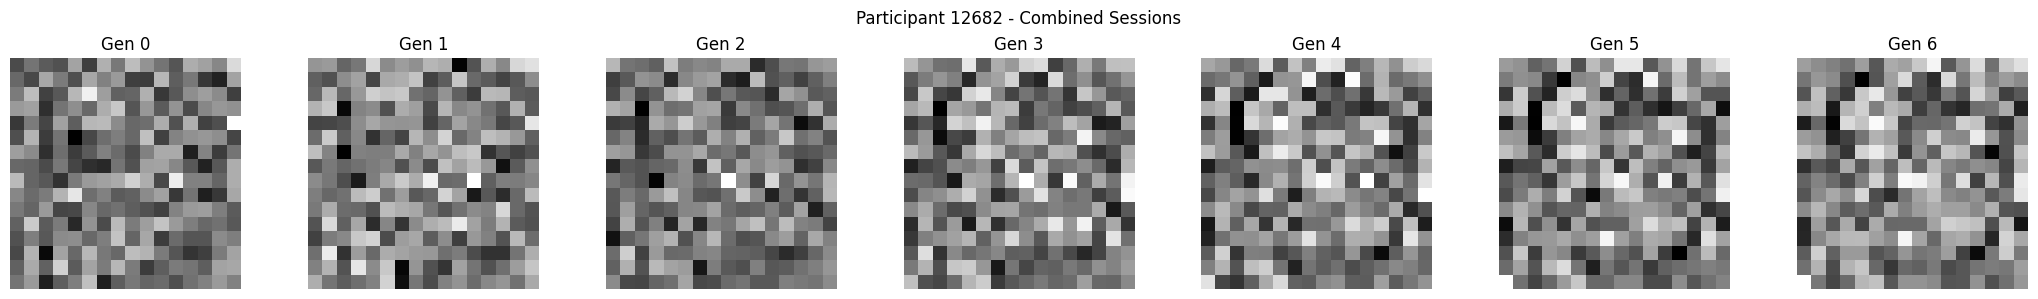


Visualizing Participant 11911


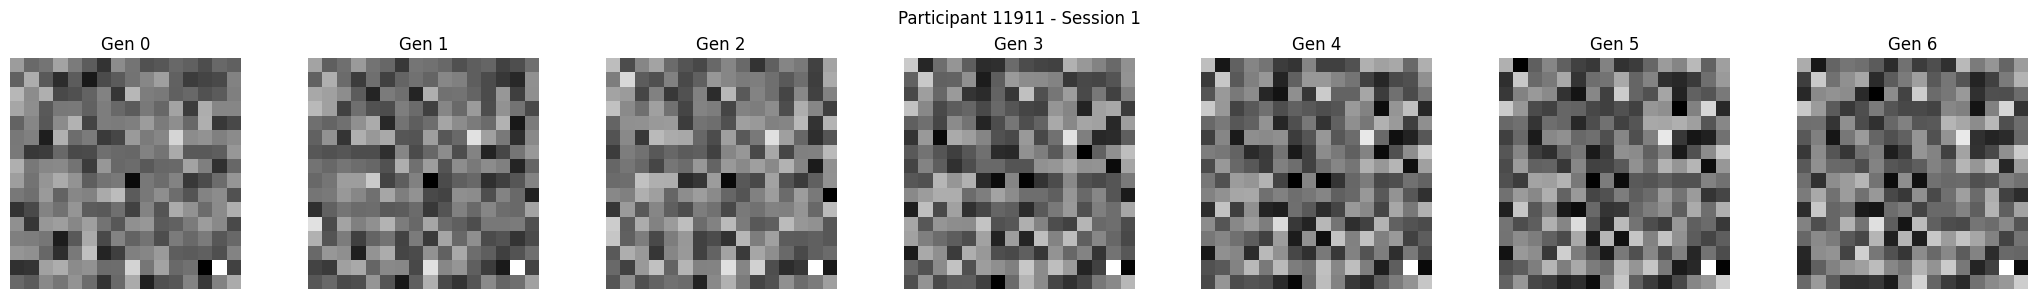

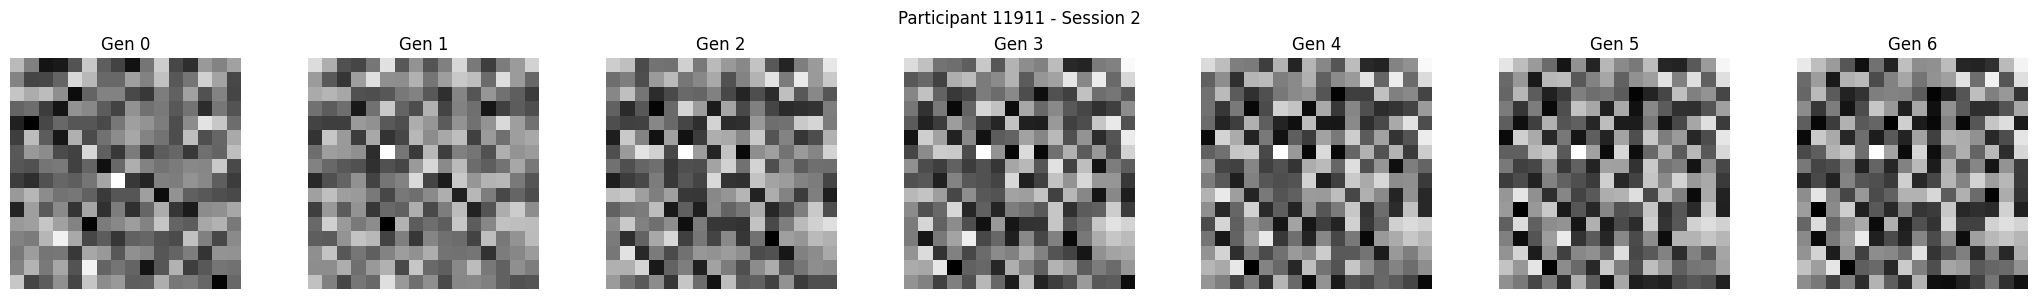

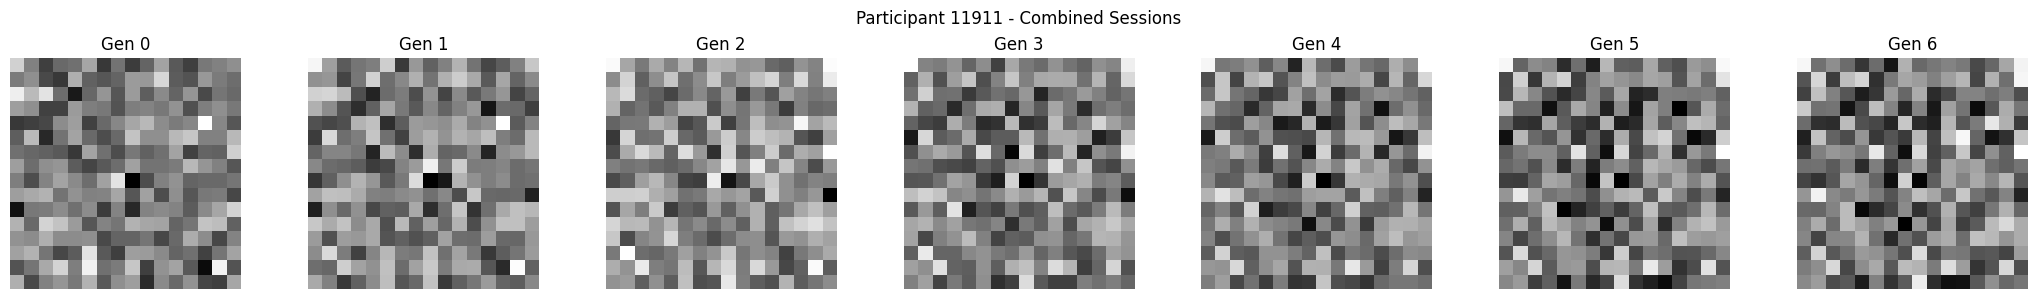


Visualizing Participant 14494


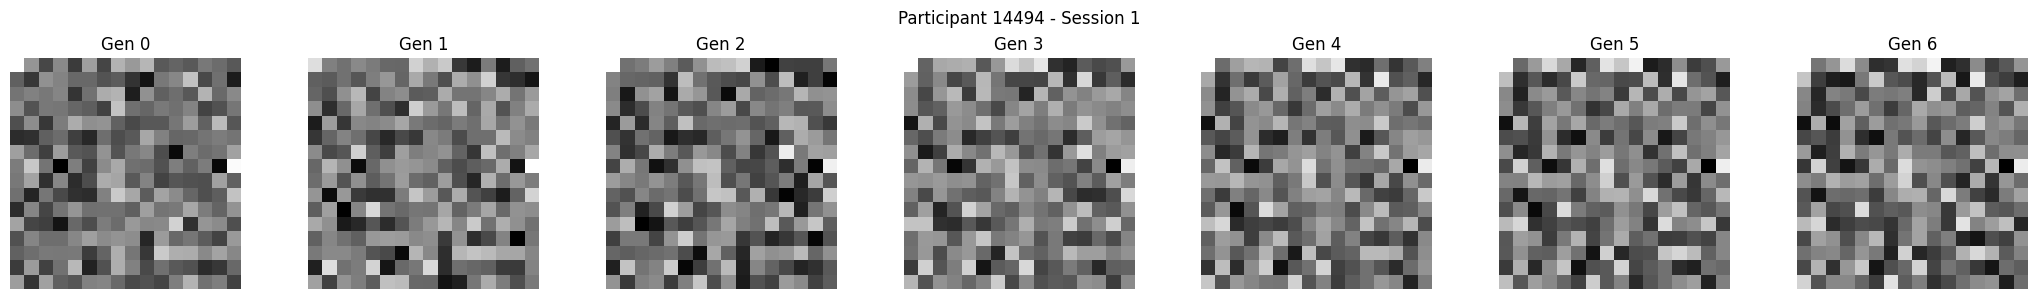

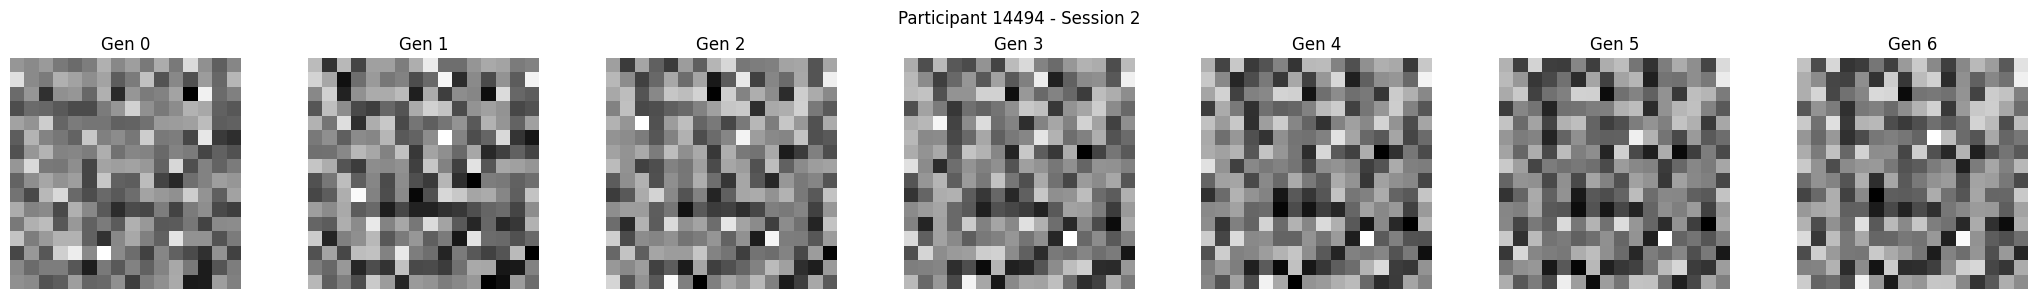

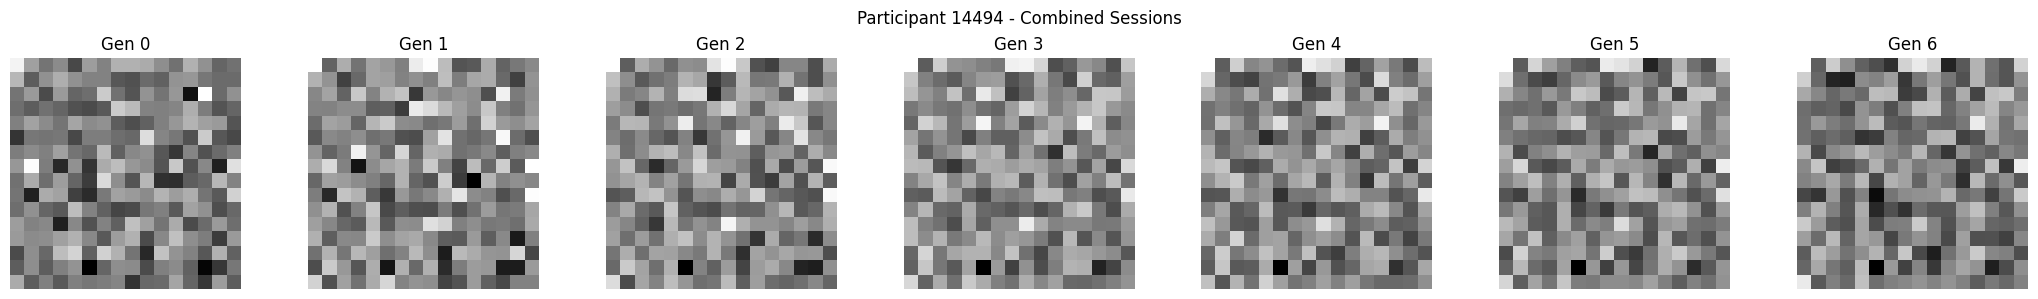


Visualizing Participant 15052


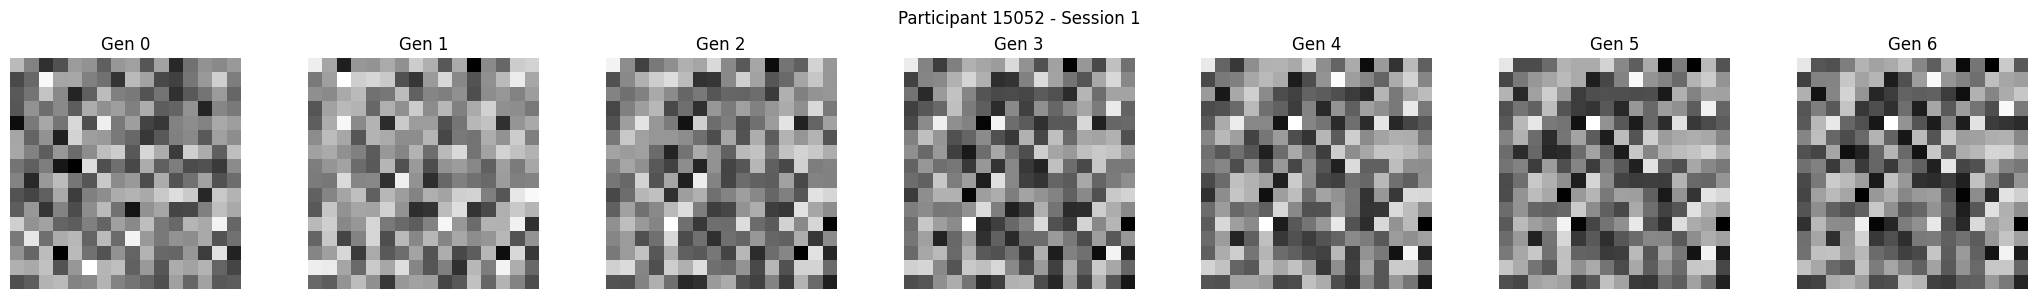

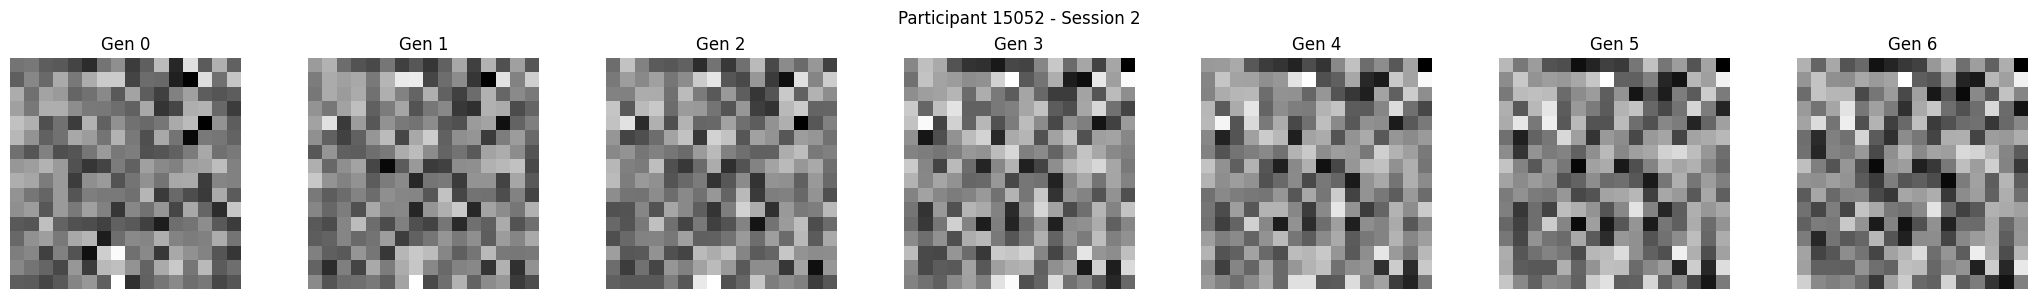

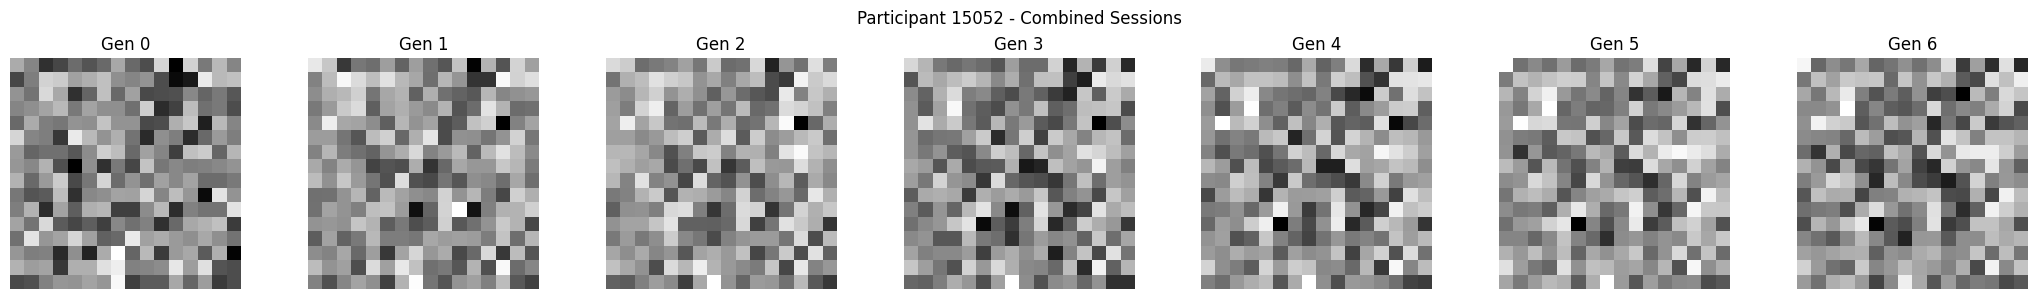


Visualizing Participant 13102


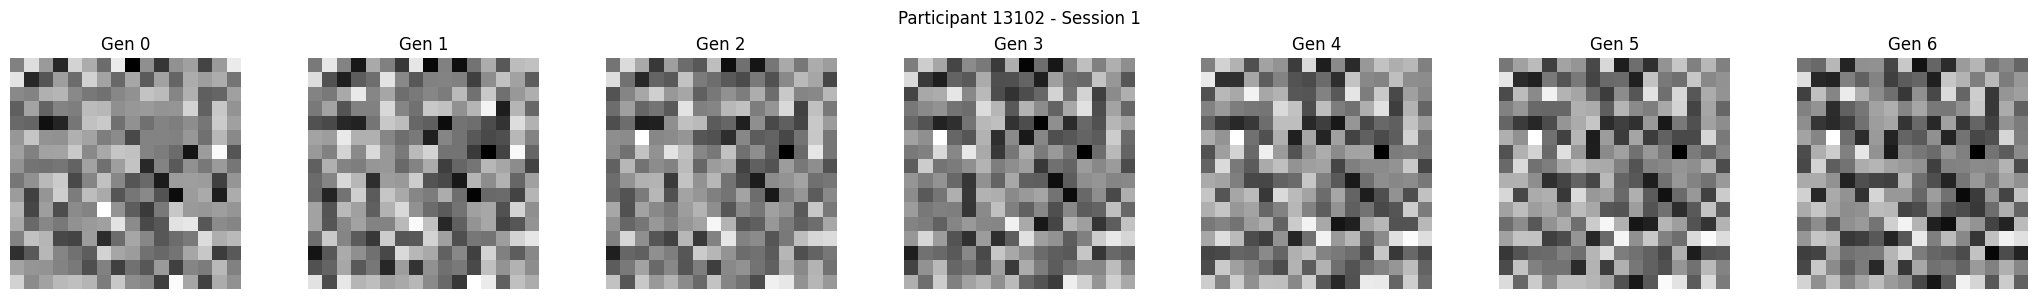

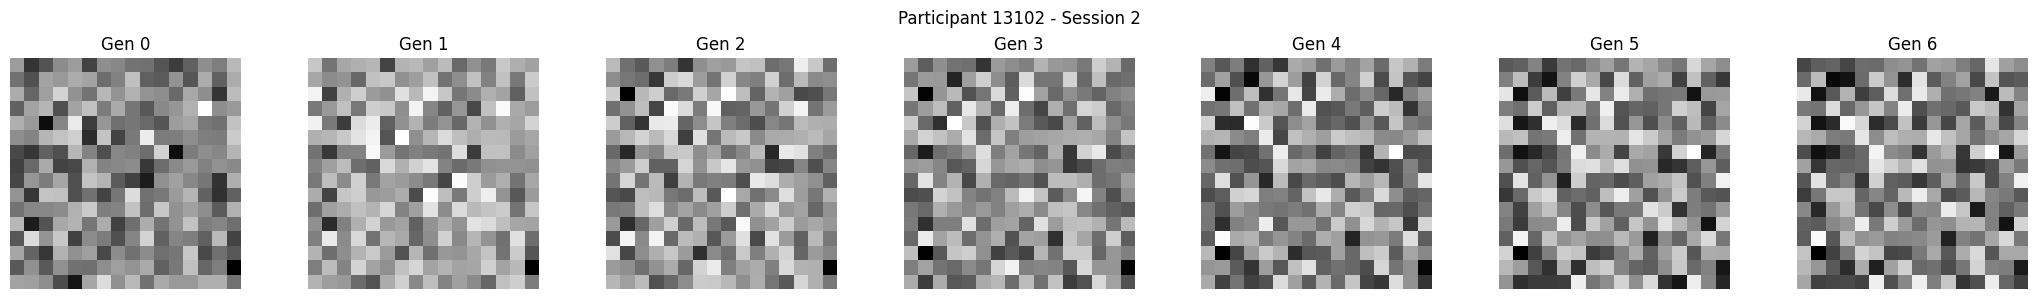

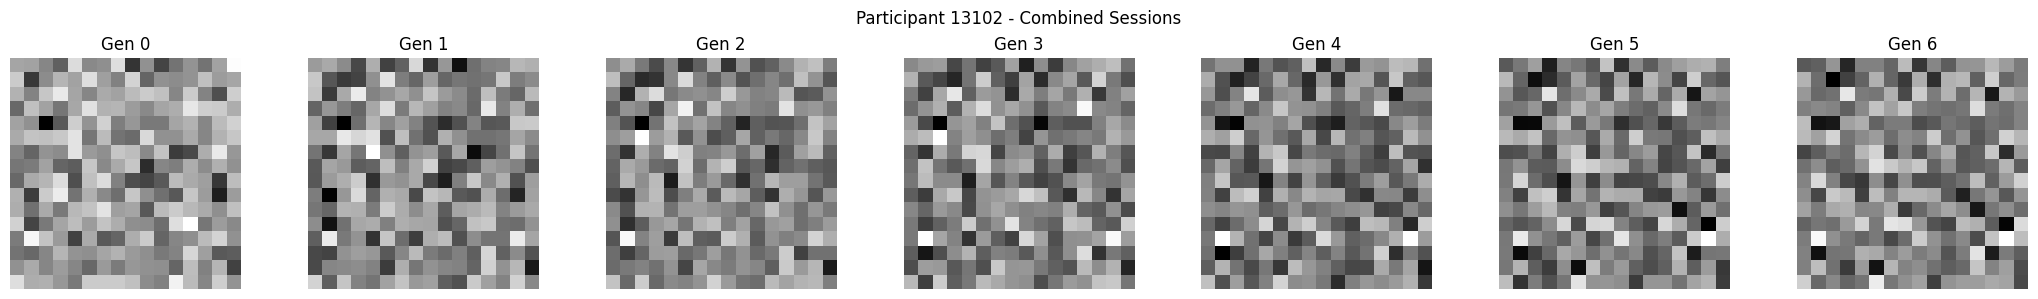


Visualizing Participant 13075


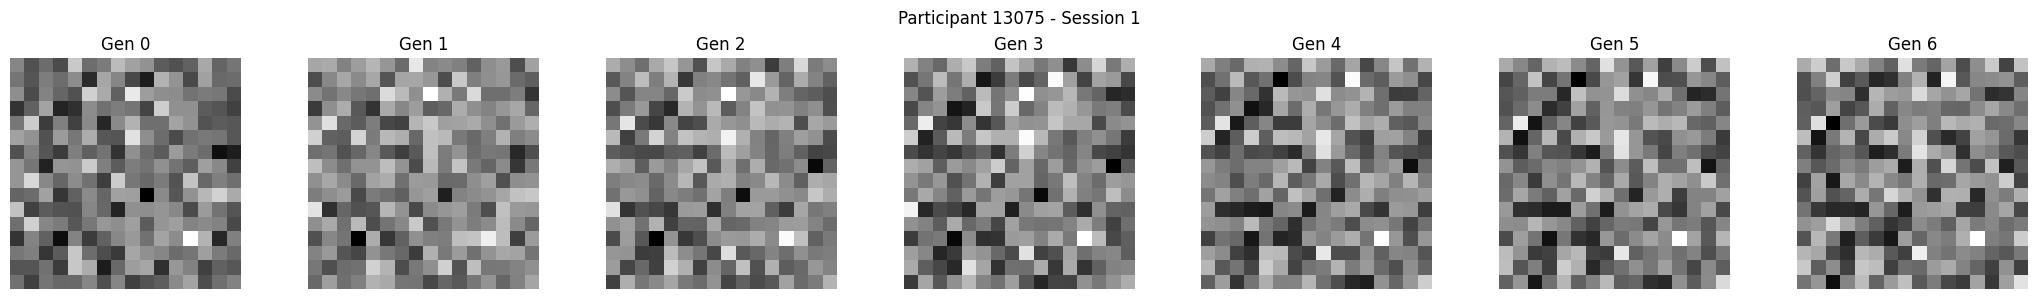

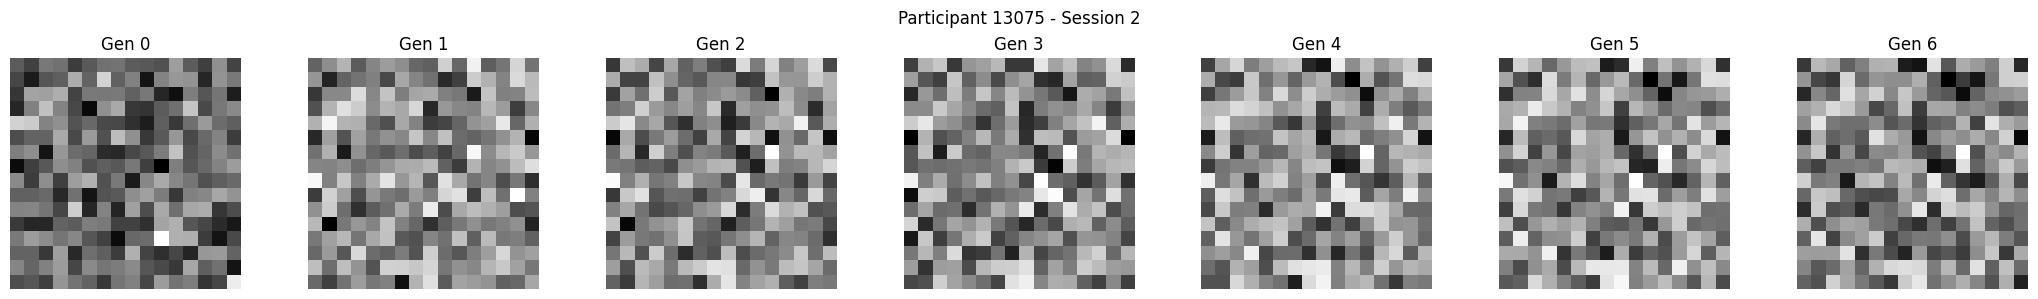

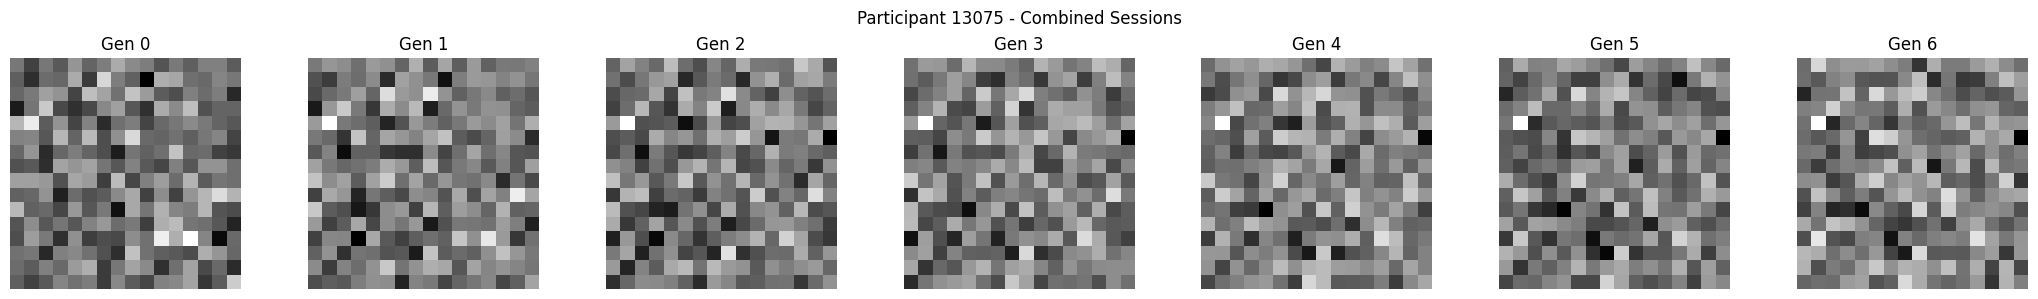


Visualizing Participant 12700


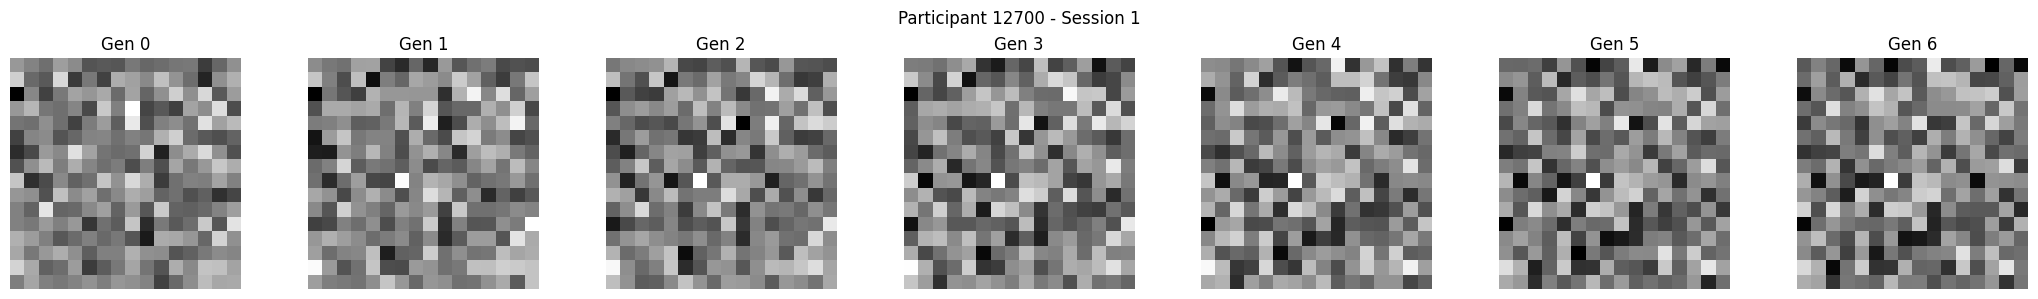

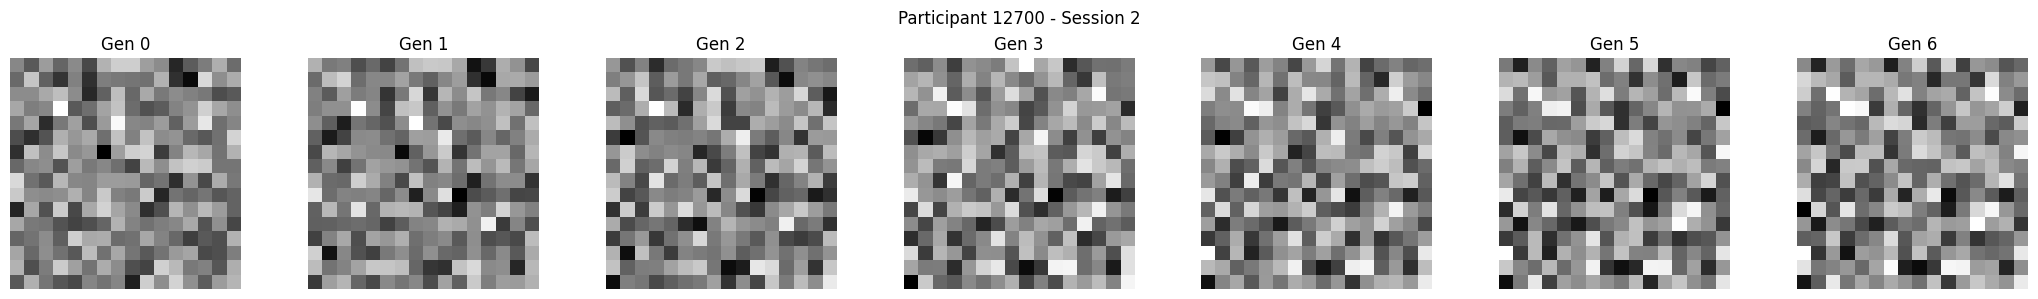

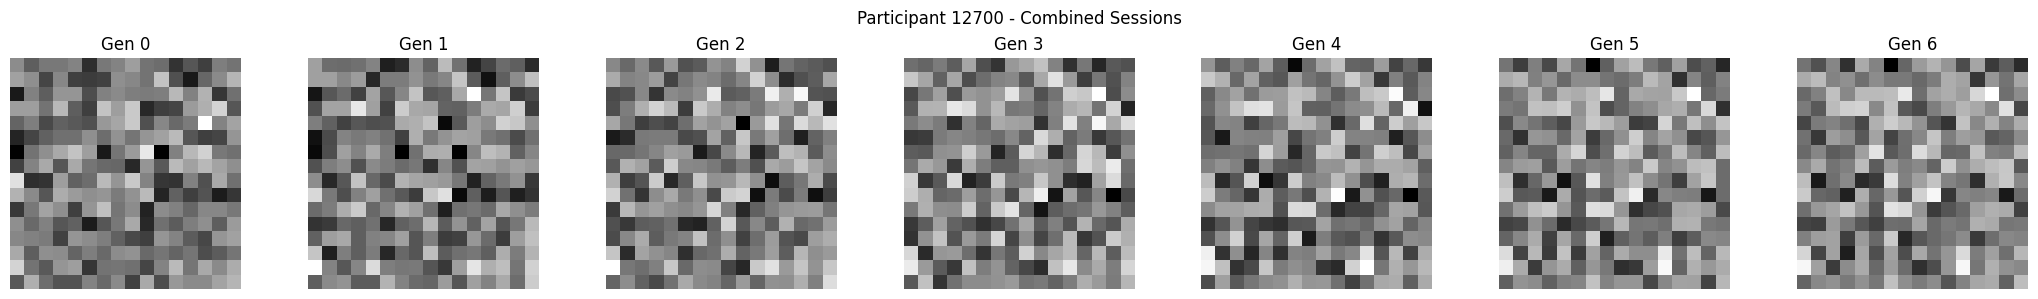


Visualizing Participant 12028


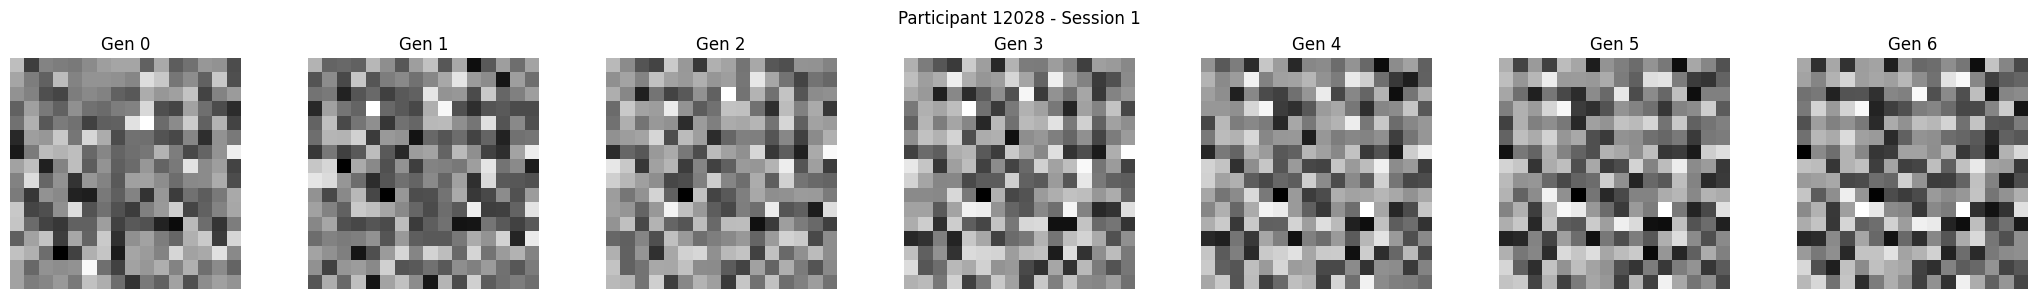

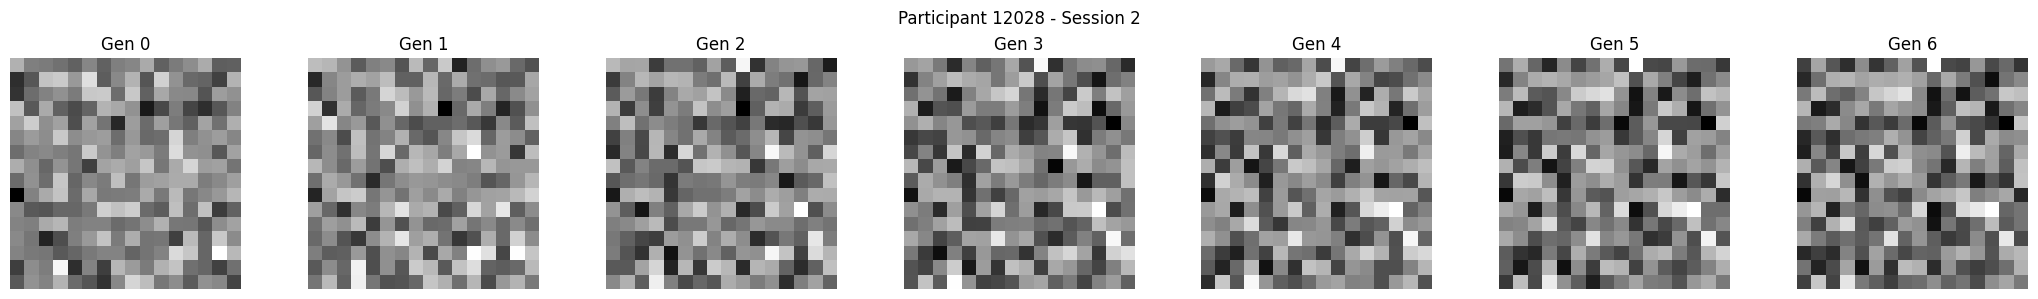

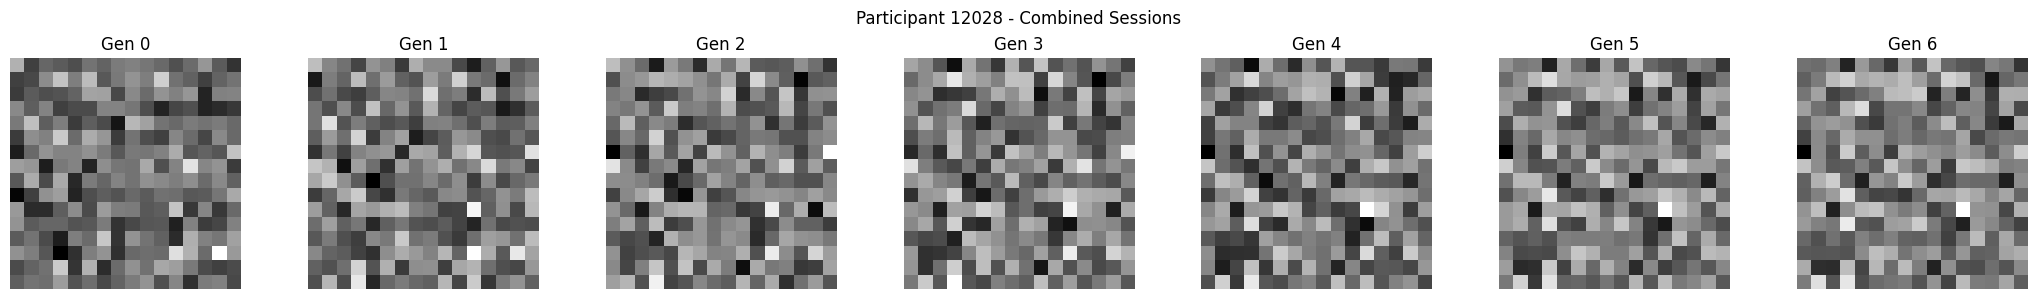


Visualizing Participant 12262


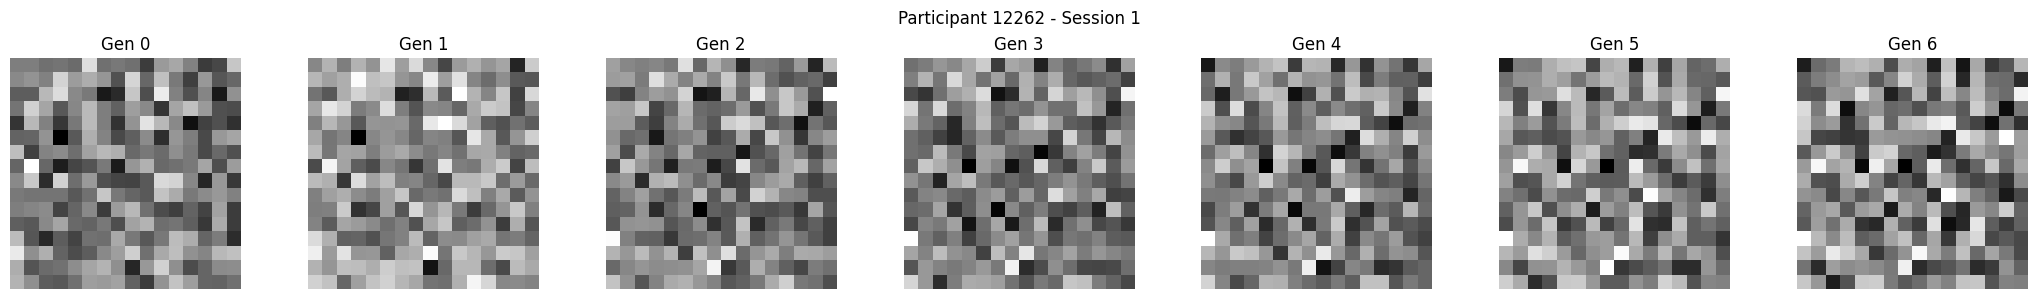

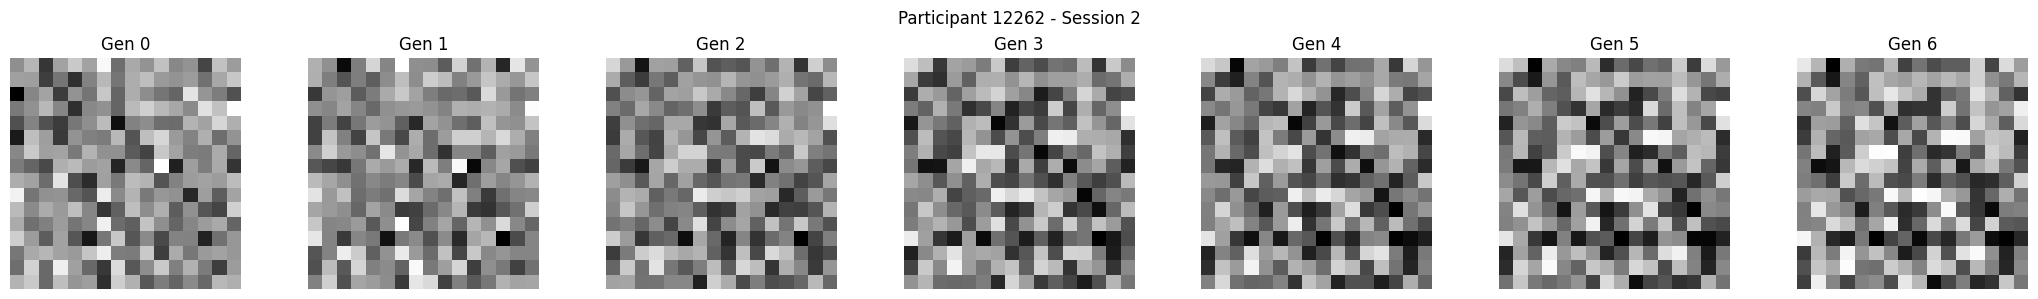

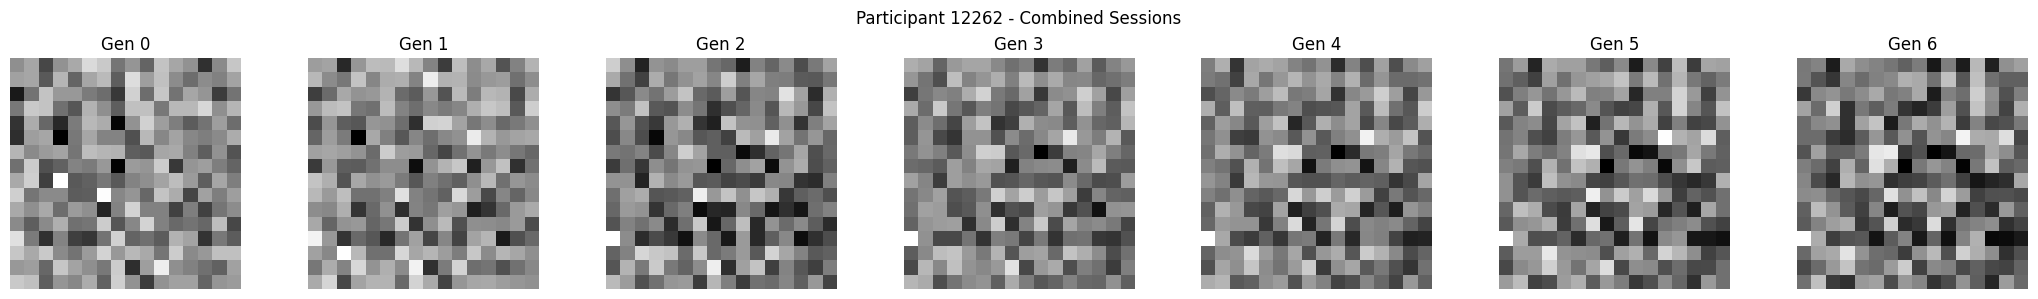


Visualizing Participant 12322


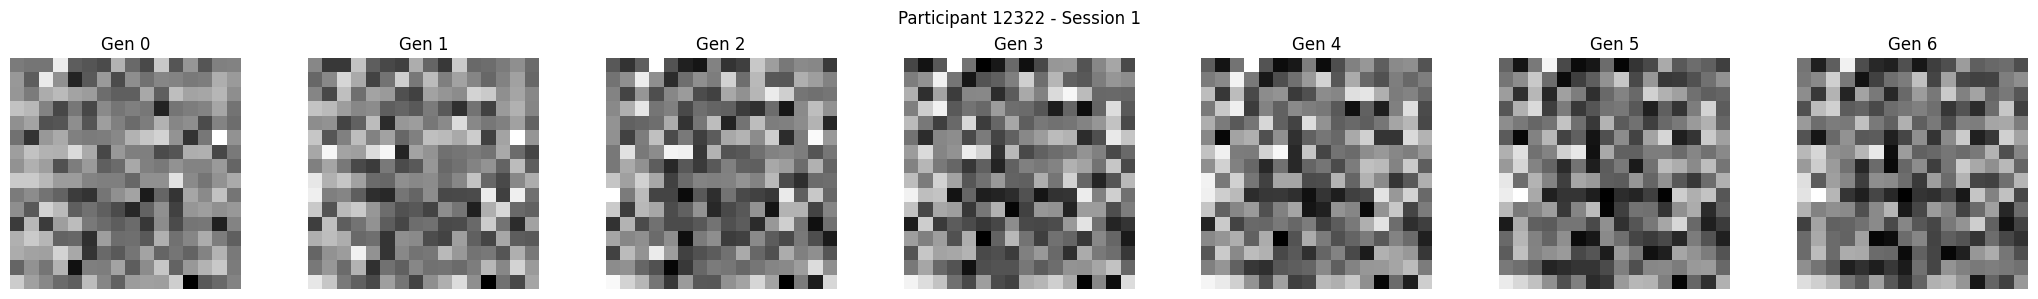

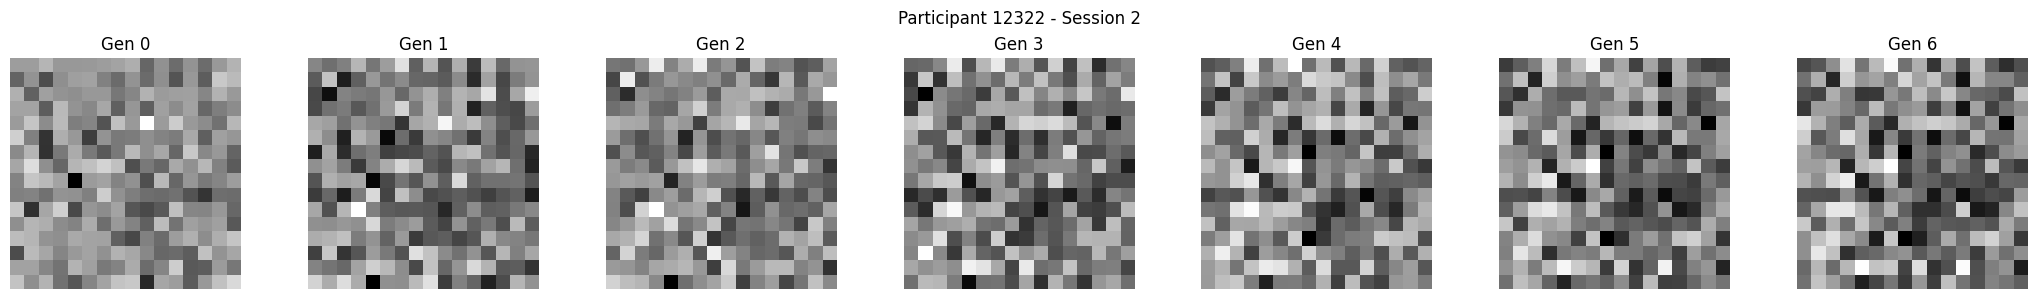

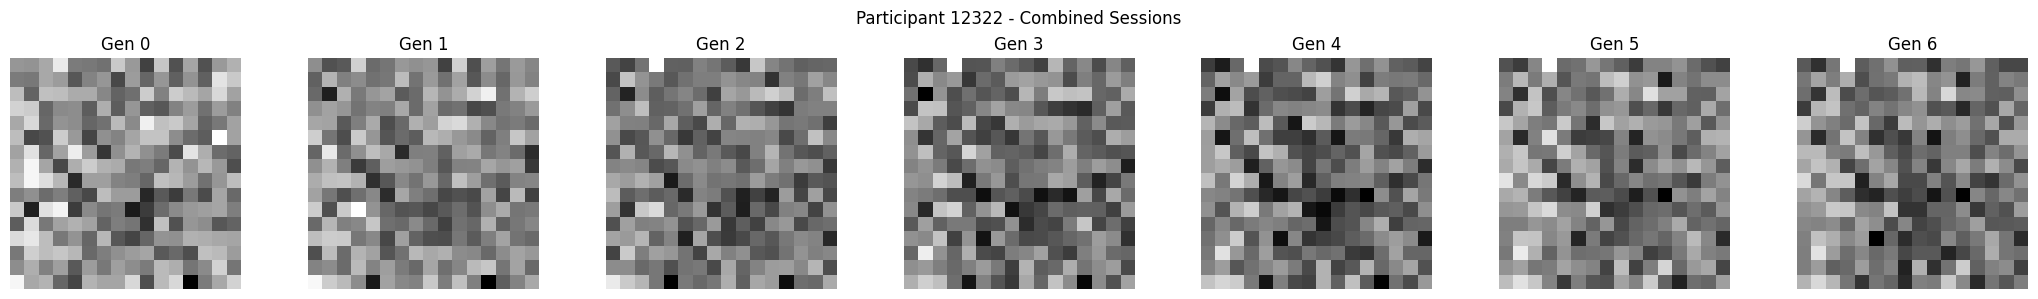


Visualizing Participant 13648


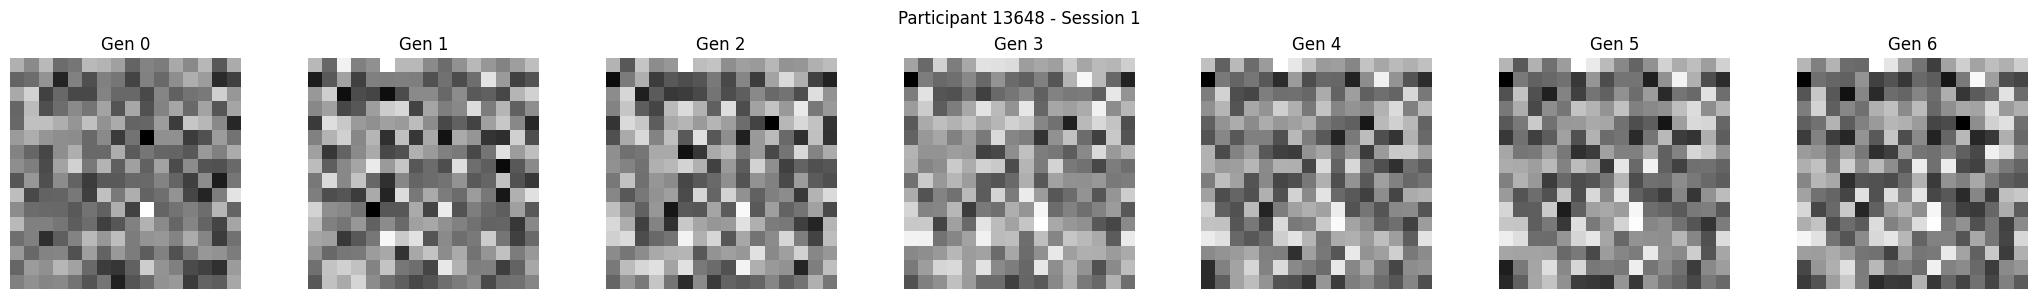

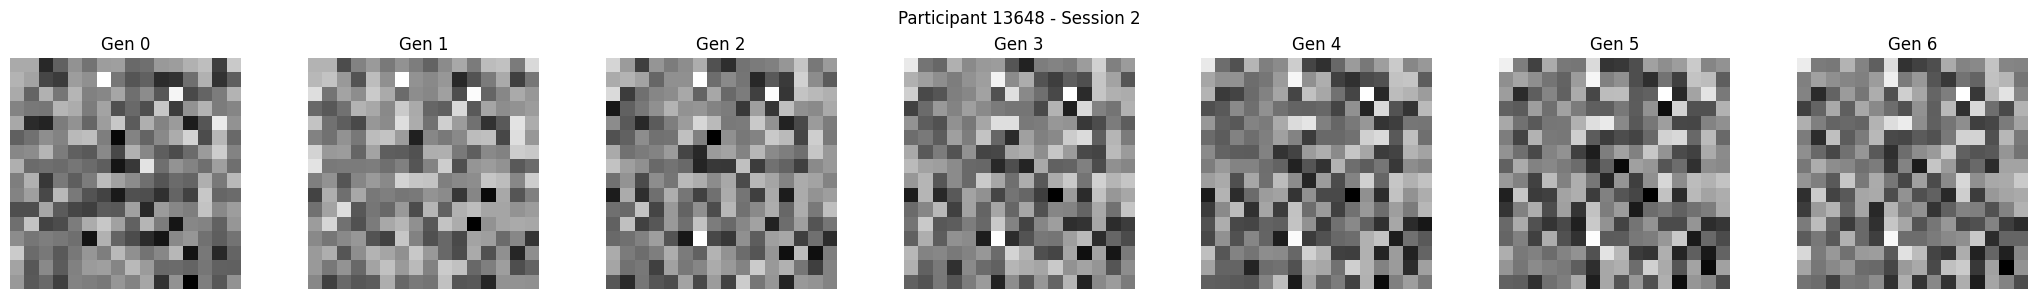

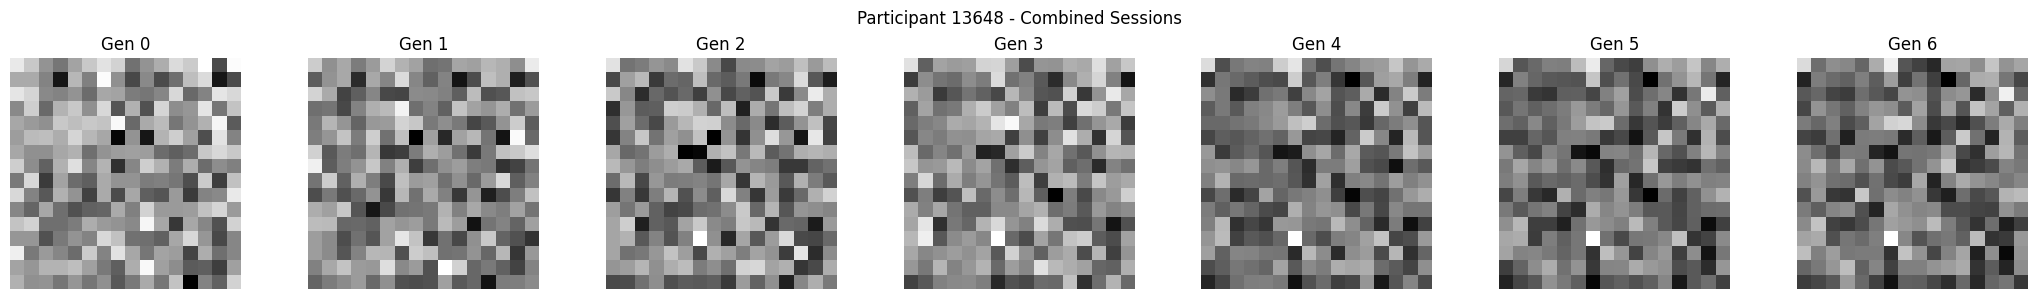


Visualizing Participant 12172


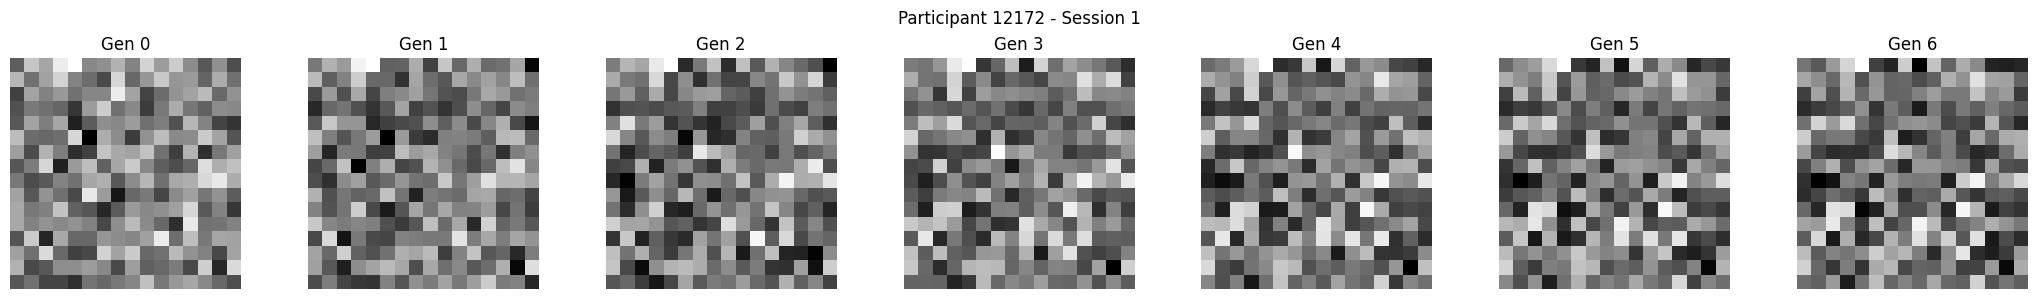

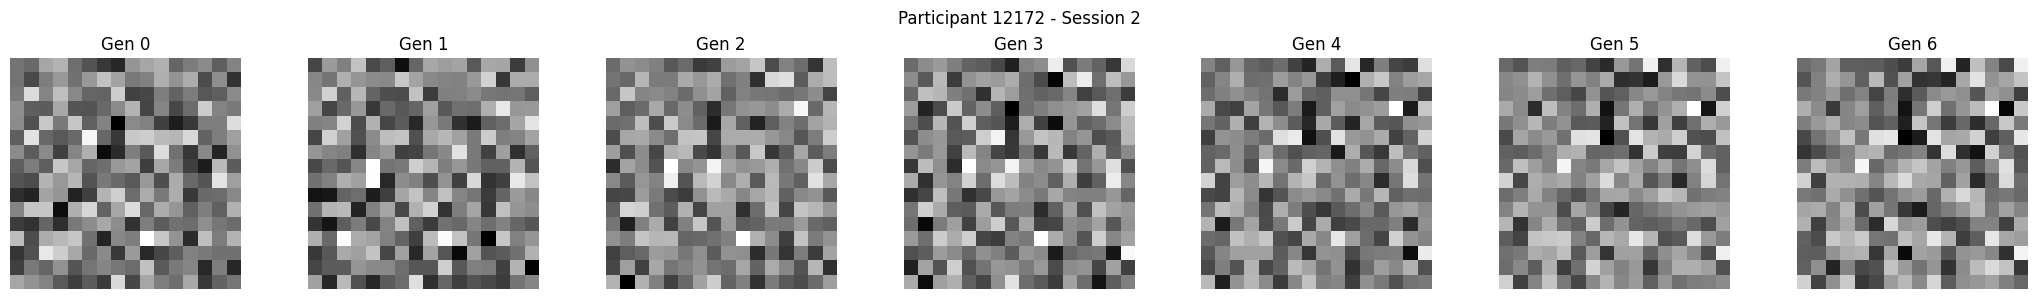

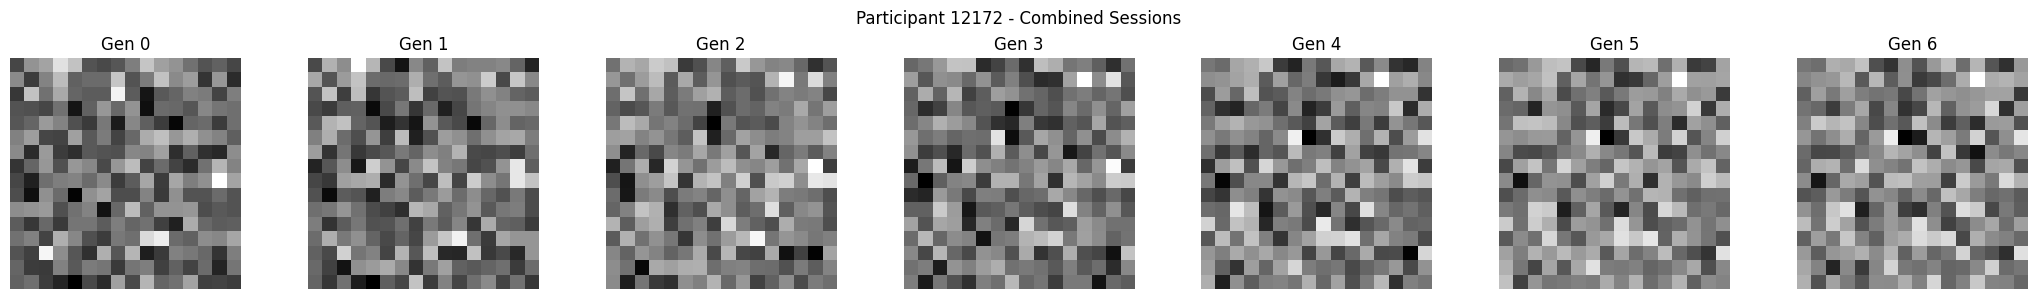


Visualizing Participant 13816


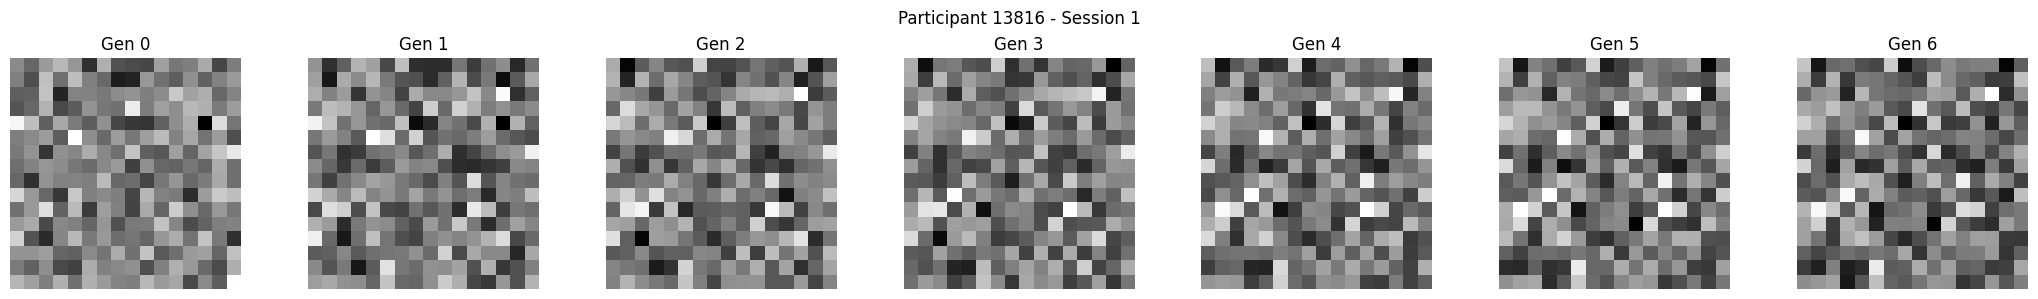

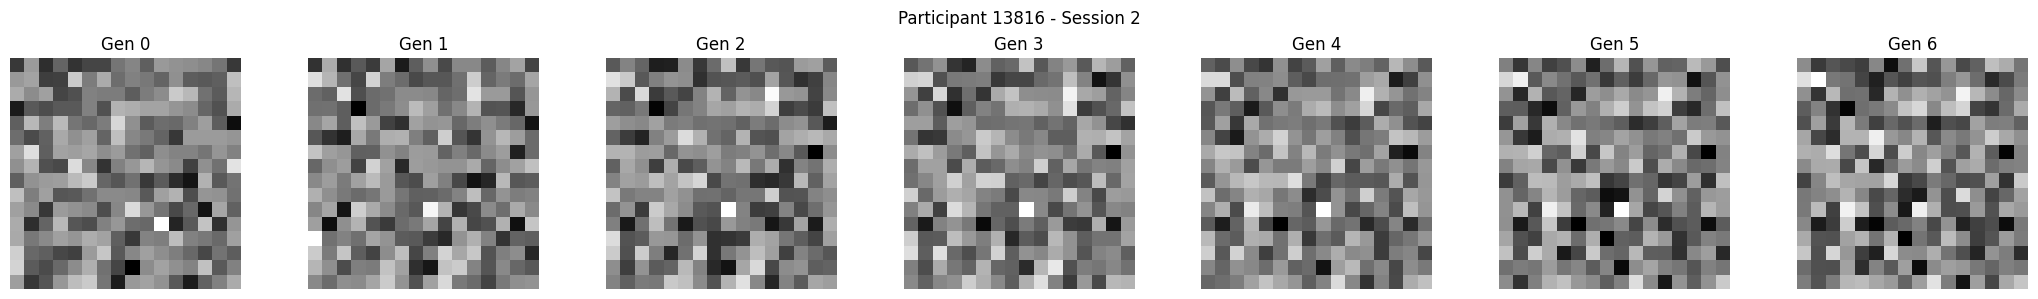

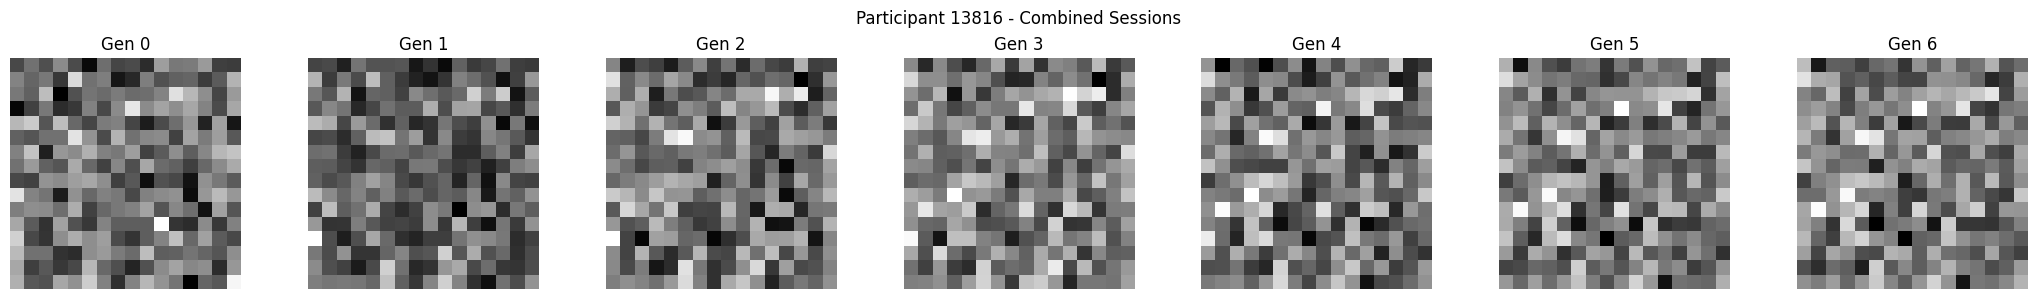


Visualizing Participant 14554


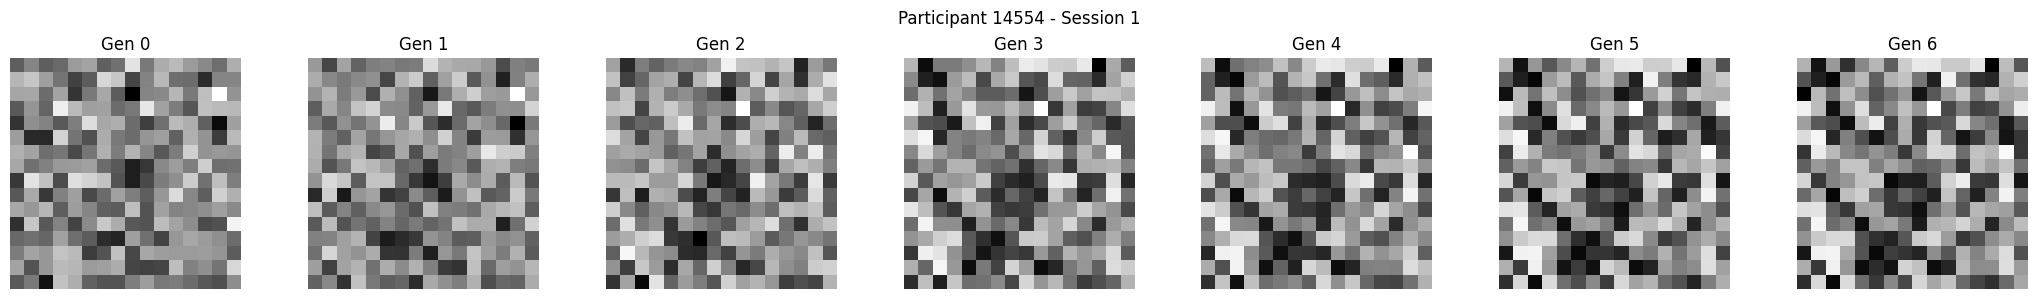

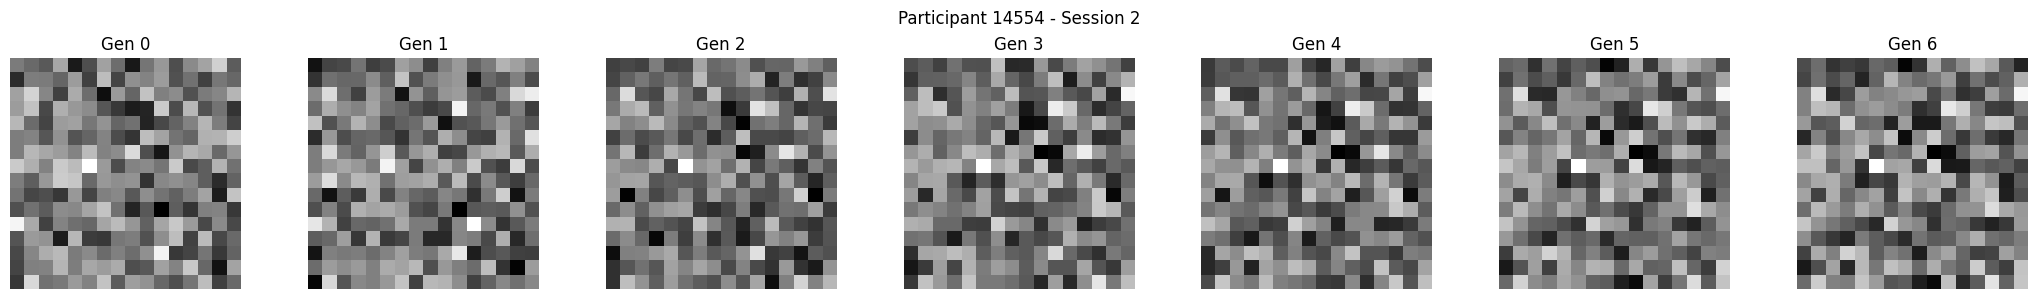

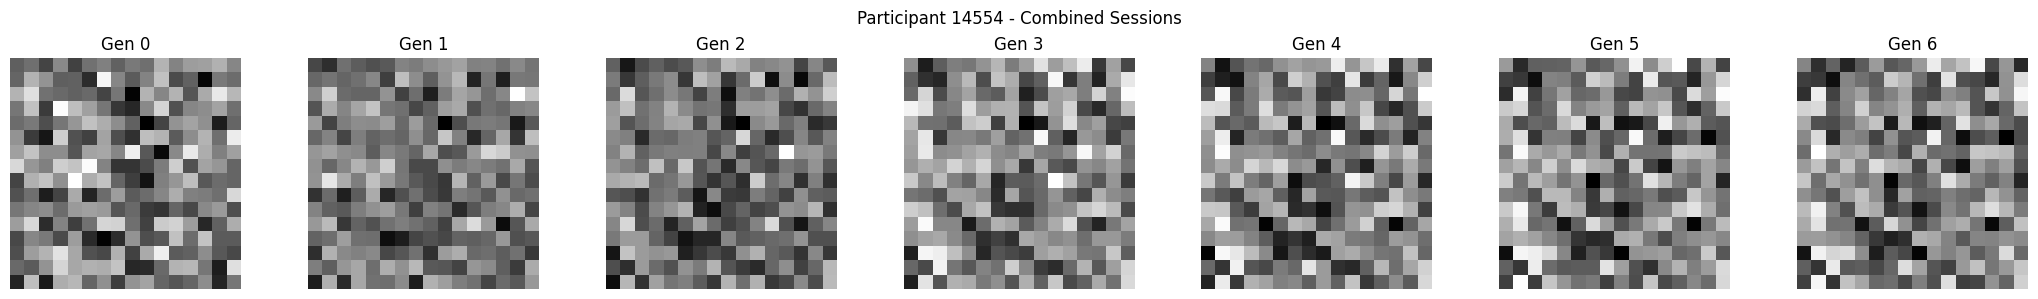


Visualizing Participant 12412


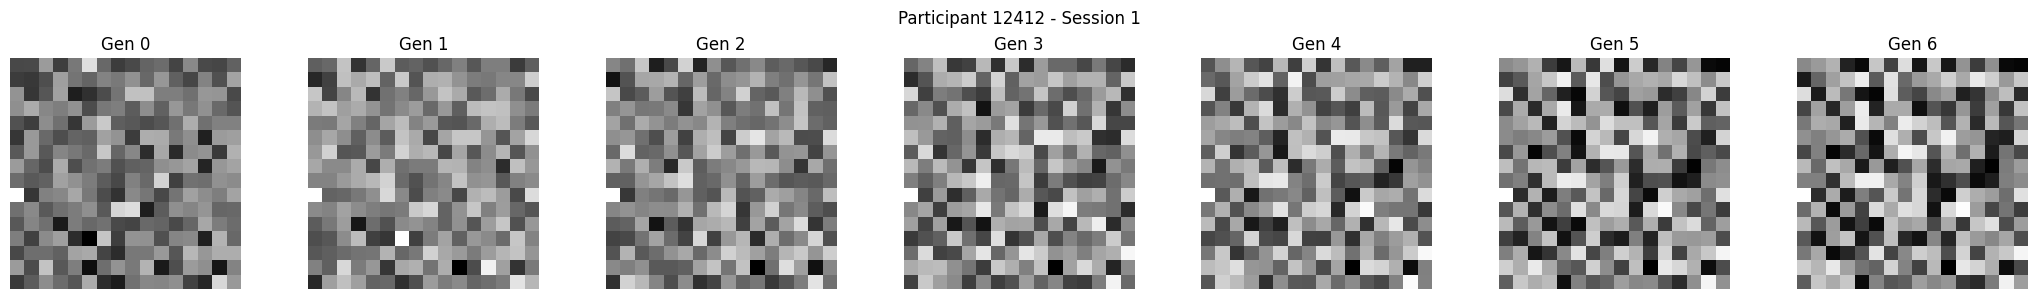

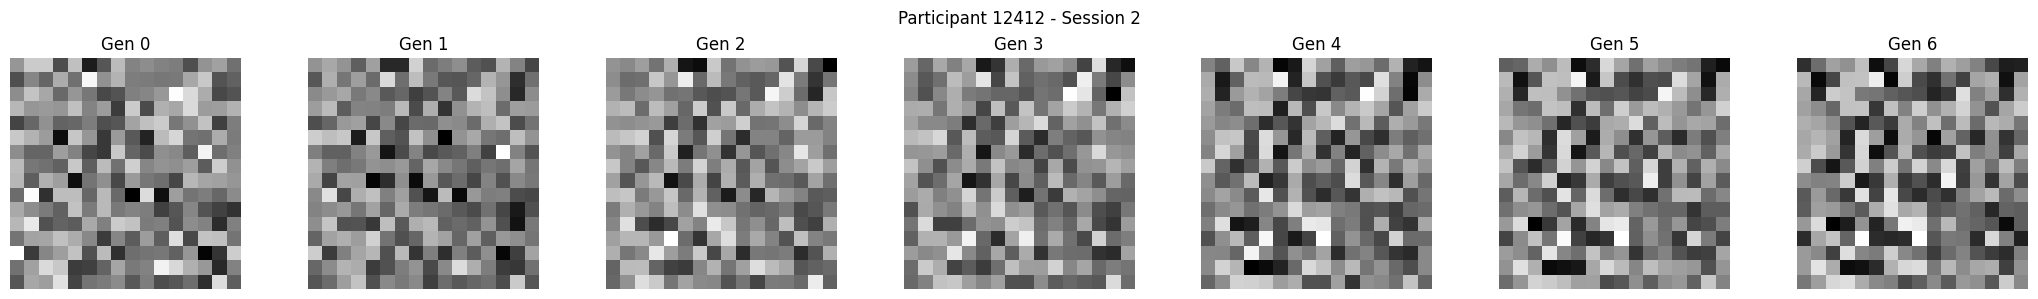

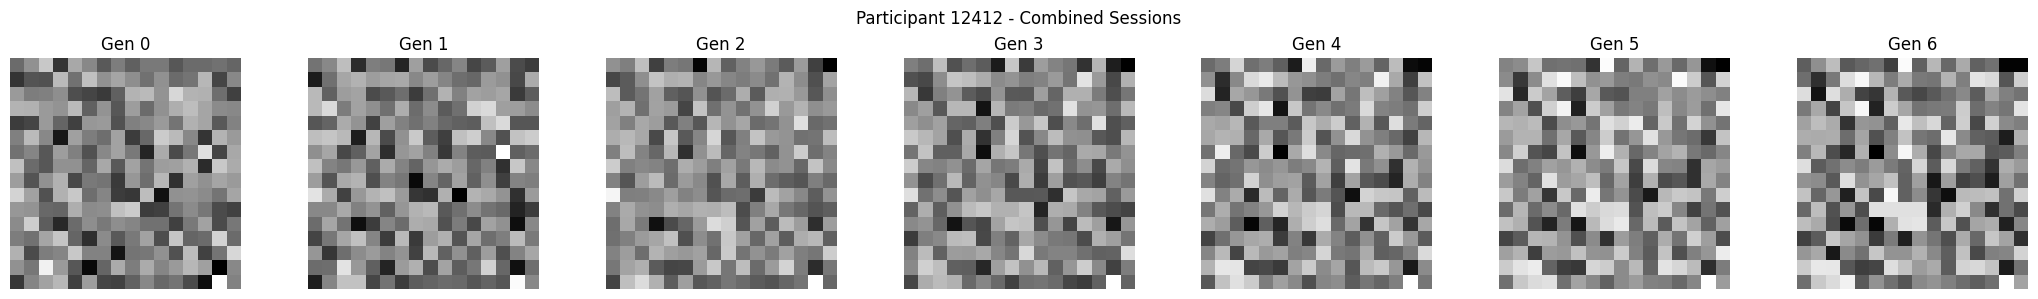


Visualizing Participant 11914


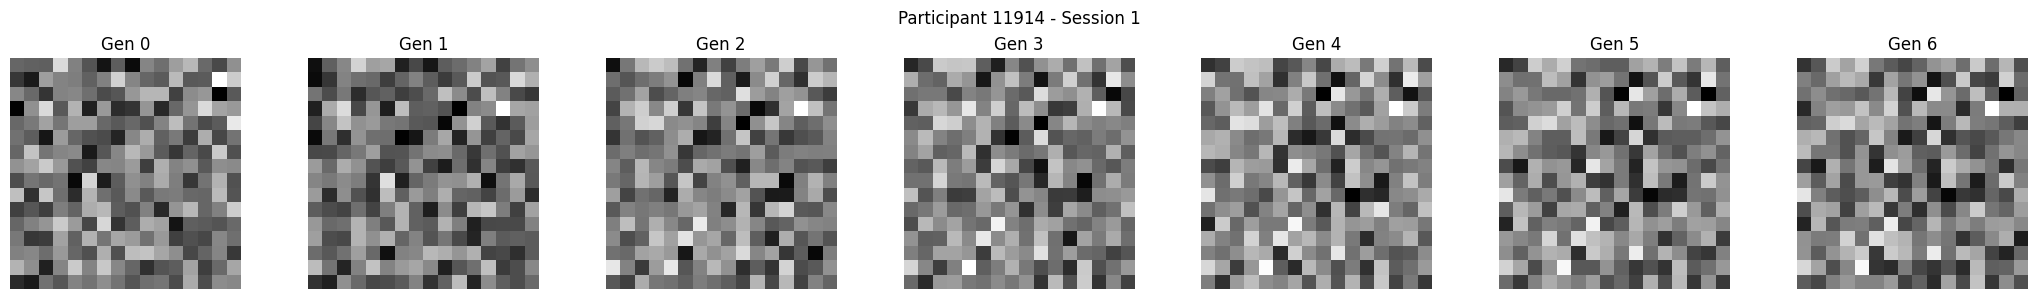

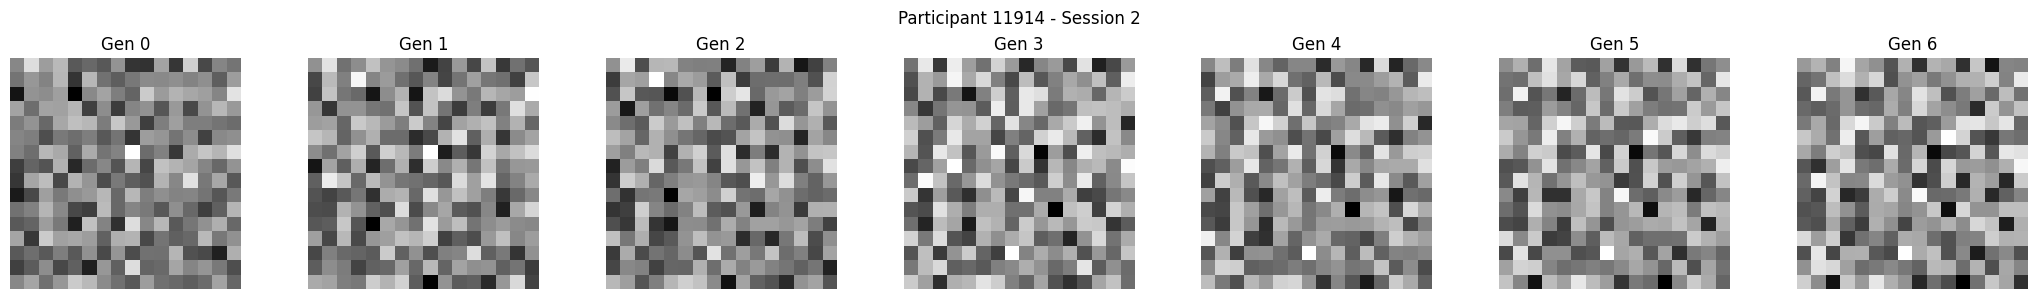

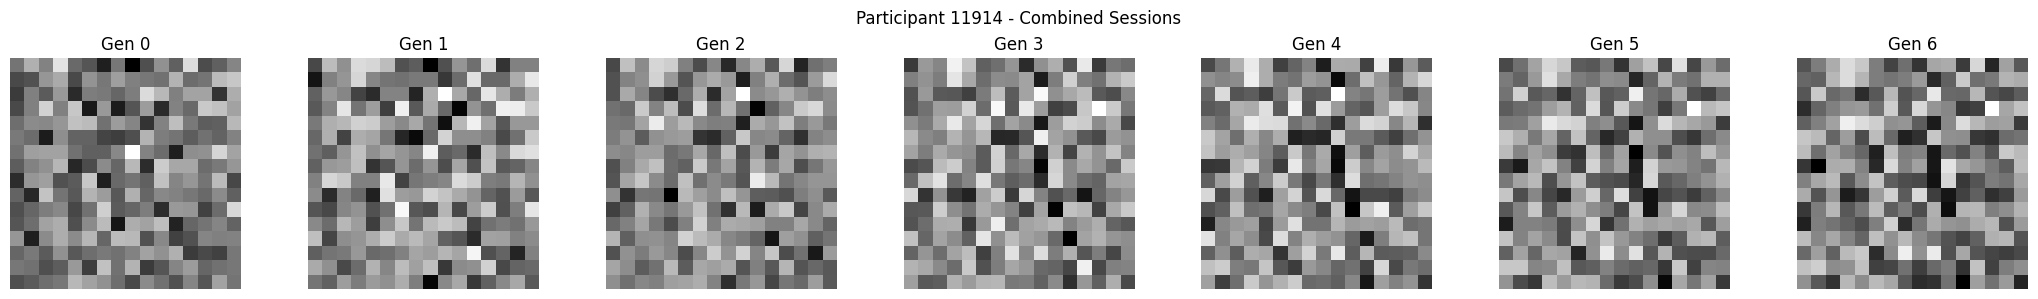


Visualizing Participant 12391


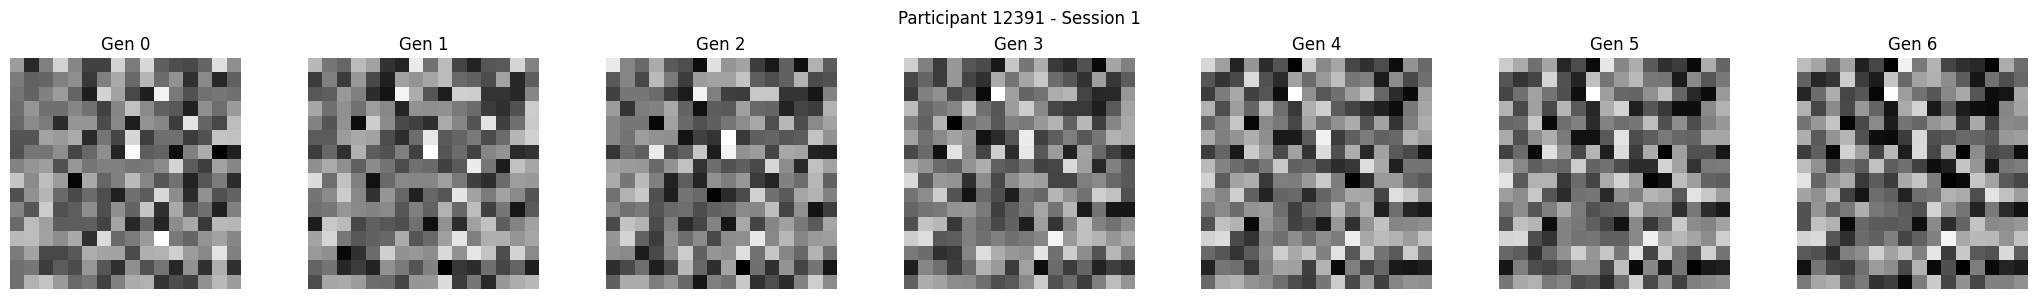

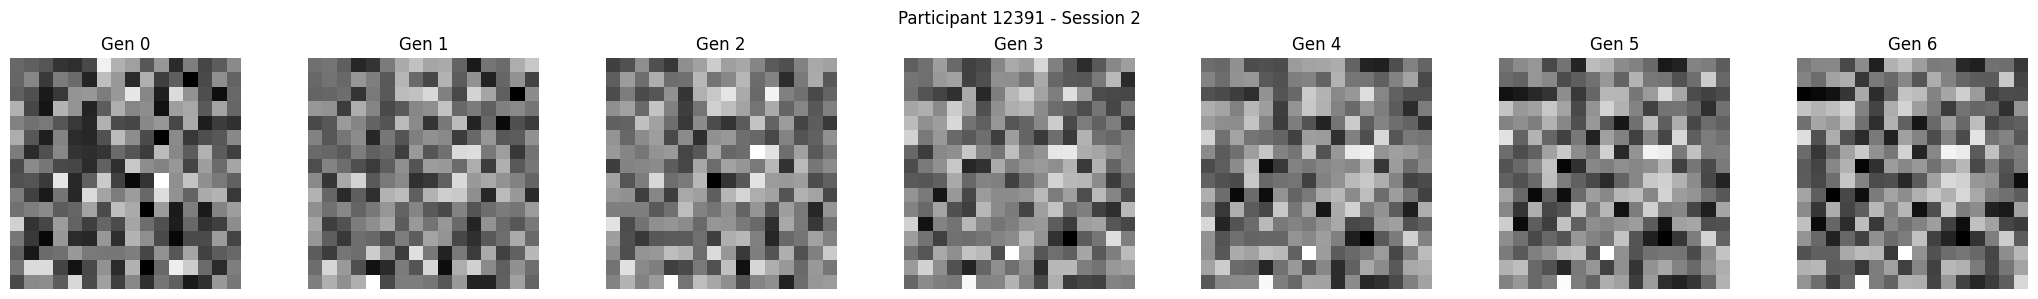

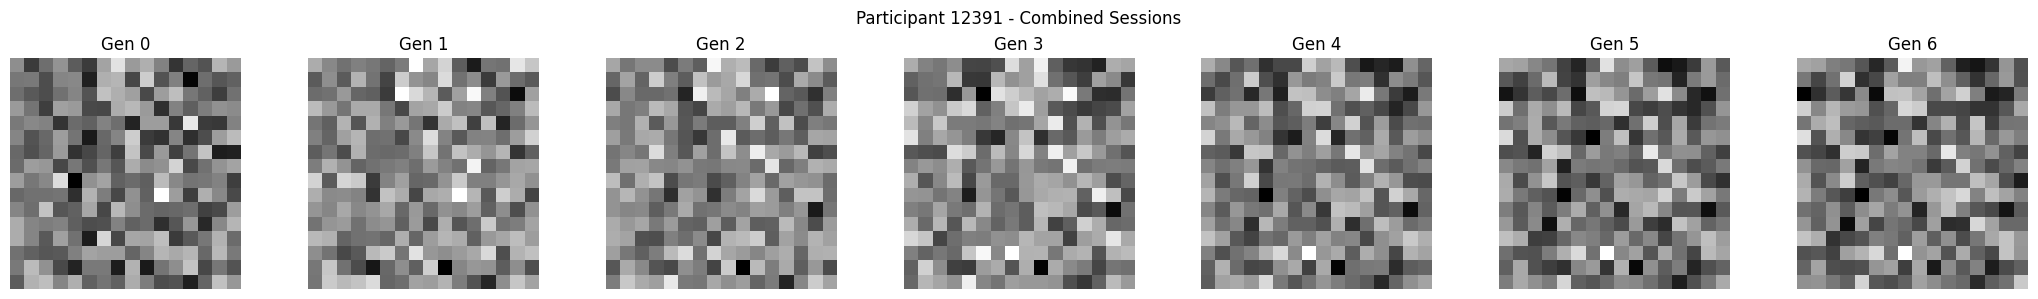


Visualizing Participant 12817


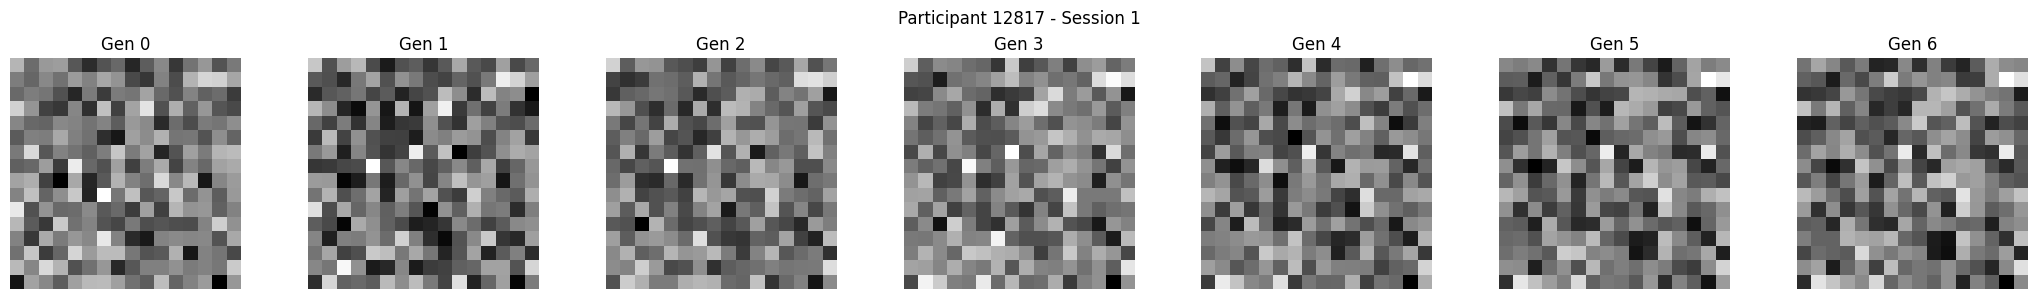

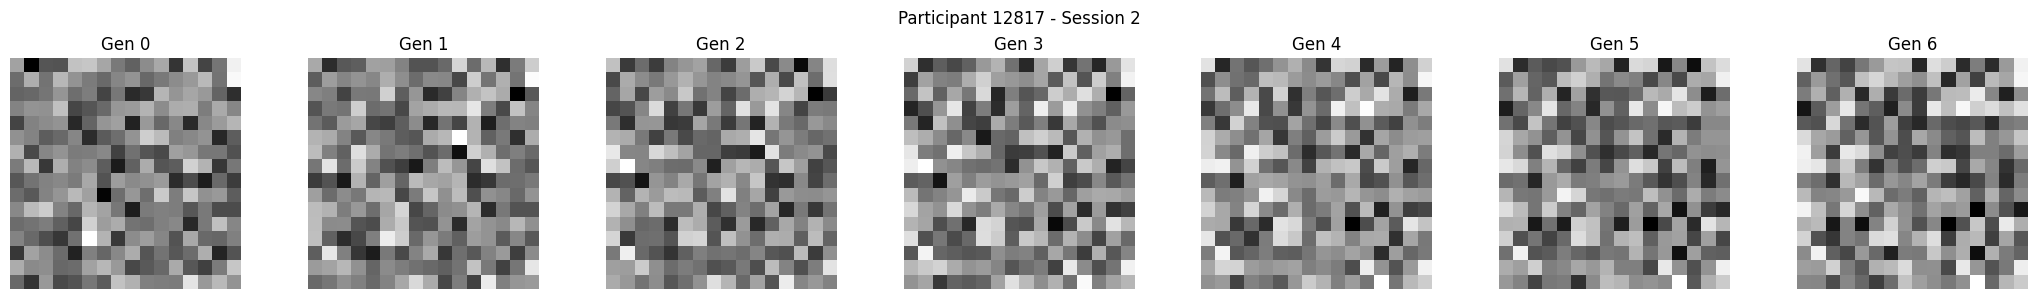

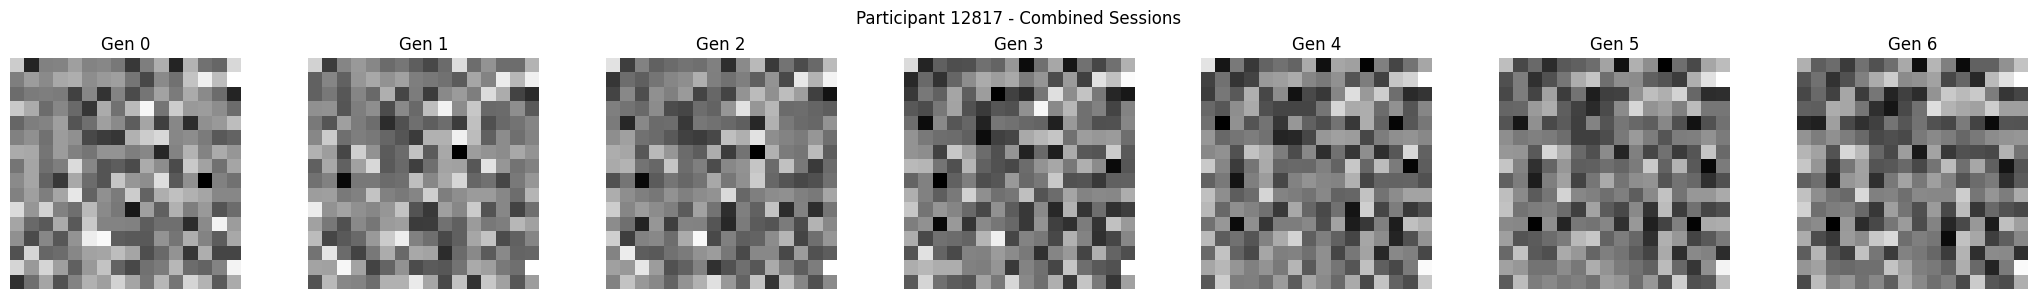


Visualizing Participant 13336


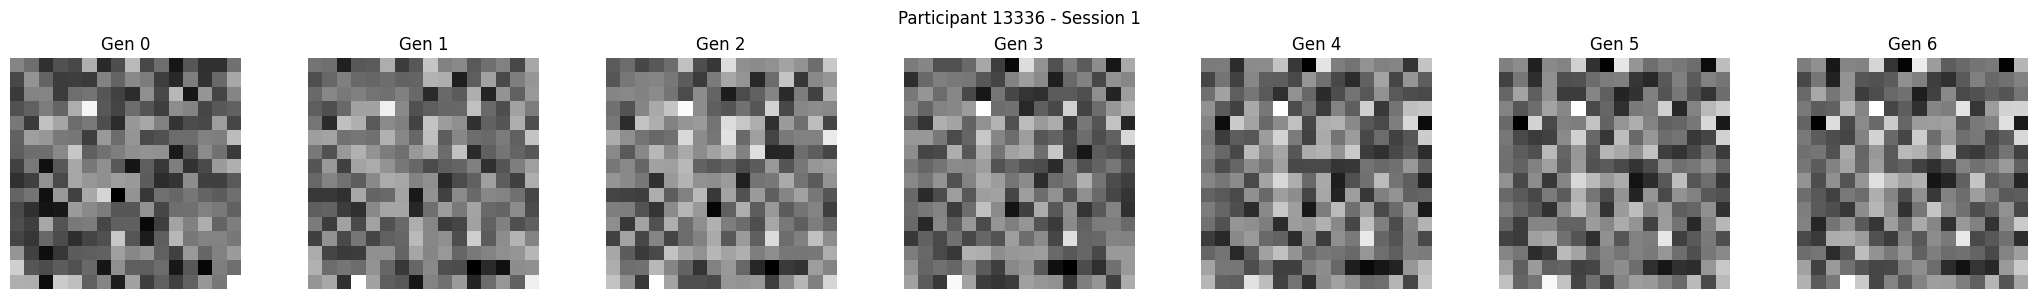

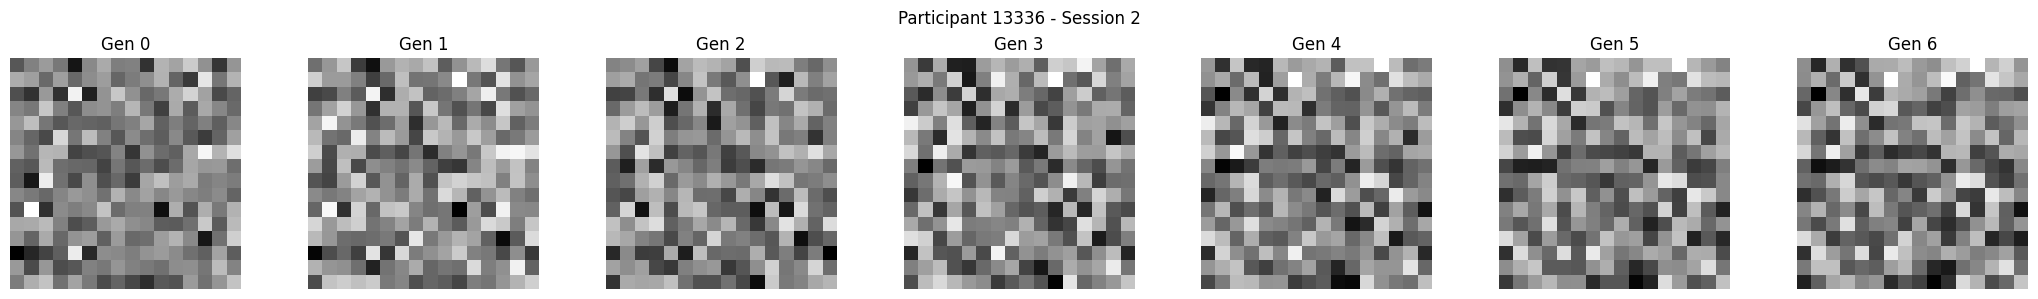

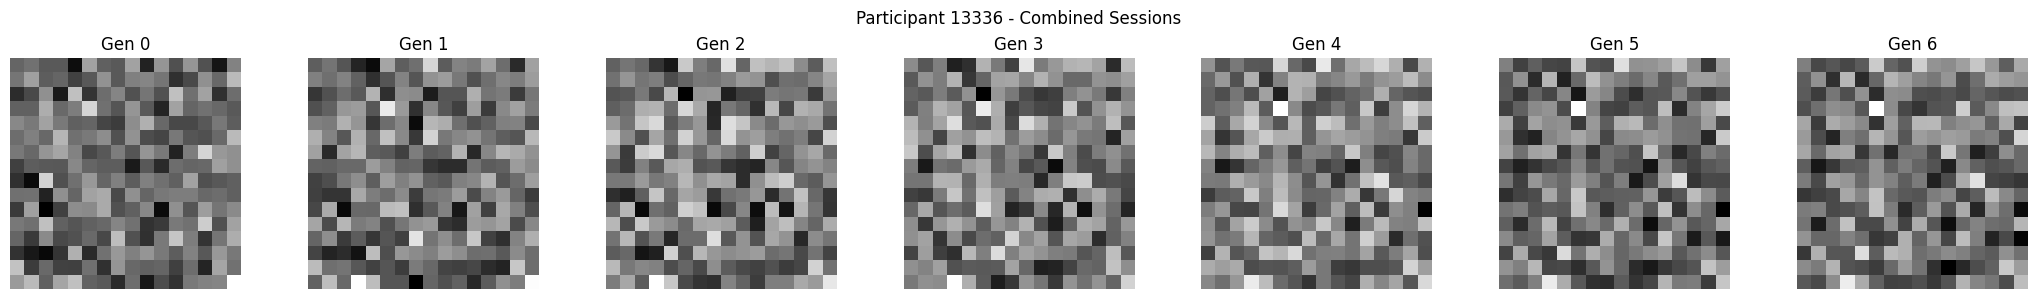


Visualizing Participant 12598


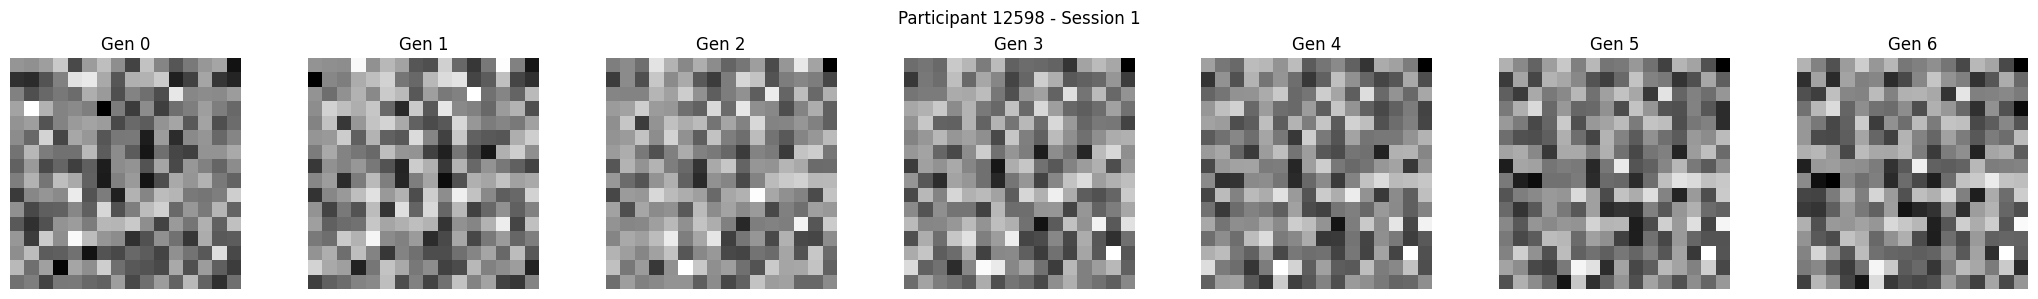

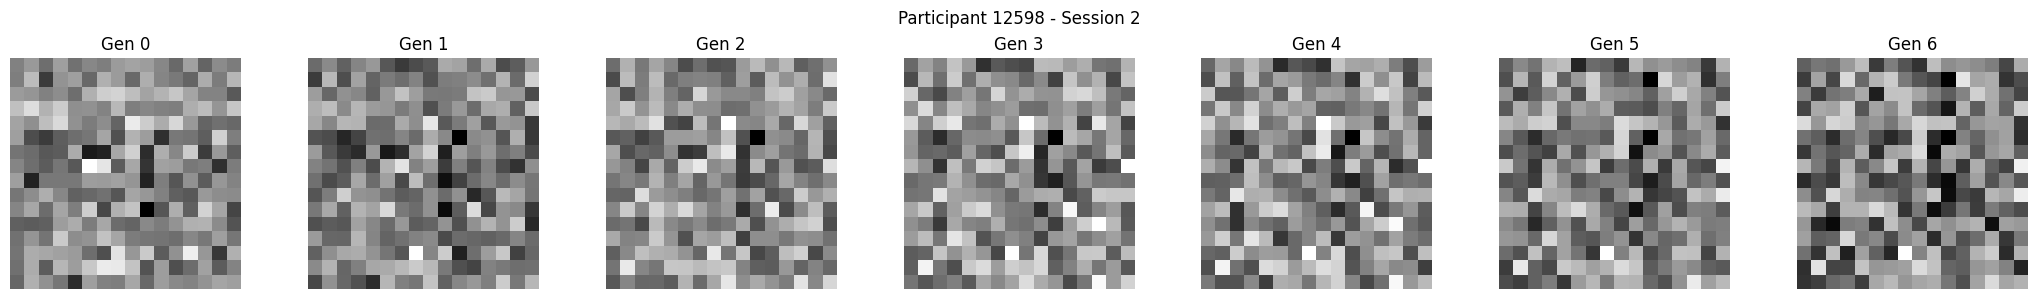

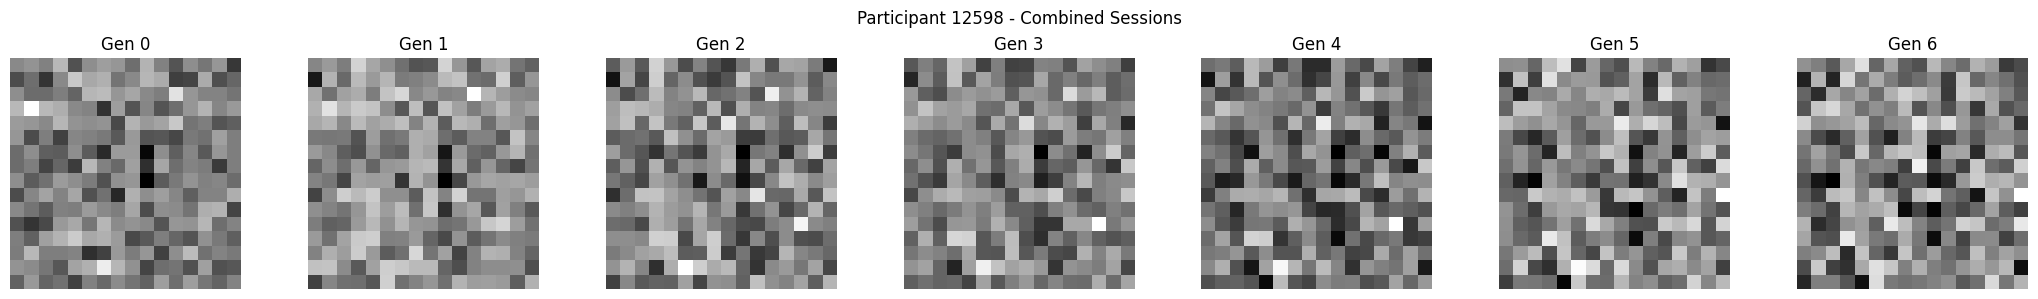


Visualizing Participant 12427


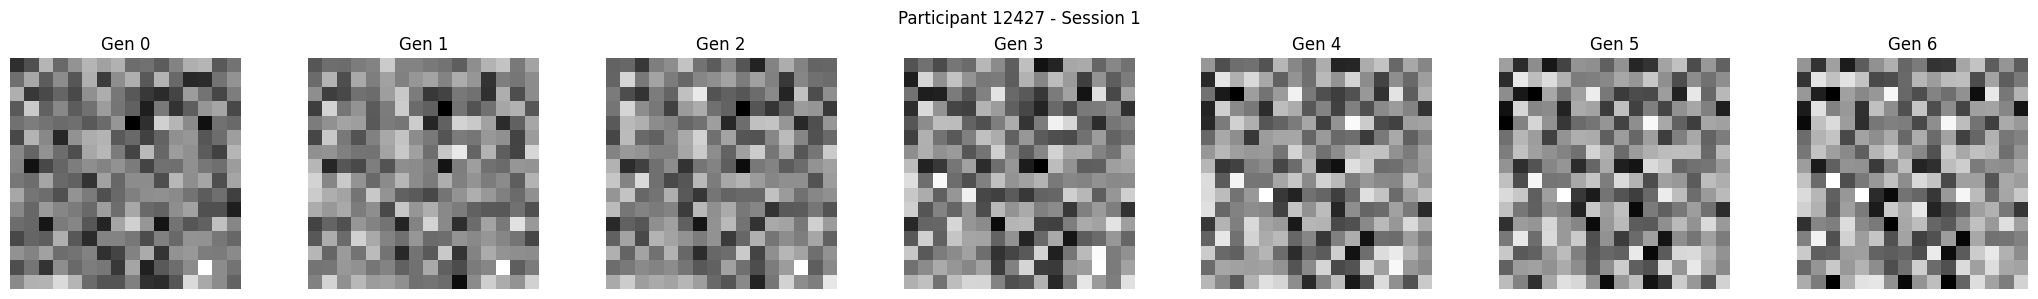

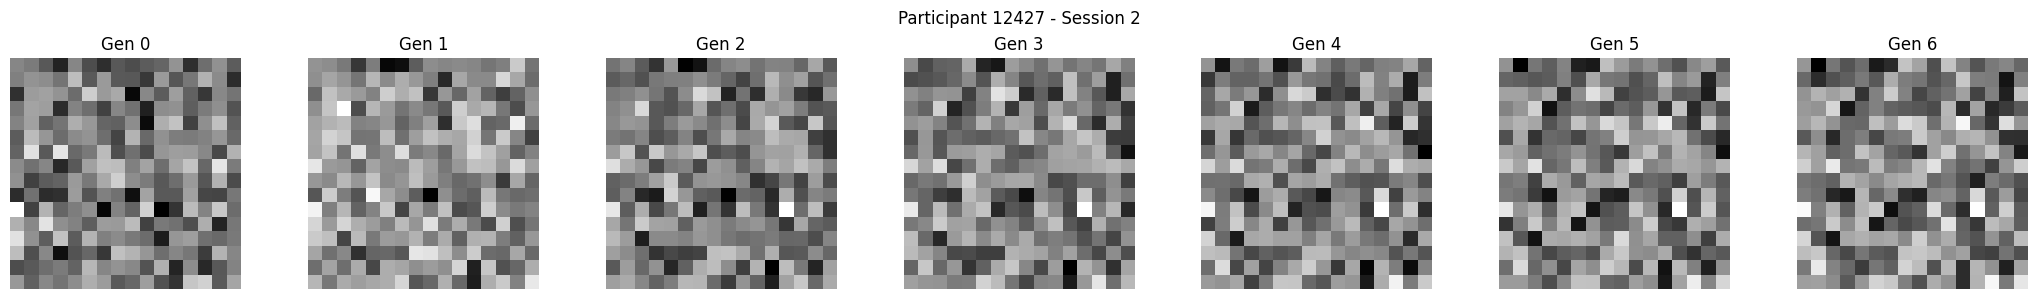

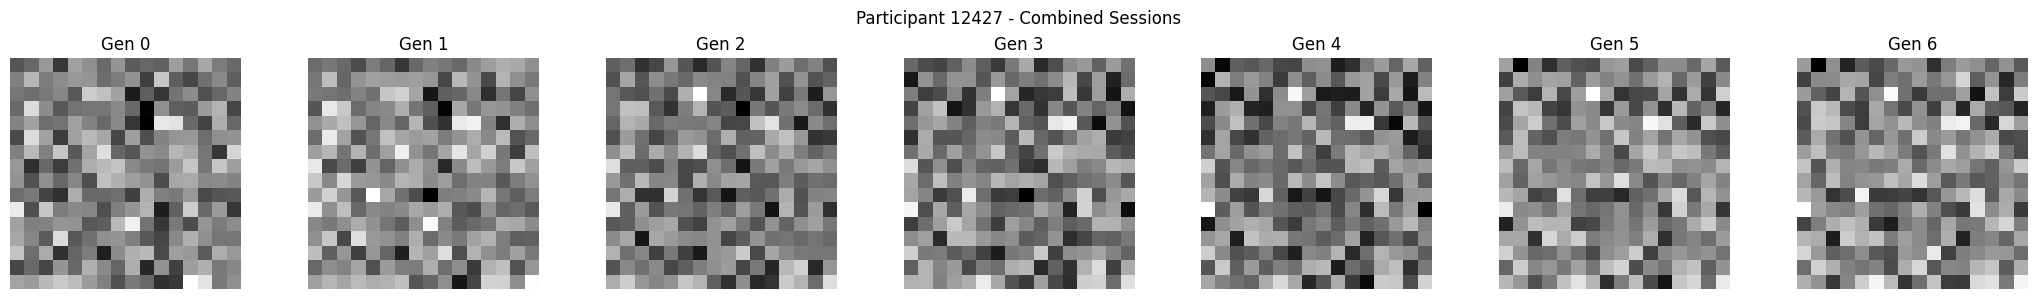


Visualizing Participant 12205


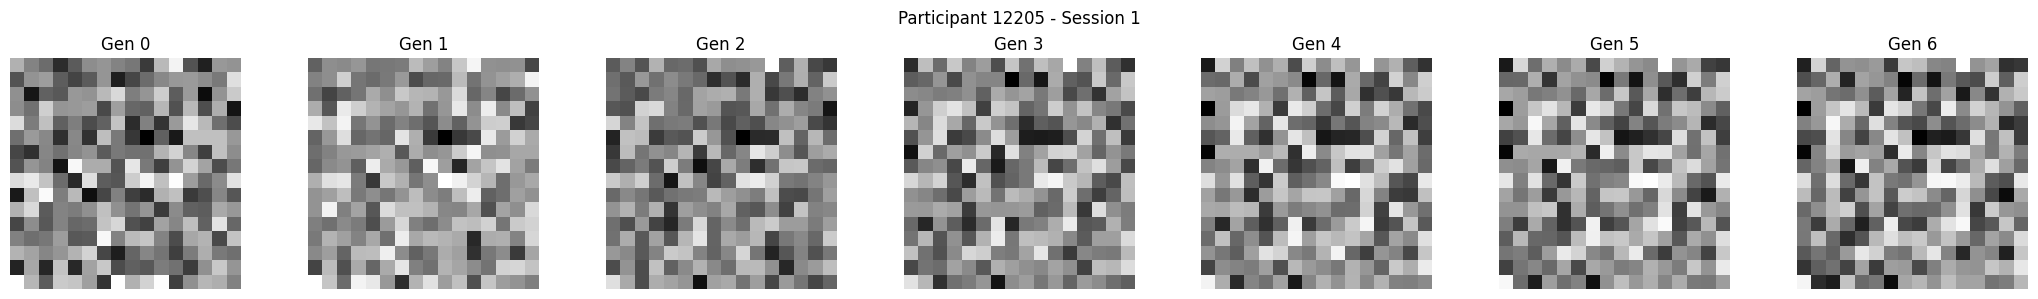

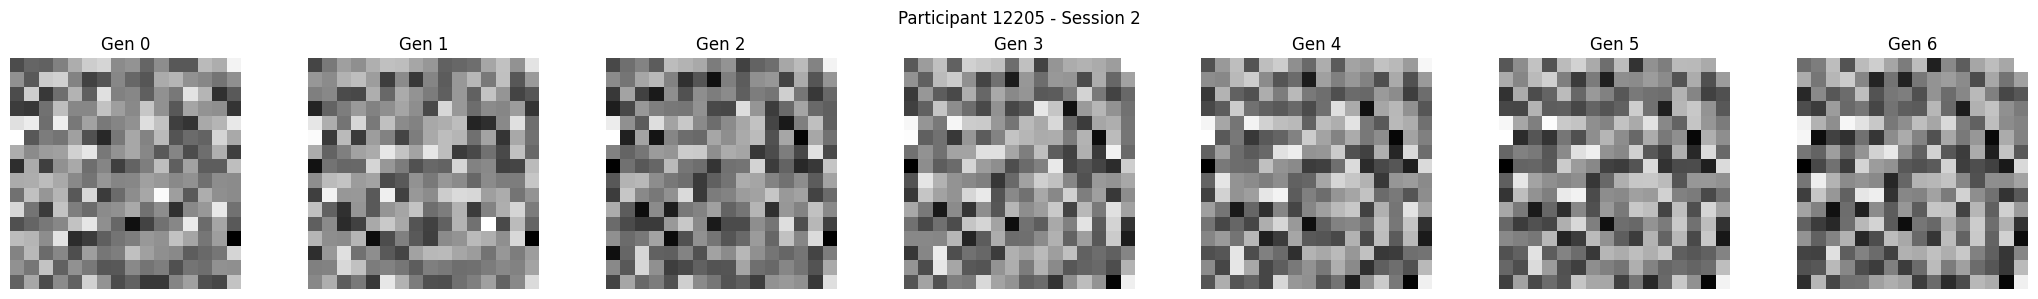

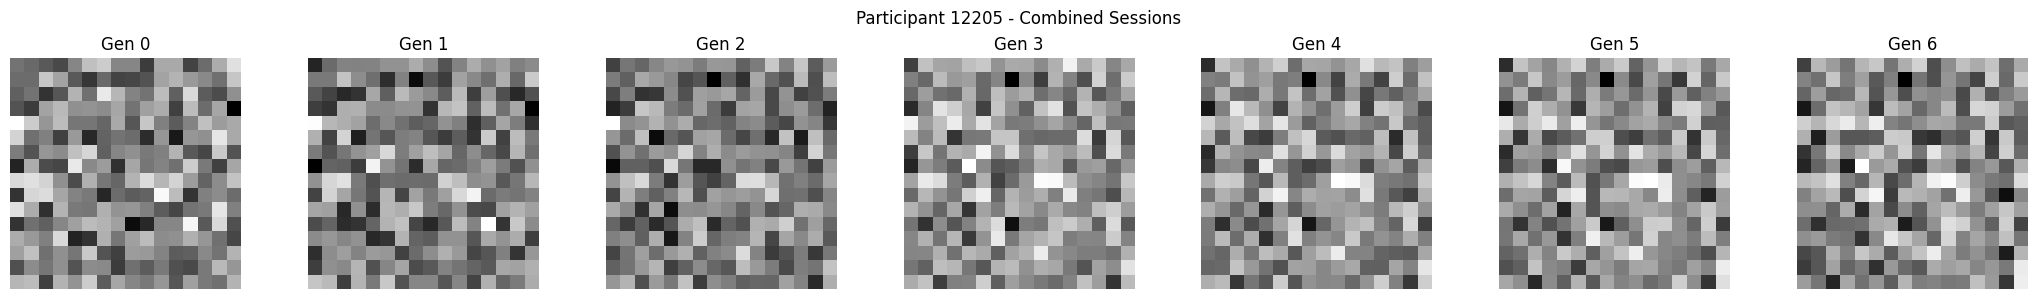


Visualizing Participant 13666


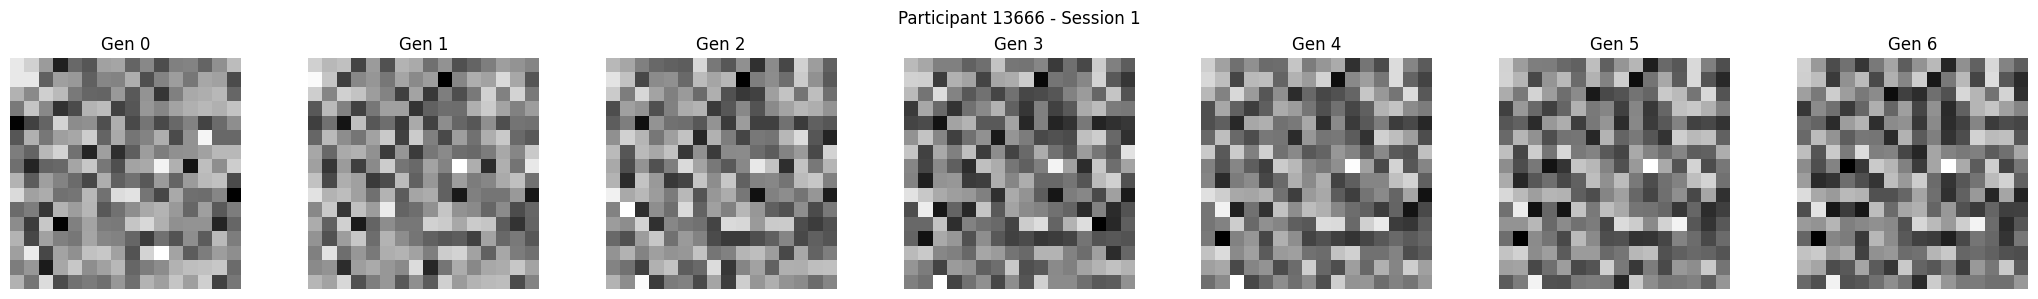

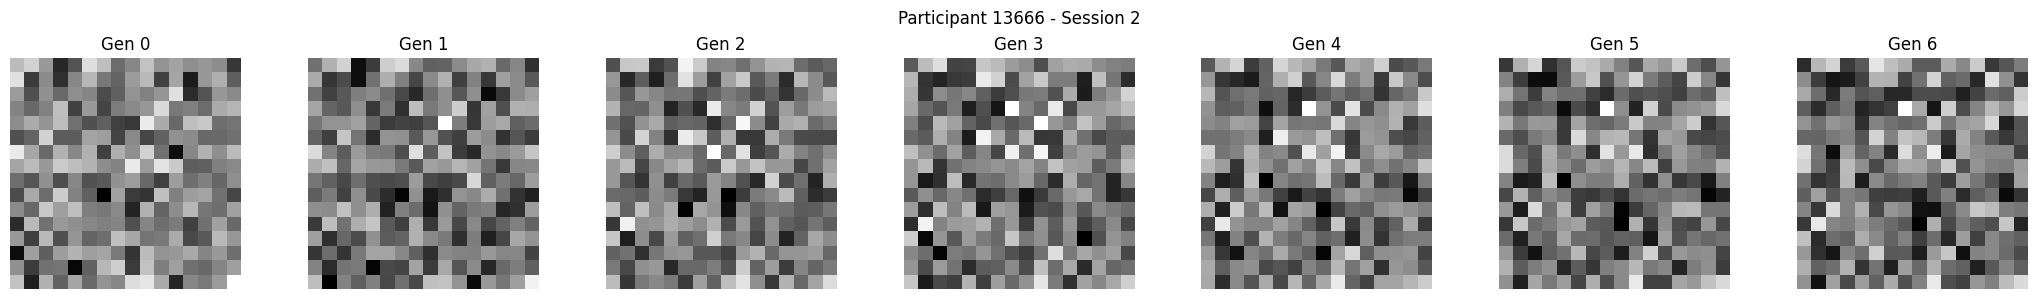

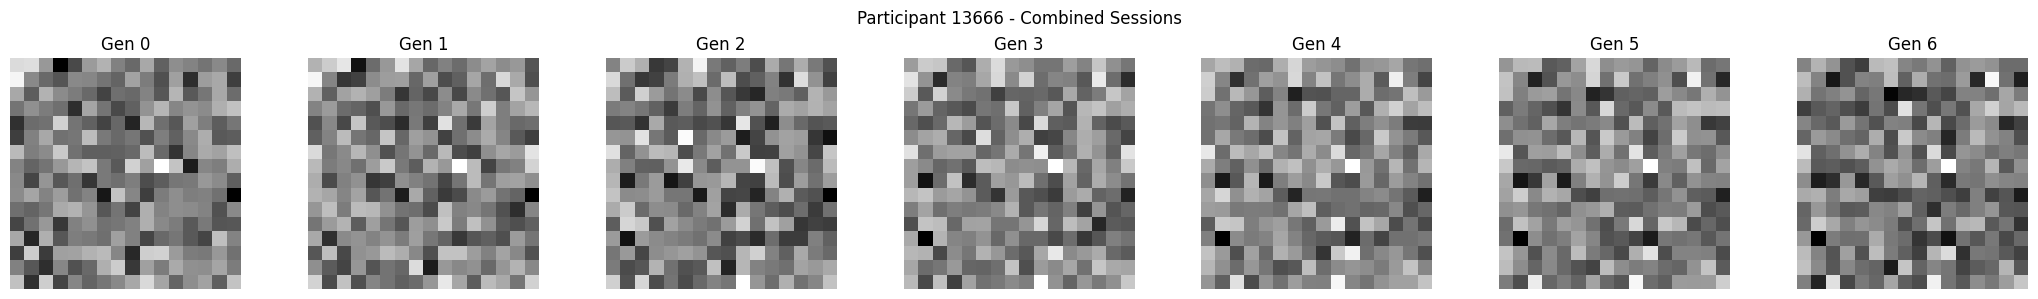


Visualizing Participant 13246


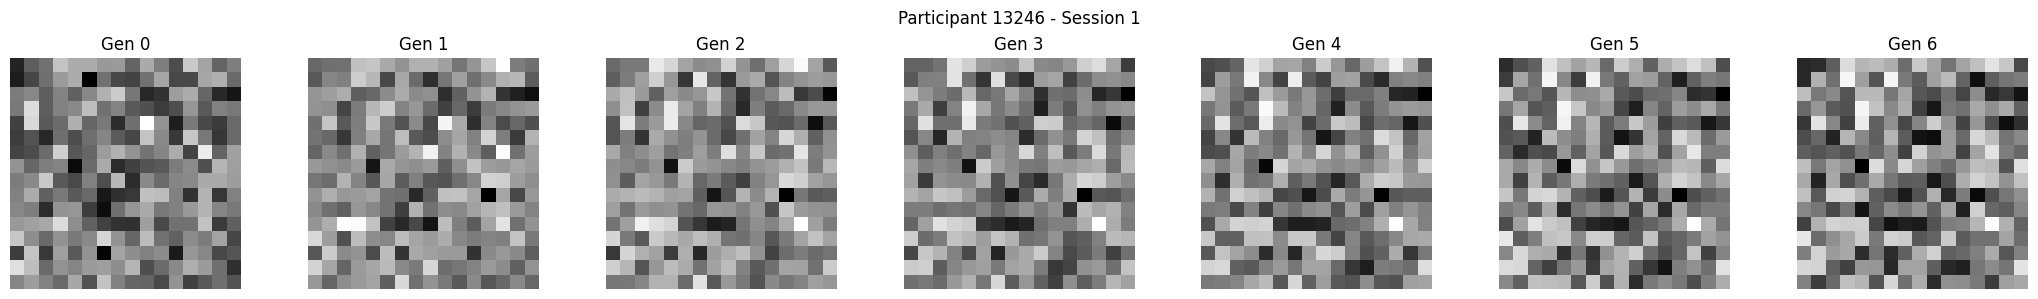

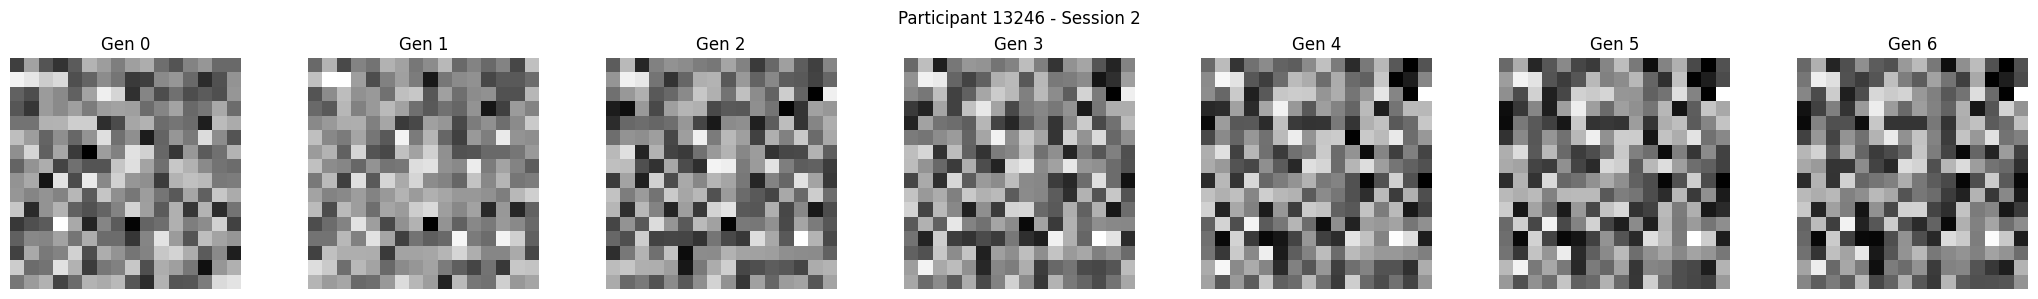

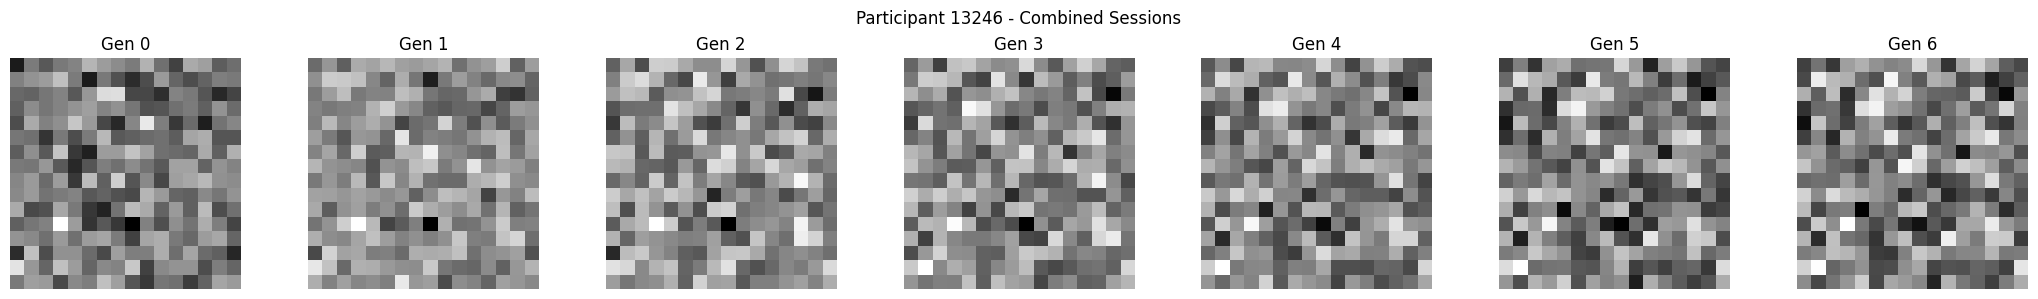


Visualizing Participant 11983


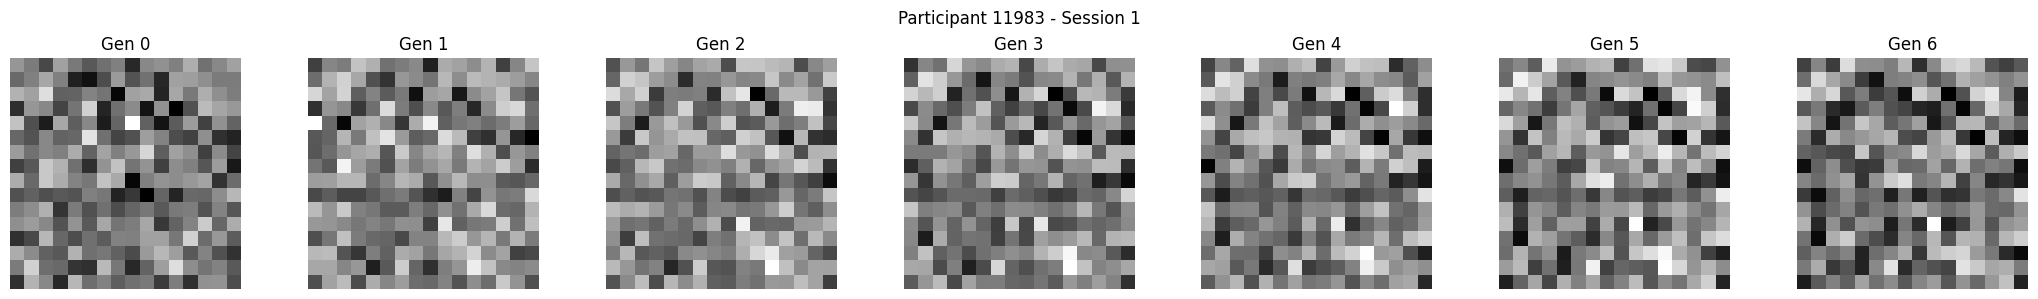

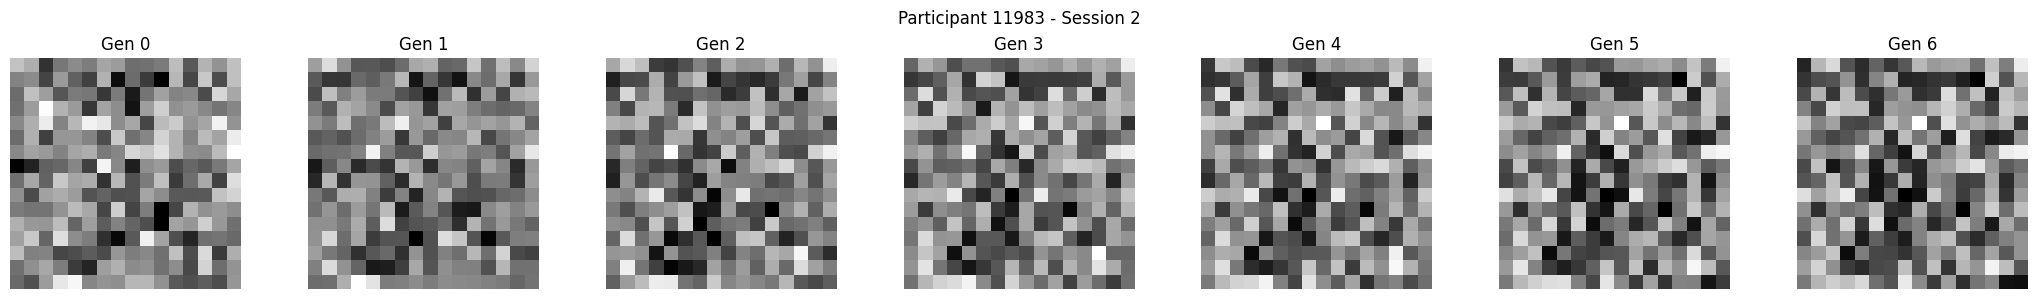

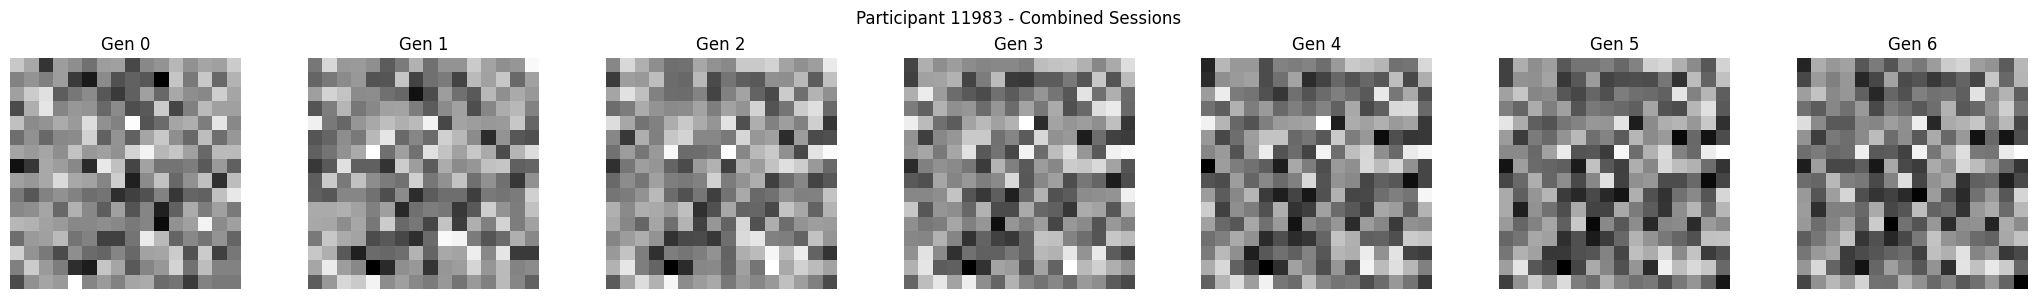


Visualizing Participant 12475


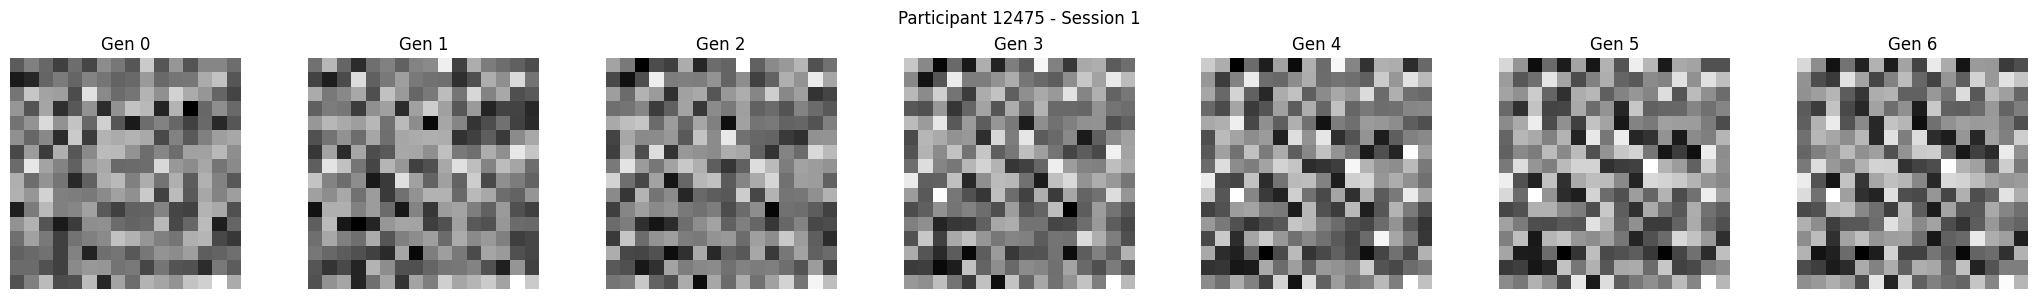

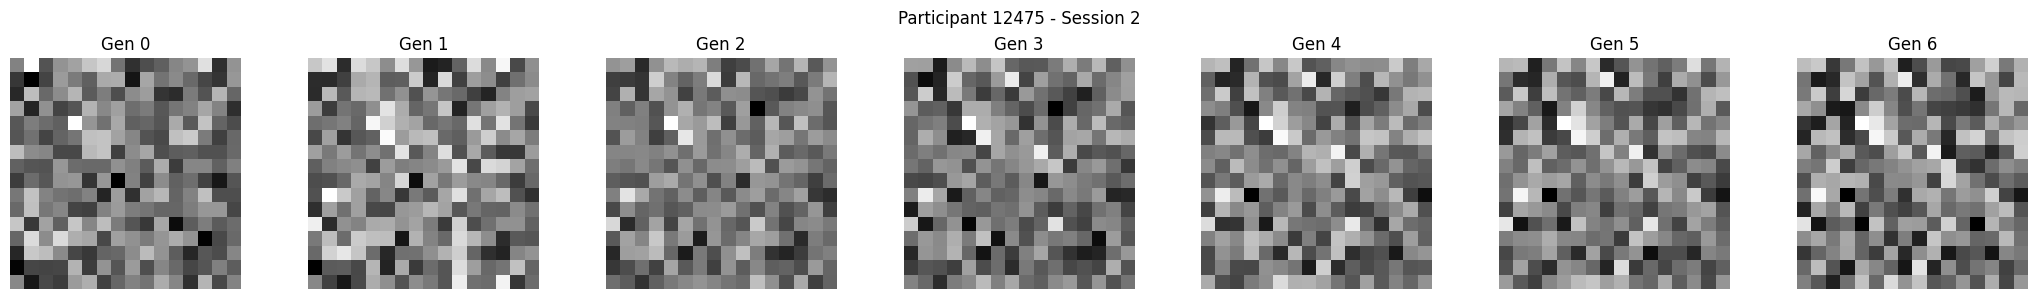

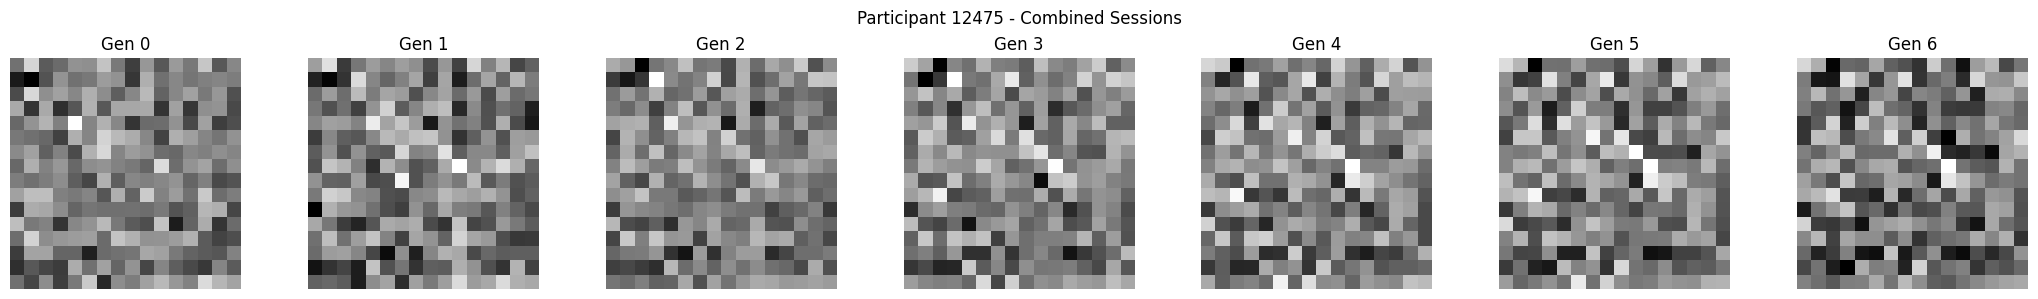


Visualizing Participant 12070


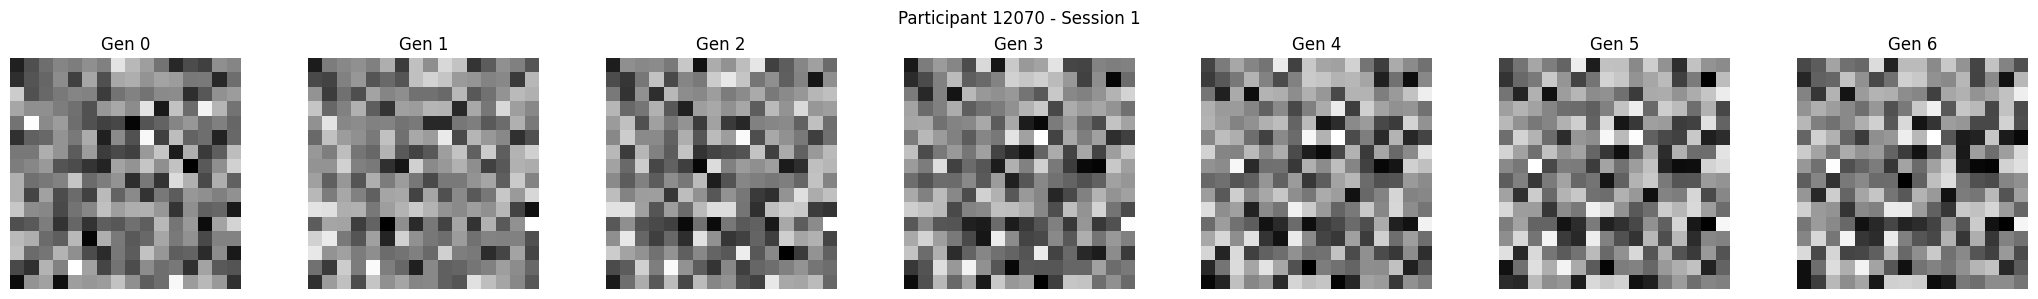

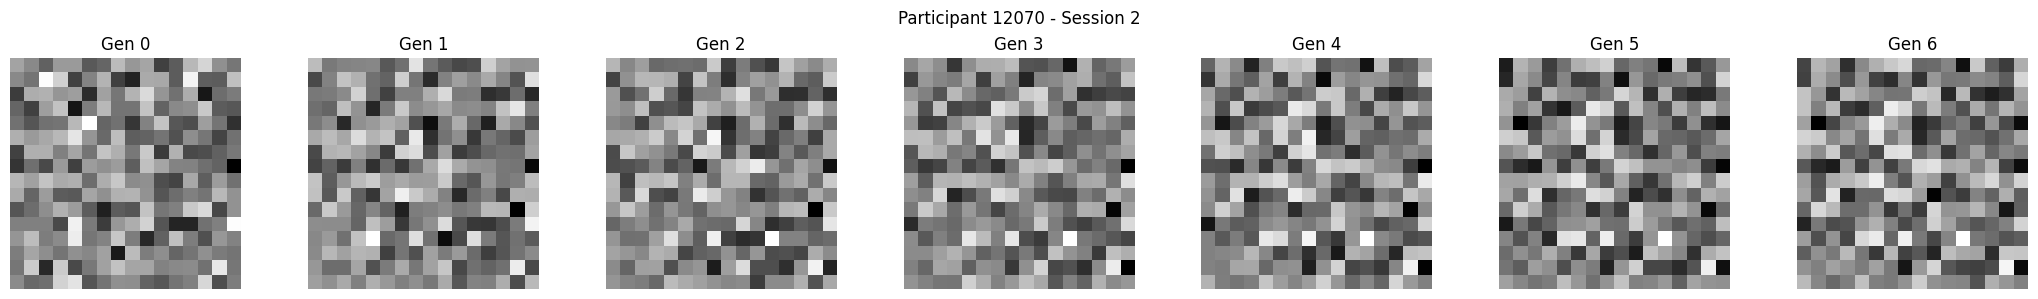

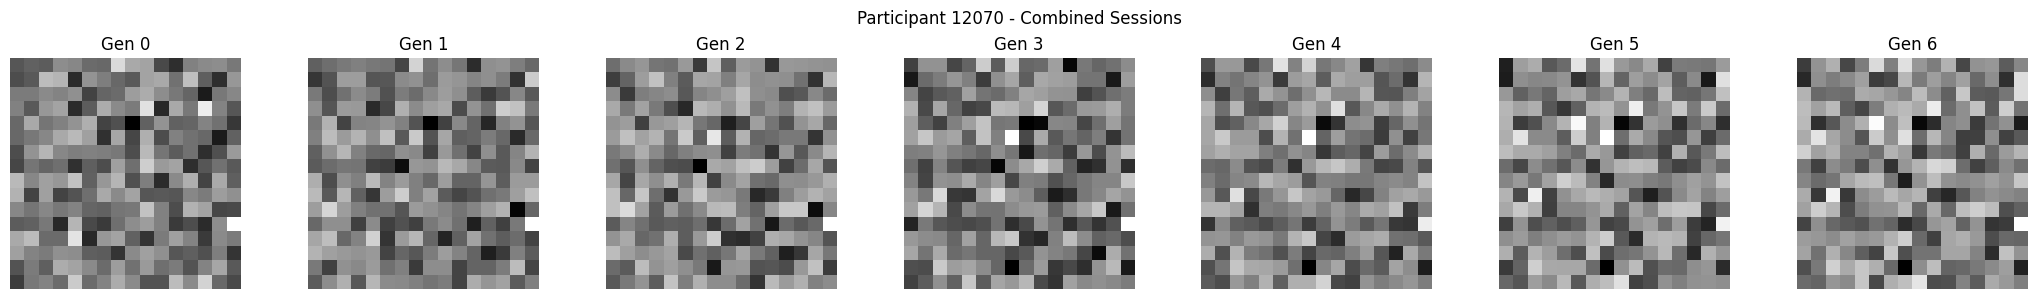

In [11]:
# Cell 1: Combine clean participants with original data
def process_evolution_data(valid_results, clean_dfs):
    # Get list of clean participants (those who passed attention checks)
    clean_participants = clean_dfs['participants'].index.tolist()
    
    # Process only clean participants' data
    results = {}
    for result in valid_results:
        participant_id = result['metadata']['participant_id']
        if participant_id in clean_participants:  # Only process clean participants
            if 'evolution_summary' in result:
                results[participant_id] = {}
                
                for gen_data in result['evolution_summary']:
                    session = gen_data['session']
                    if session not in results[participant_id]:
                        results[participant_id][session] = {}
                    
                    generation = gen_data['generation']
                    if 'selected_parents' in gen_data:
                        results[participant_id][session][generation] = {
                            'selected': [p['filtered_image'] for p in gen_data['selected_parents']]
                        }
    
    return results

def plot_participant_sessions_with_combined(participant_data, participant_id):
    # First plot individual sessions
    for session, session_data in participant_data.items():
        generations = sorted(session_data.keys())
        n_gens = len(generations)
        
        if n_gens == 0:
            print(f"No generations found for Participant {participant_id}, Session {session}")
            continue
            
        fig, axes = plt.subplots(1, n_gens, figsize=(3*n_gens, 3))
        if n_gens == 1:
            axes = [axes]
        
        for idx, gen in enumerate(generations):
            gen_images = []
            for img_base64 in session_data[gen]['selected']:
                try:
                    img = decode_base64_image(img_base64)
                    gen_images.append(img)
                except:
                    continue
                    
            if gen_images:
                composite = create_composite_image(gen_images)
                axes[idx].imshow(composite, cmap='gray')
                axes[idx].axis('off')
                axes[idx].set_title(f'Gen {gen}')
        
        plt.suptitle(f'Participant {participant_id} - Session {session}')
        plt.tight_layout()
        plt.show()
        plt.close()

    # Then create and plot combined sessions
    combined_generations = {}
    for session, session_data in participant_data.items():
        for gen, gen_data in session_data.items():
            if gen not in combined_generations:
                combined_generations[gen] = []
            combined_generations[gen].extend(gen_data['selected'])

    # Plot combined sessions
    fig, axes = plt.subplots(1, len(combined_generations), figsize=(3*len(combined_generations), 3))
    if len(combined_generations) == 1:
        axes = [axes]

    for idx, (gen, gen_images_base64) in enumerate(sorted(combined_generations.items())):
        gen_images = []
        for img_base64 in gen_images_base64:
            try:
                img = decode_base64_image(img_base64)
                gen_images.append(img)
            except:
                continue

        if gen_images:
            composite = create_composite_image(gen_images)
            axes[idx].imshow(composite, cmap='gray')
            axes[idx].axis('off')
            axes[idx].set_title(f'Gen {gen}')

    plt.suptitle(f'Participant {participant_id} - Combined Sessions')
    plt.tight_layout()
    plt.show()
    plt.close()

# Update the visualization function in your pipeline
def visualize_clean_evolution(valid_results, clean_dfs):
    clean_participant_data = process_evolution_data(valid_results, clean_dfs)
    
    print("Clean Evolution Data Summary:")
    for participant_id, data in clean_participant_data.items():
        print(f"\nParticipant {participant_id}:")
        for session, session_data in data.items():
            print(f"  Session {session}: {len(session_data)} generations")
            print(f"  Available generations: {sorted(session_data.keys())}")
    
    for participant_id, data in clean_participant_data.items():
        print(f"\nVisualizing Participant {participant_id}")
        plot_participant_sessions_with_combined(data, participant_id)

# Run the analysis
visualize_clean_evolution(valid_results, clean_dfs)